In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [3]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

## Simple linear regression

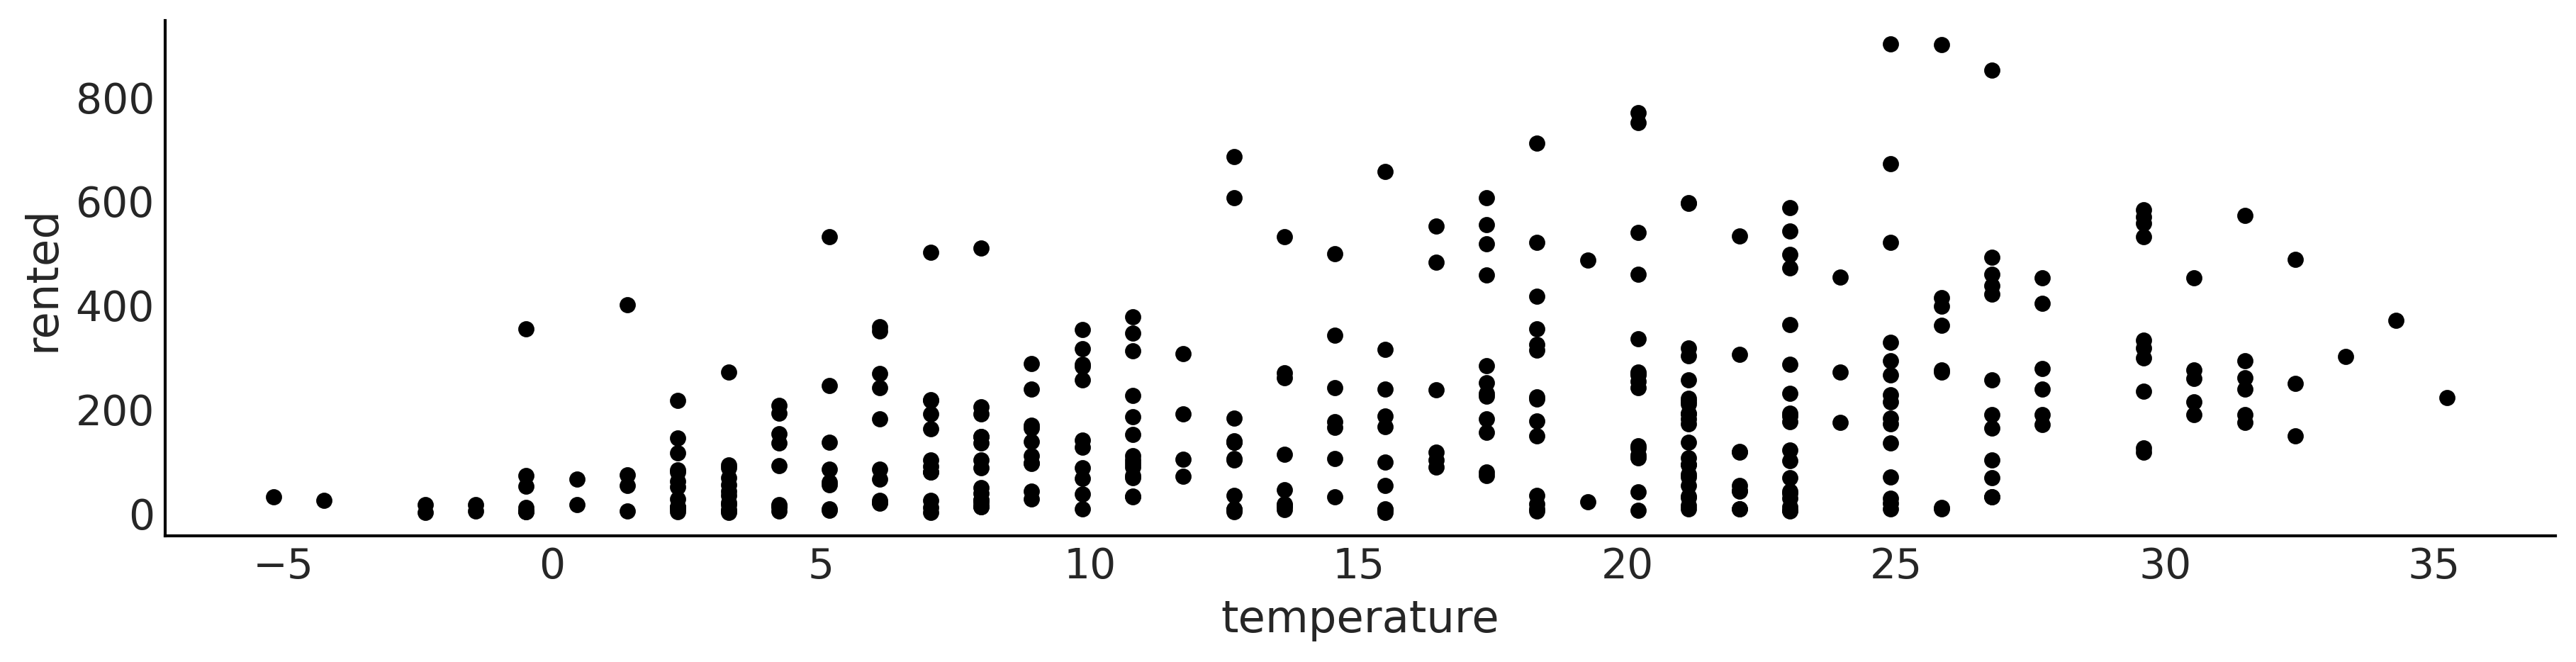

In [4]:
bikes = pd.read_csv("../code/data/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter");
# plt.savefig("../fig/bike_temperature.png")

In [5]:
with pm.Model() as model_lb:
    alpha = pm.Normal('alpha', mu = 0, sigma = 100)
    beta = pm.Normal('beta', mu = 0, sigma = 10)
    sigma = pm.HalfCauchy('sigma', 10)
    mu = pm.Deterministic('mu', alpha + beta * bikes.temperature)
    y_pred = pm.Normal('y_pred', mu = mu, sigma = sigma, observed = bikes.rented)
    idata_lb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [6]:
# graph = pm.model_to_graphviz(model_lb)
# graph.graph_attr.update(size="4,4!")
# graph.graph_attr.update(dpi="300")
# graph.render(filename="../fig/linear_bikes_dag", format="png", cleanup=True)

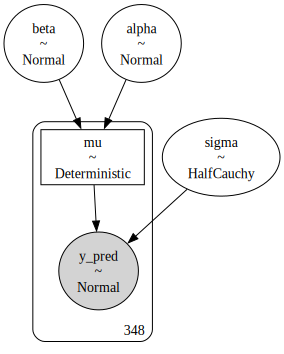

In [7]:
pm.model_to_graphviz(model_lb)

In [8]:
idata_lb

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
type(idata_lb.posterior)

xarray.core.dataset.Dataset

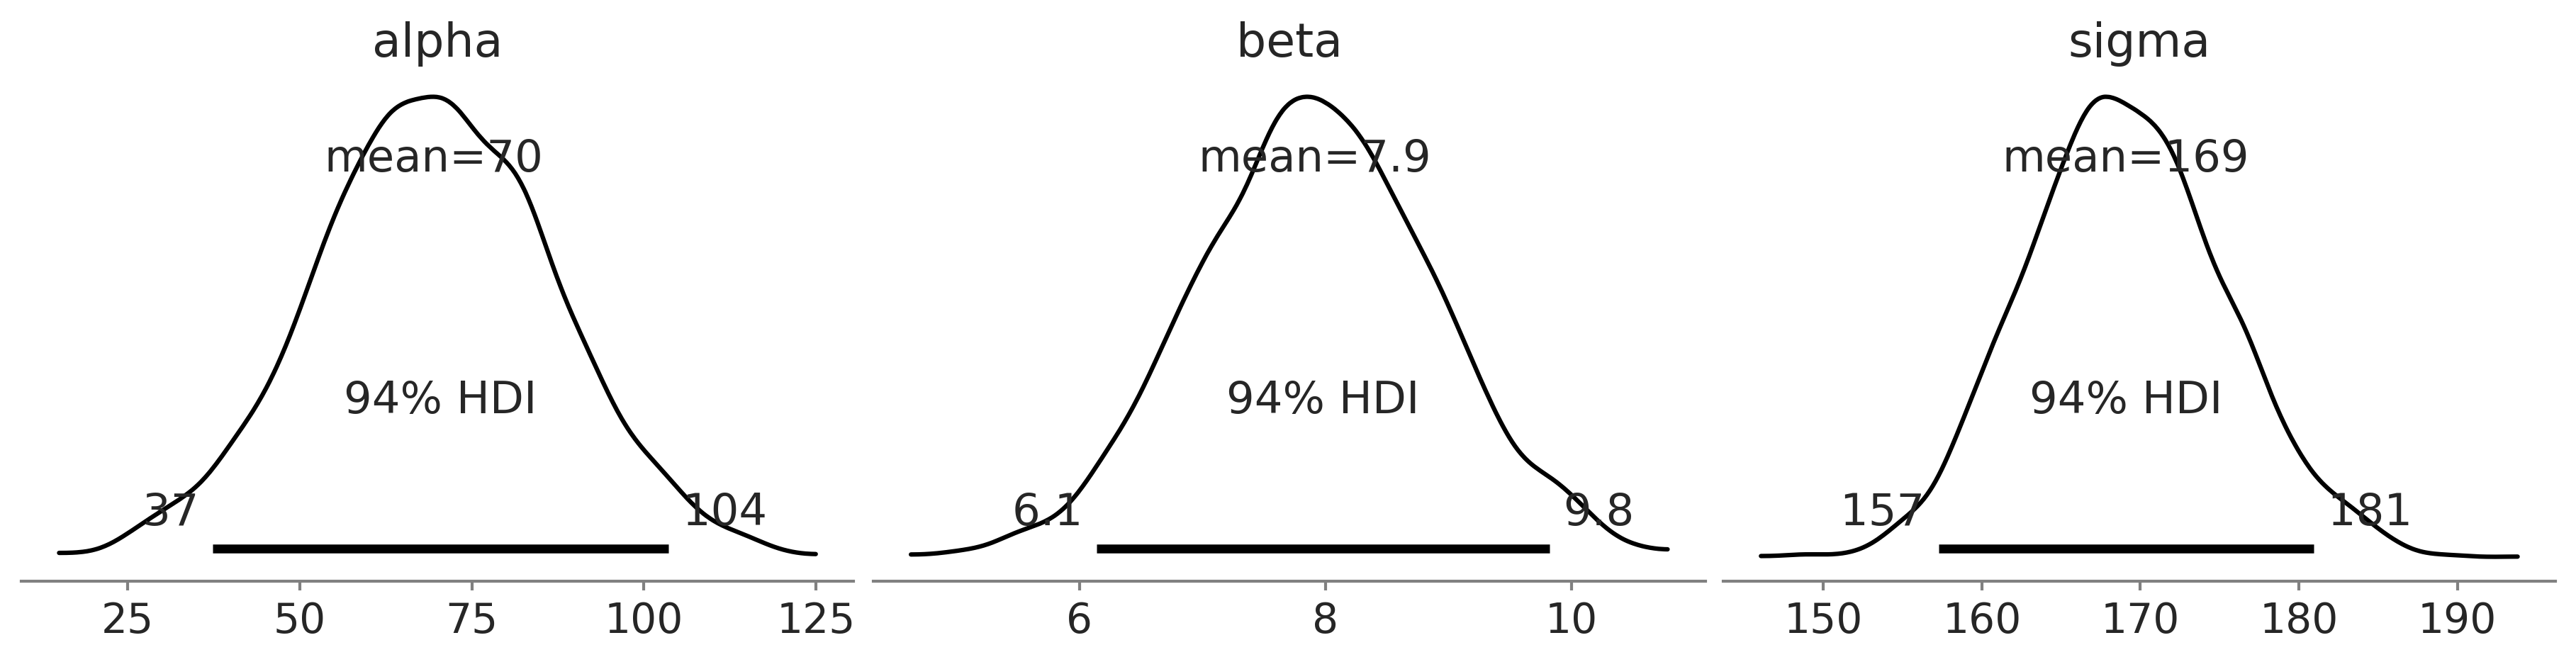

In [10]:
# Omit mu from posterior plot otherwise we would get many plats, one for each temperature
az.plot_posterior(data=idata_lb, var_names=['~mu'], figsize=(12,3));

In [11]:
posterior = az.extract(idata_lb, num_samples=50)

xplot = xr.DataArray(np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id")

mean_line = posterior['alpha'].mean() + posterior['beta'].mean() * xplot

lines = posterior['alpha'] + posterior['beta'] * xplot

hdi_lines = az.hdi(idata_lb.posterior['mu'] )

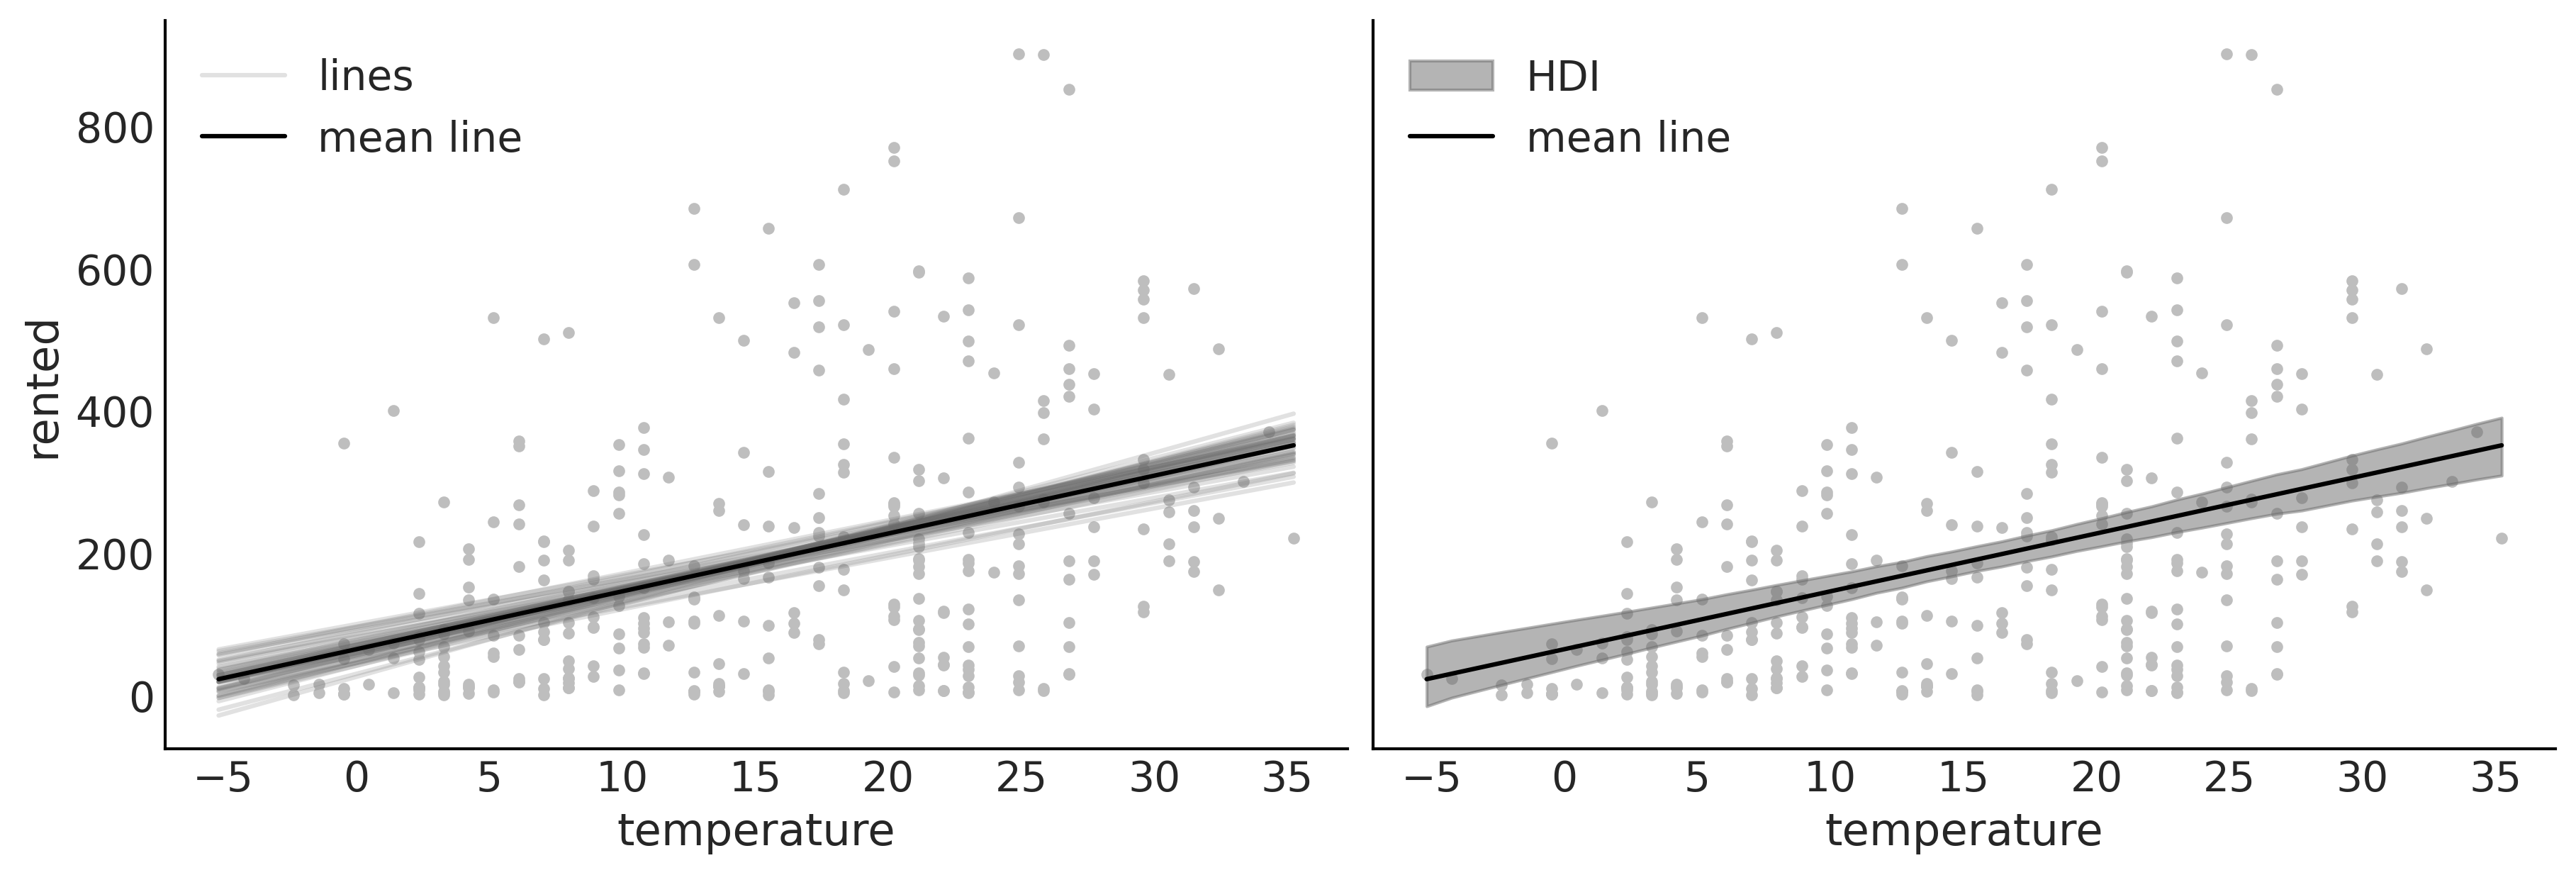

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
lines_ = axes[0].plot(xplot, lines.T, c="C1", alpha=0.2, label="lines")
plt.setp(lines_[1:],  label="_")
axes[0].plot(xplot, mean_line, "C0", label="mean line")
axes[0].set_xlabel("temperature")
axes[0].set_ylabel("rented")
axes[0].legend()

axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
idx = np.argsort(bikes.temperature.values)
axes[1].fill_between(
    bikes.temperature[idx],
    hdi_lines['mu'][:,1][idx],
    hdi_lines['mu'][:,0][idx],
    color='C1',
    label='HDI',
    alpha = 0.5
)
axes[1].plot(xplot, mean_line, "C0", label="mean line")
axes[1].set_xlabel("temperature")
axes[1].legend();

# Posterior predictions

In [13]:
pm.sample_posterior_predictive(idata_lb, model=model_lb, extend_inferencedata=True)

Sampling: [y_pred]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [14]:
mean_lines = idata_lb.posterior['mu'].mean(('chain', 'draw'))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_lb.posterior_predictive['y_pred'].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=['chain', 'draw']
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

In [15]:
# help(PchipInterpolator)

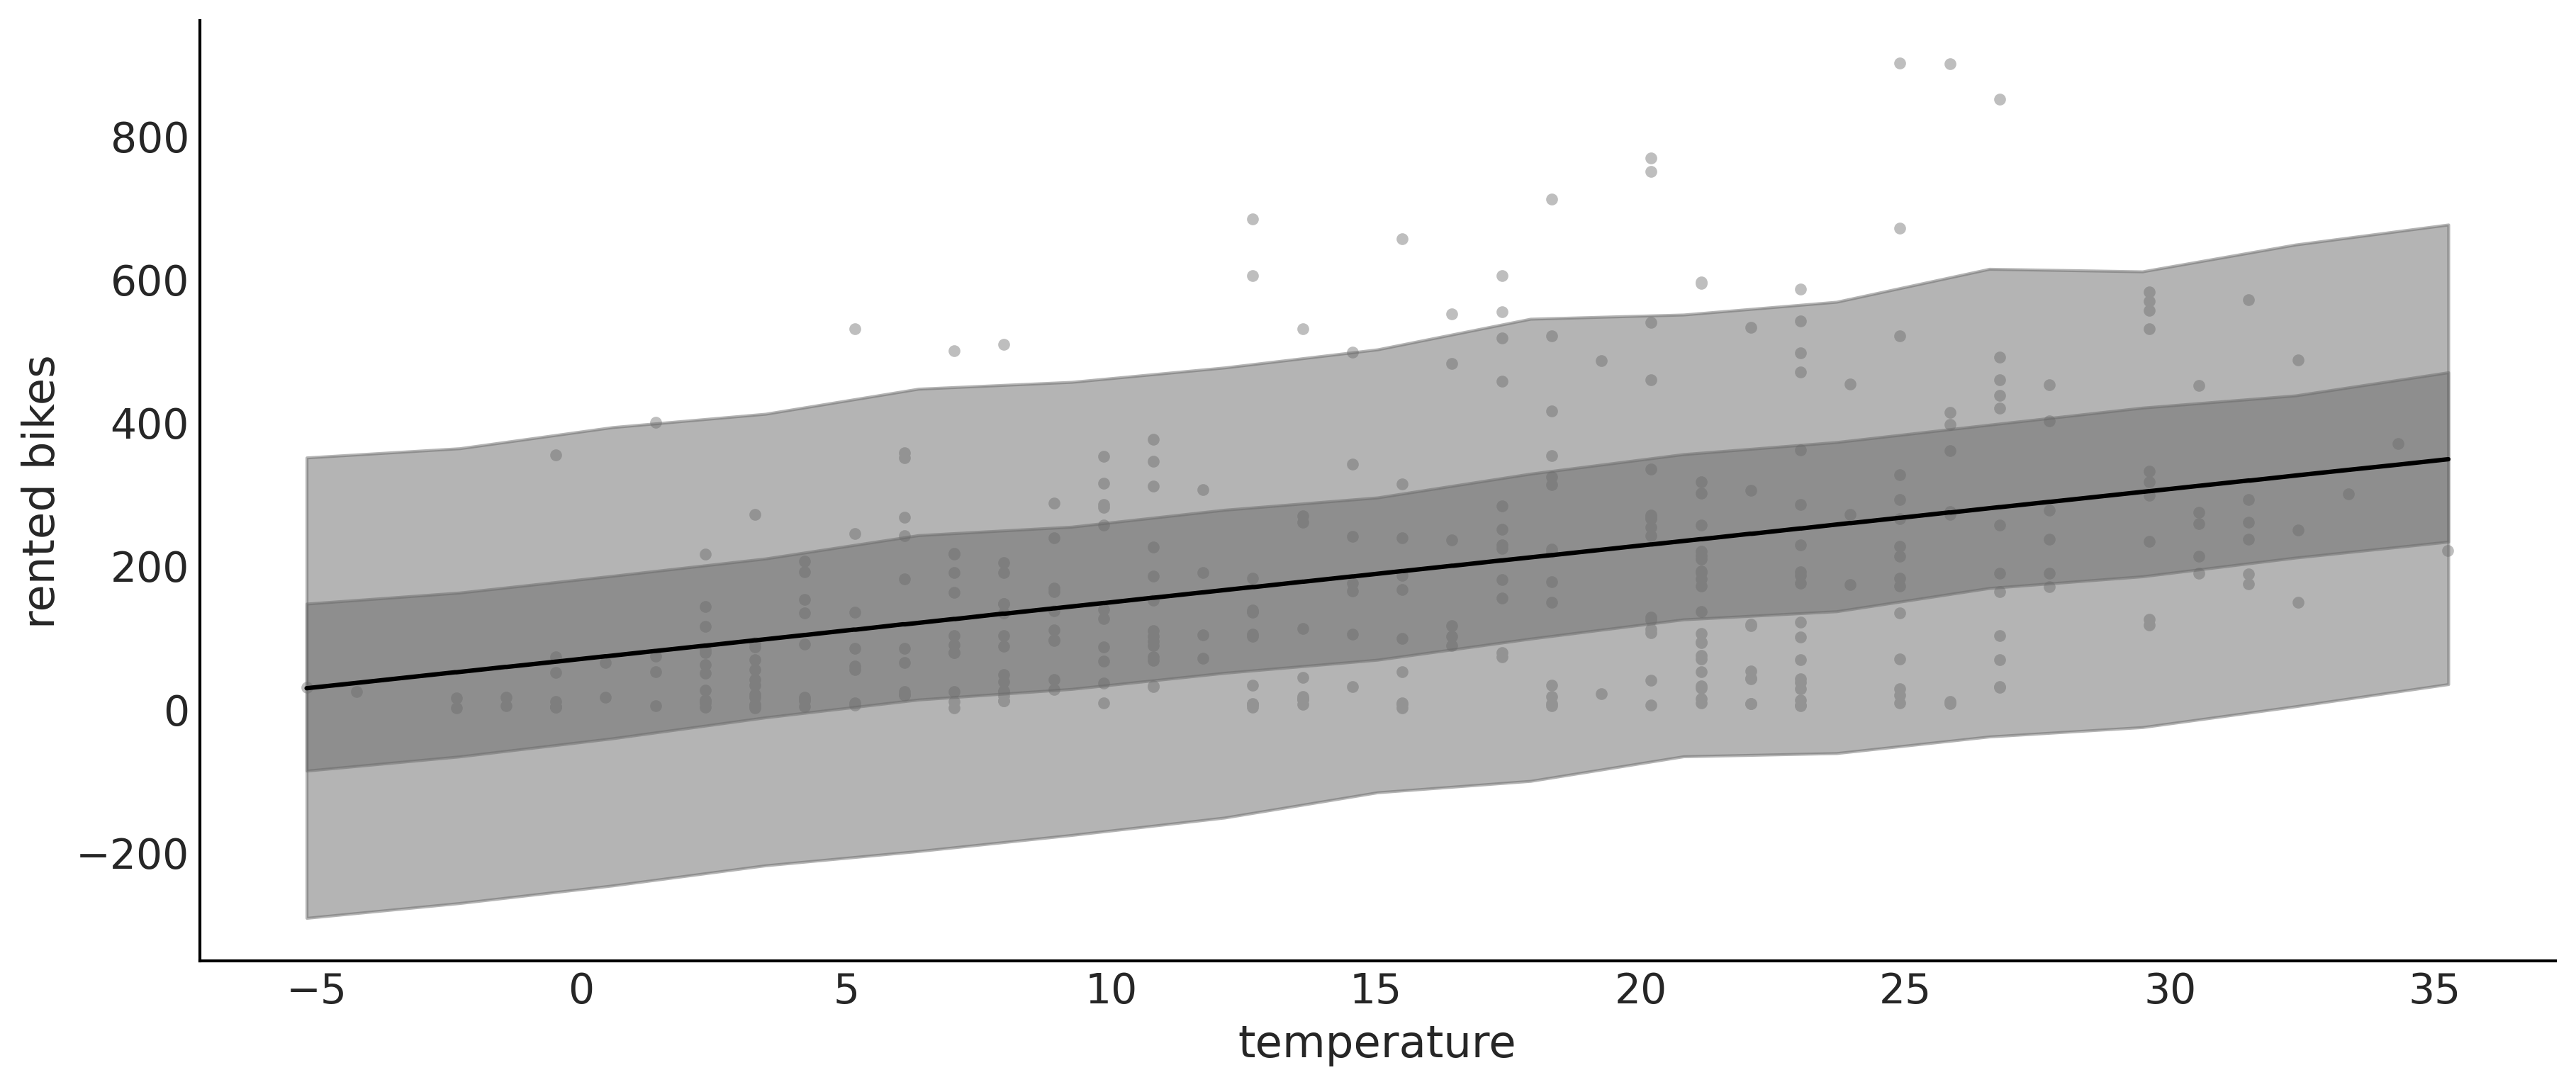

In [16]:
_, ax = plt.subplots(figsize = (12, 5))
ax.plot(bikes.temperature, bikes.rented, 'C2.', zorder=-3)
ax.plot(temperatures[idx], mean_lines[idx], color='C0')

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color='C1', alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes");


# Generalising the linear model

In [17]:
with pm.Model() as model_neg:
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta = pm.Normal('beta', mu = 0, sigma = 10)
    sigma = pm.HalfNormal('sigma', 10)
    mu = pm.Deterministic('mu', pm.math.exp(alpha + beta * bikes.temperature))
    y_pred = pm.NegativeBinomial('y_pred', mu = mu, alpha = sigma, observed = bikes.rented)
    idata_neg = pm.sample()
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [y_pred]


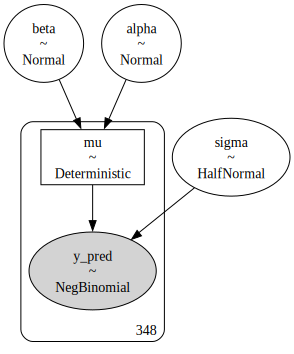

In [18]:
pm.model_to_graphviz(model_neg)

In [19]:
idata_neg

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

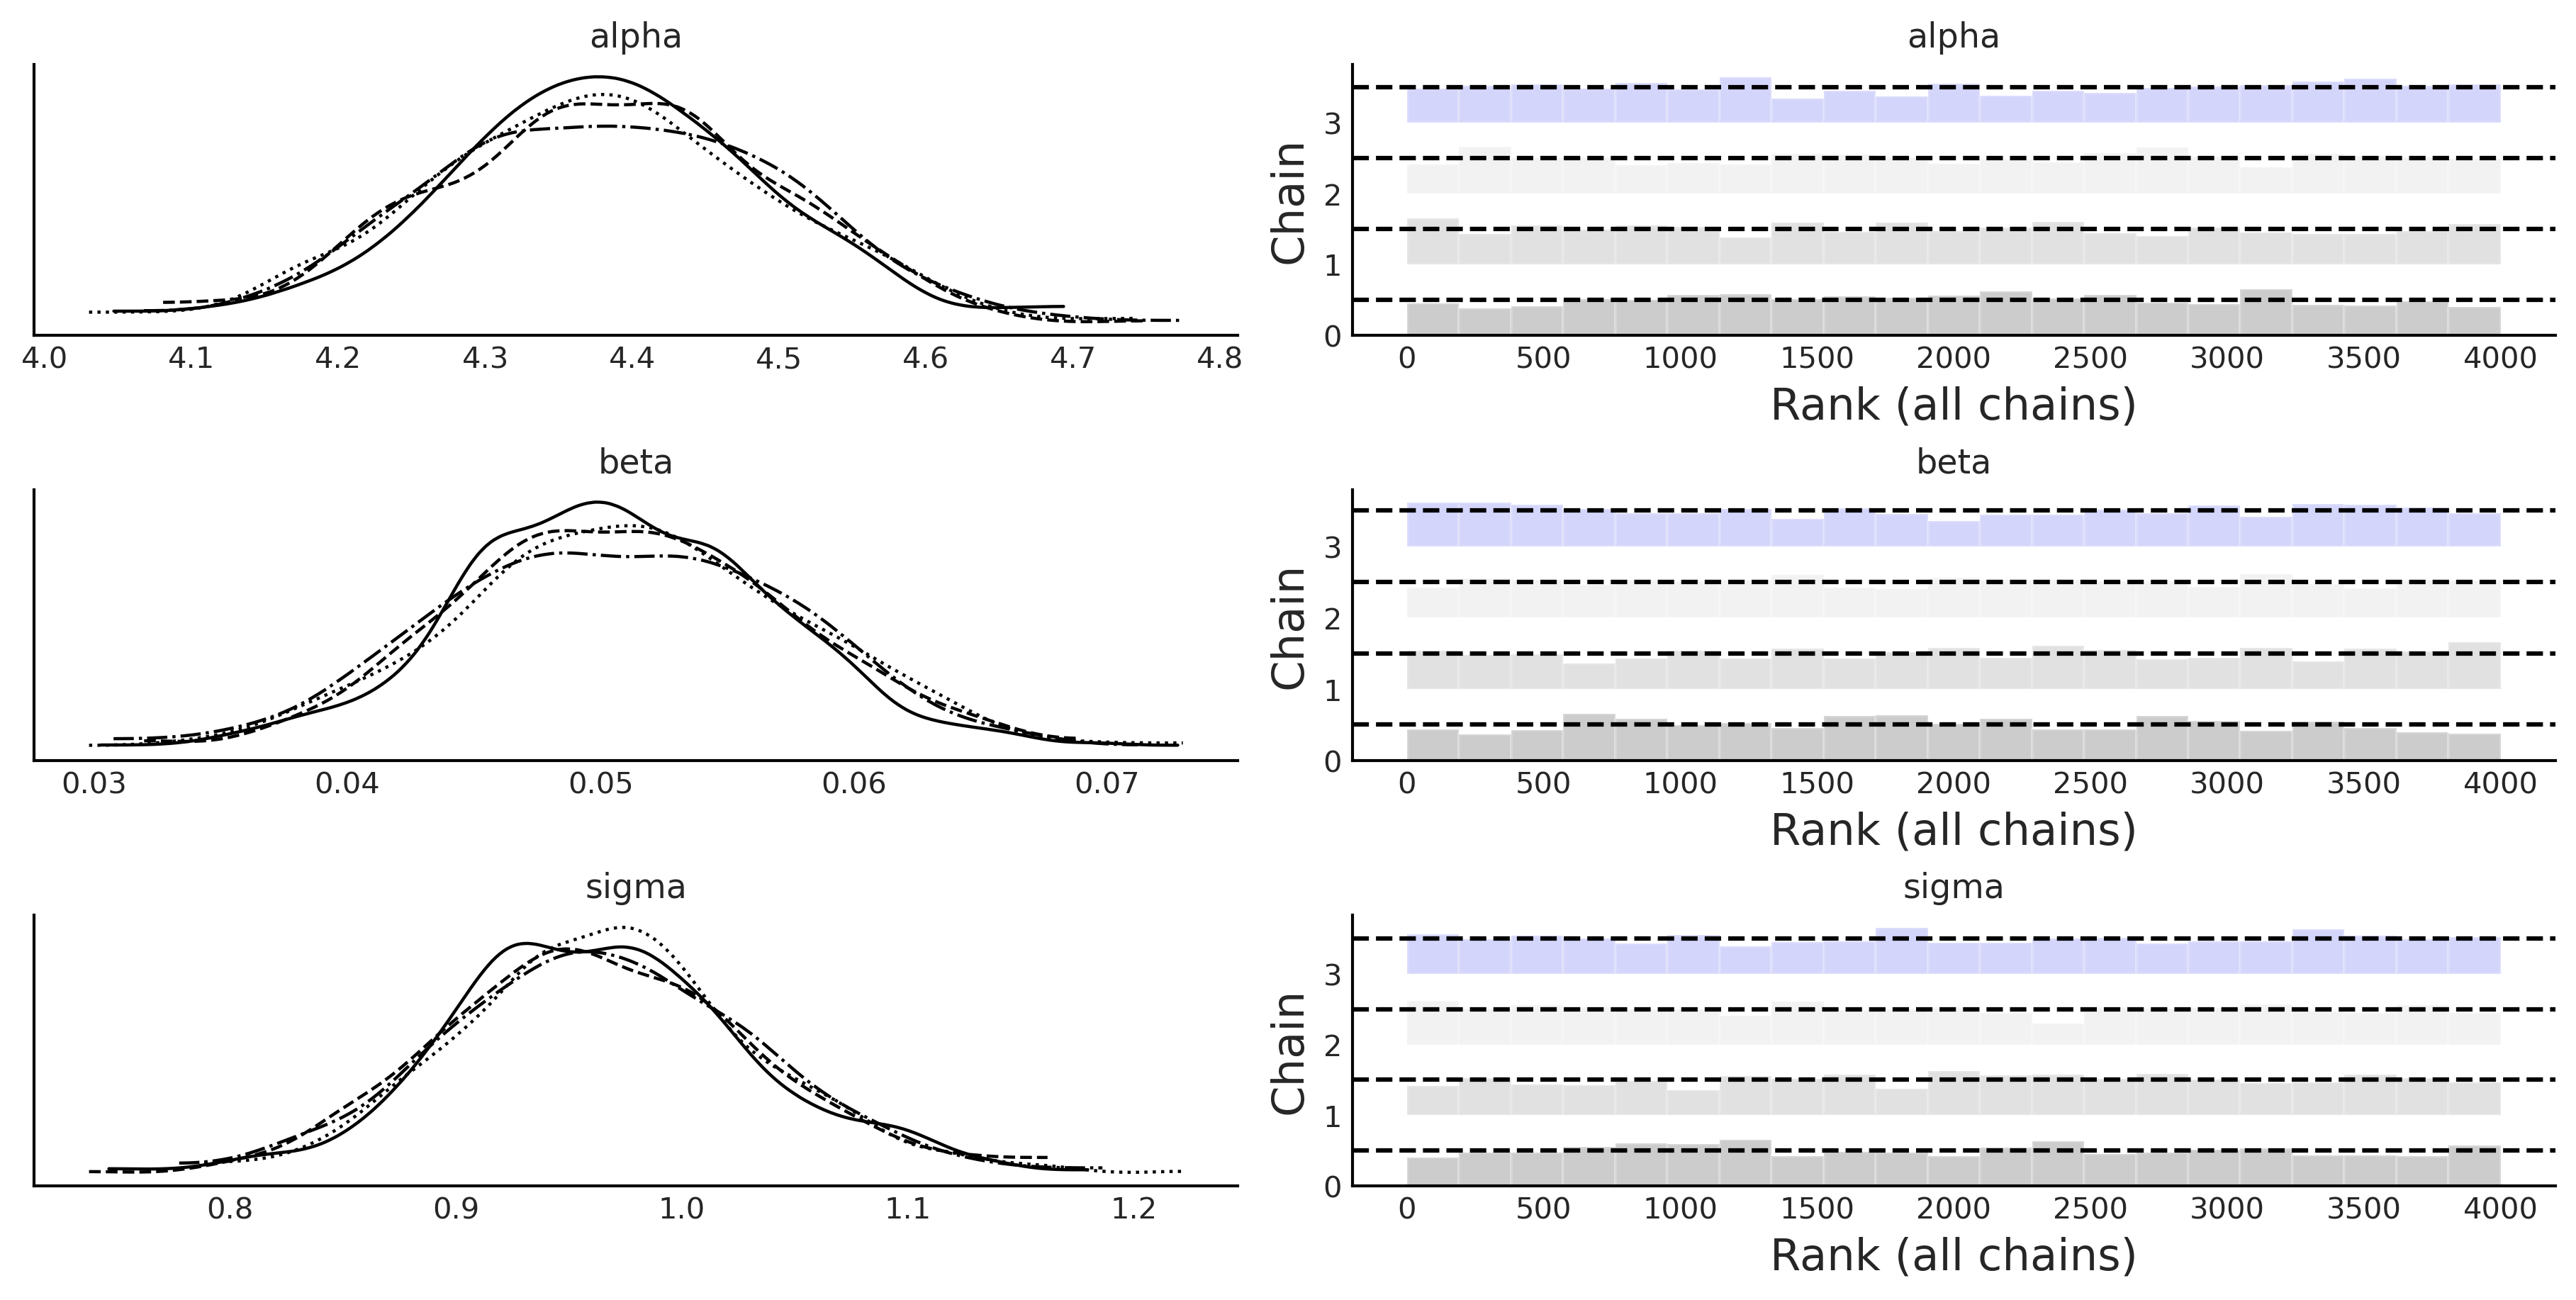

In [20]:
az.plot_trace(idata_neg, var_names = ["~mu"], kind = "rank_bars");

In [21]:
idata_neg

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

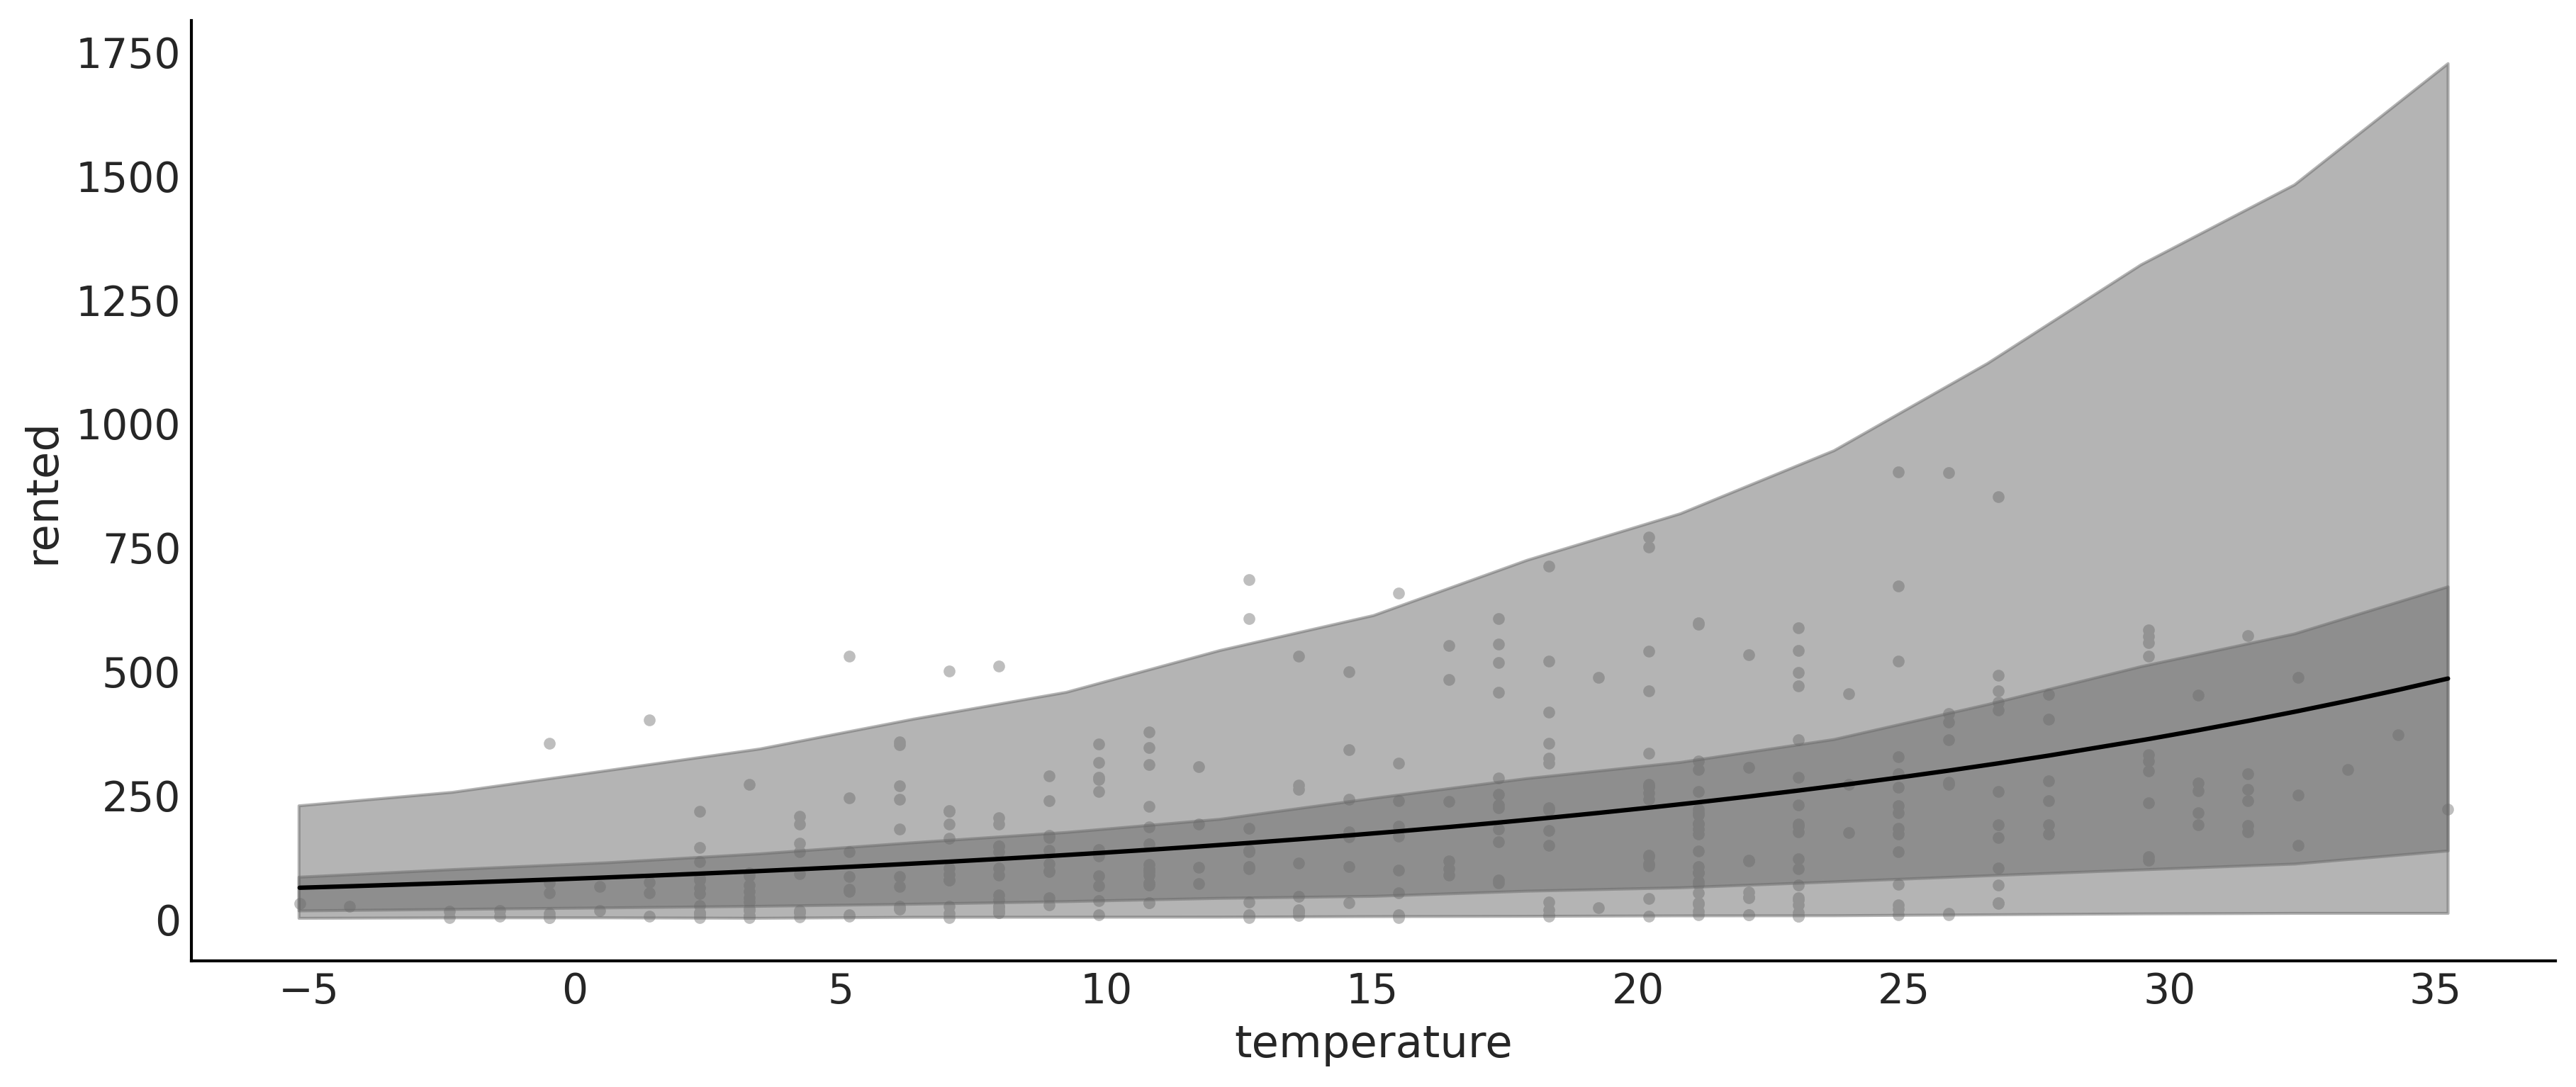

In [22]:
mean_line = idata_neg.posterior['mu'].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_neg.posterior_predictive['y_pred'].quantile(
    [0.03, 0.97, 0.25, 0.75], dim = ["chain", "draw"])
y_pred_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x) for
        i in range(4)
    ]
)

_, ax = plt.subplots(figsize = (12, 5))
ax.plot(bikes.temperature, bikes.rented, 'C2.', zorder = -3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_pred_hat_bounds, y_pred_hat_bounds):
    ax.fill_between(x, lb, ub, color='C1', alpha = 0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented");

## Posterior predictive check

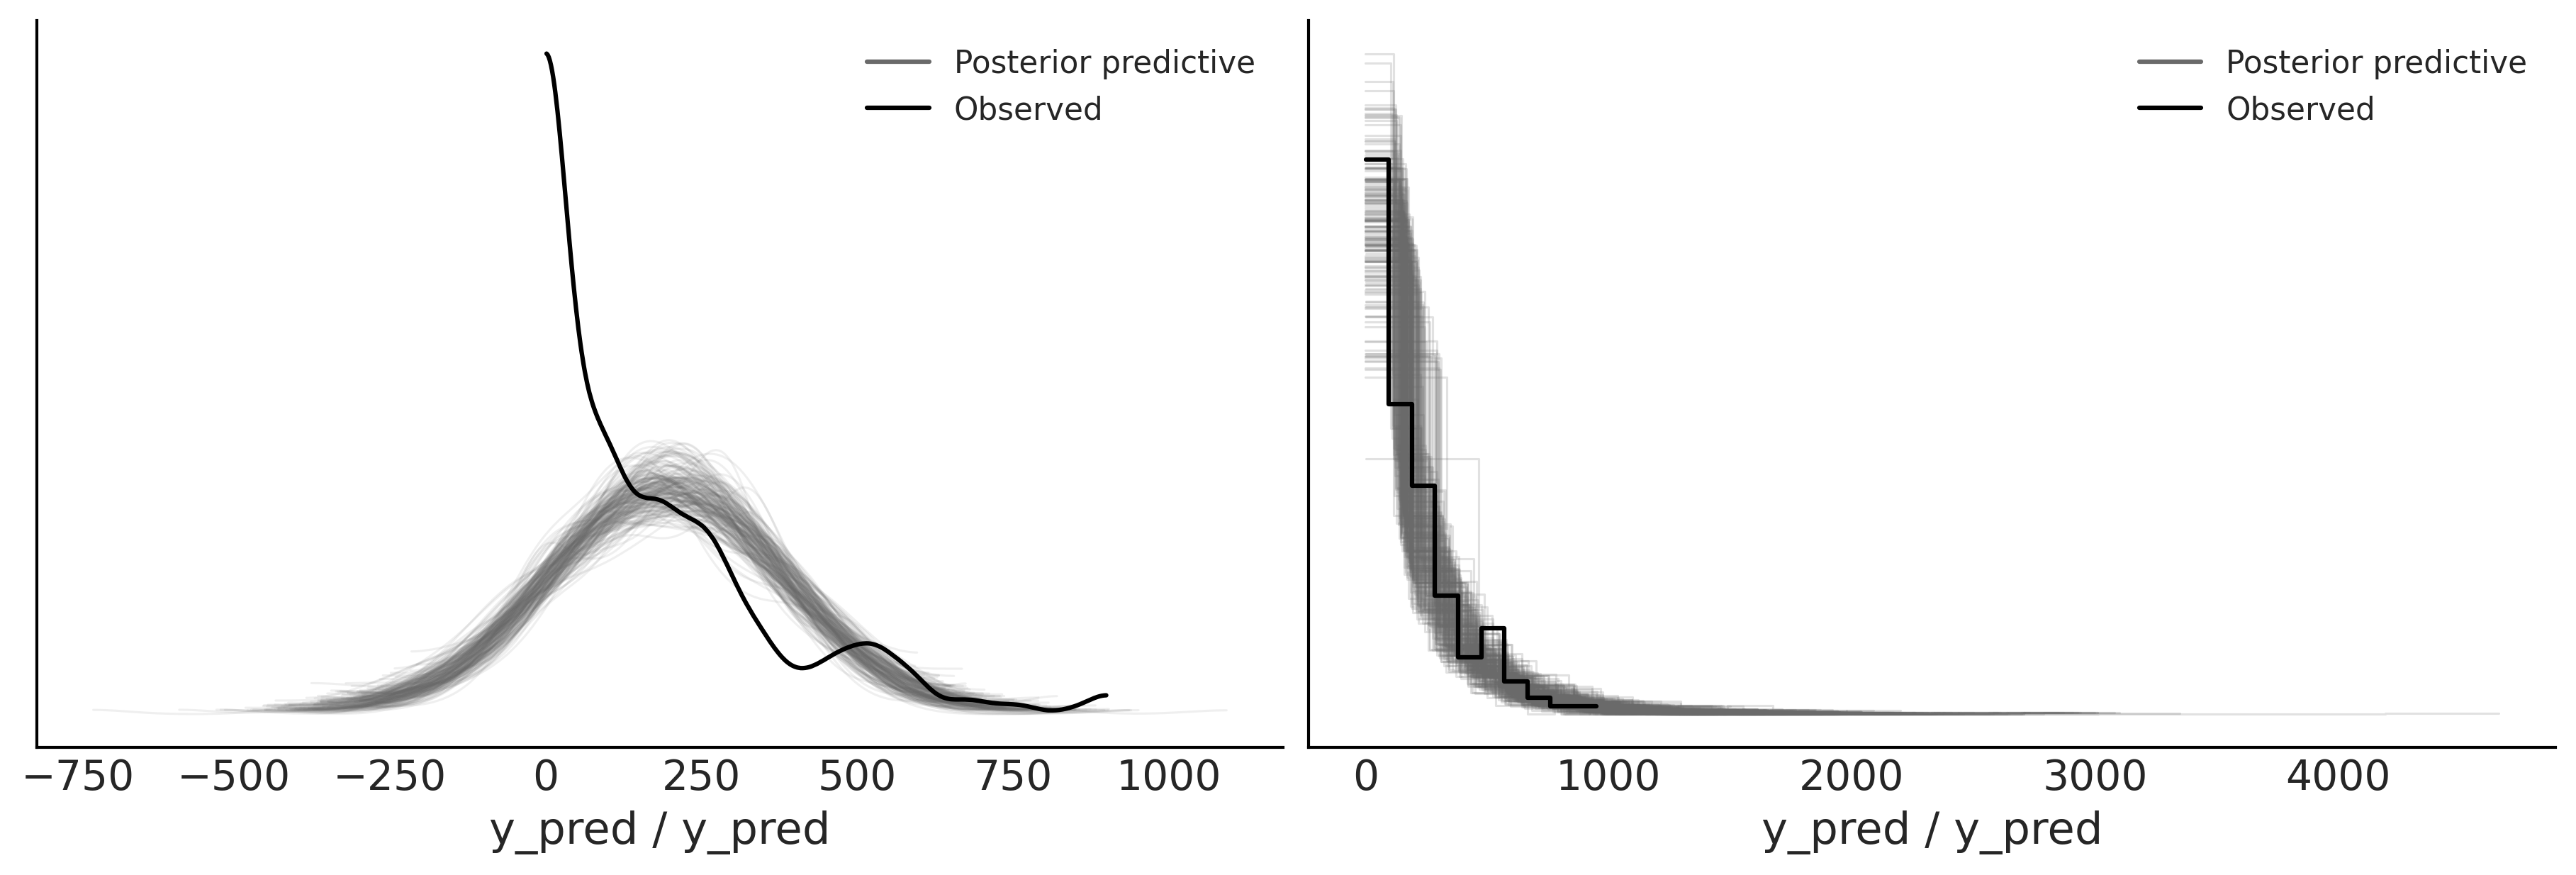

In [23]:
_, ax = plt.subplots(1, 2, figsize = (12, 4))
az.plot_ppc(
    idata_lb, 
    num_pp_samples=200, 
    alpha=0.1,
    colors = ["C1", "C0", "C0"],
    ax = ax[0],
    mean = False
       )
az.plot_ppc(
    idata_neg,
    num_pp_samples=200,
    colors = ["C1", "C0", "C0"],
    ax = ax[1],
    mean = False
);

# Robust Regression

Dealing with the effect of outliers for regression

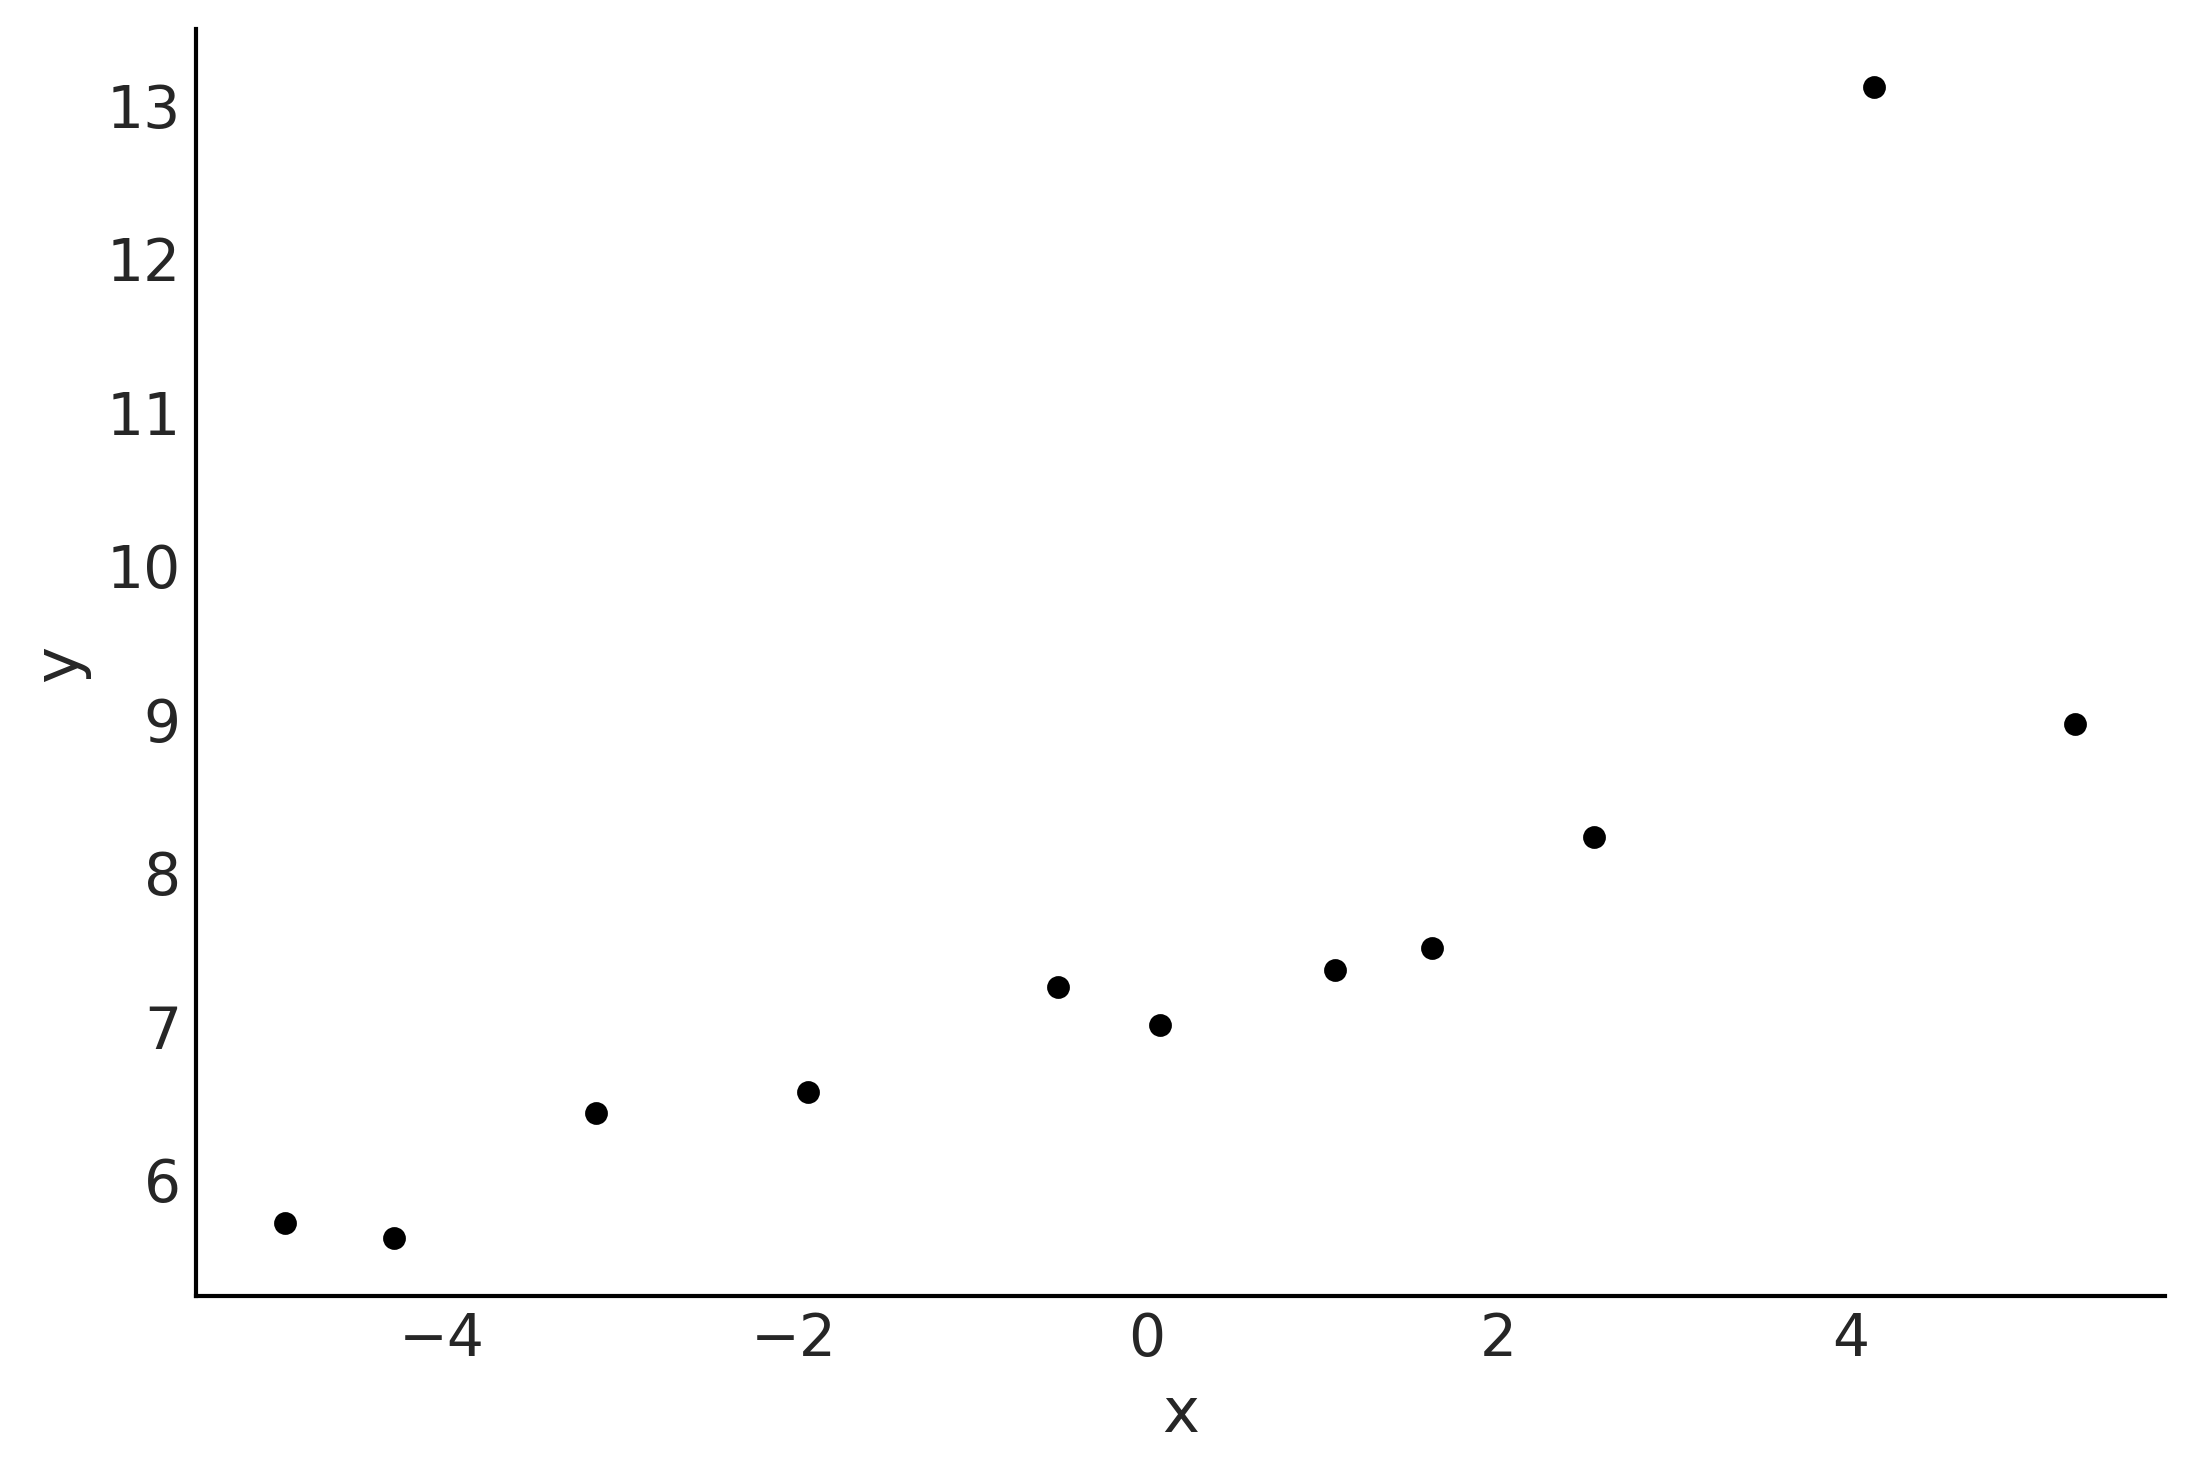

In [24]:
ans = pd.read_csv("../code/data/anscombe_3.csv")
ans.plot("x", "y", kind="scatter");

- Use a shifted exponential to avoid values close to 0

In [25]:
with pm.Model() as model_t:
    alpha = pm.Normal("alpha", mu = ans.y.mean(), sigma = 1)
    beta = pm.Normal("beta", mu = 0, sigma = 1)
    sigma = pm.HalfNormal("sigma", 5)
    nu_ = pm.Exponential("nu_", 1/29)
    nu = pm.Deterministic("nu", nu_ + 1)
    mu = pm.Deterministic("mu", alpha + beta * ans.x)
    _ = pm.StudentT("y_pred", mu = mu, sigma = sigma, nu = nu, observed = ans.y)
    idata_t = pm.sample(2000, random_seed=4951)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu_]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


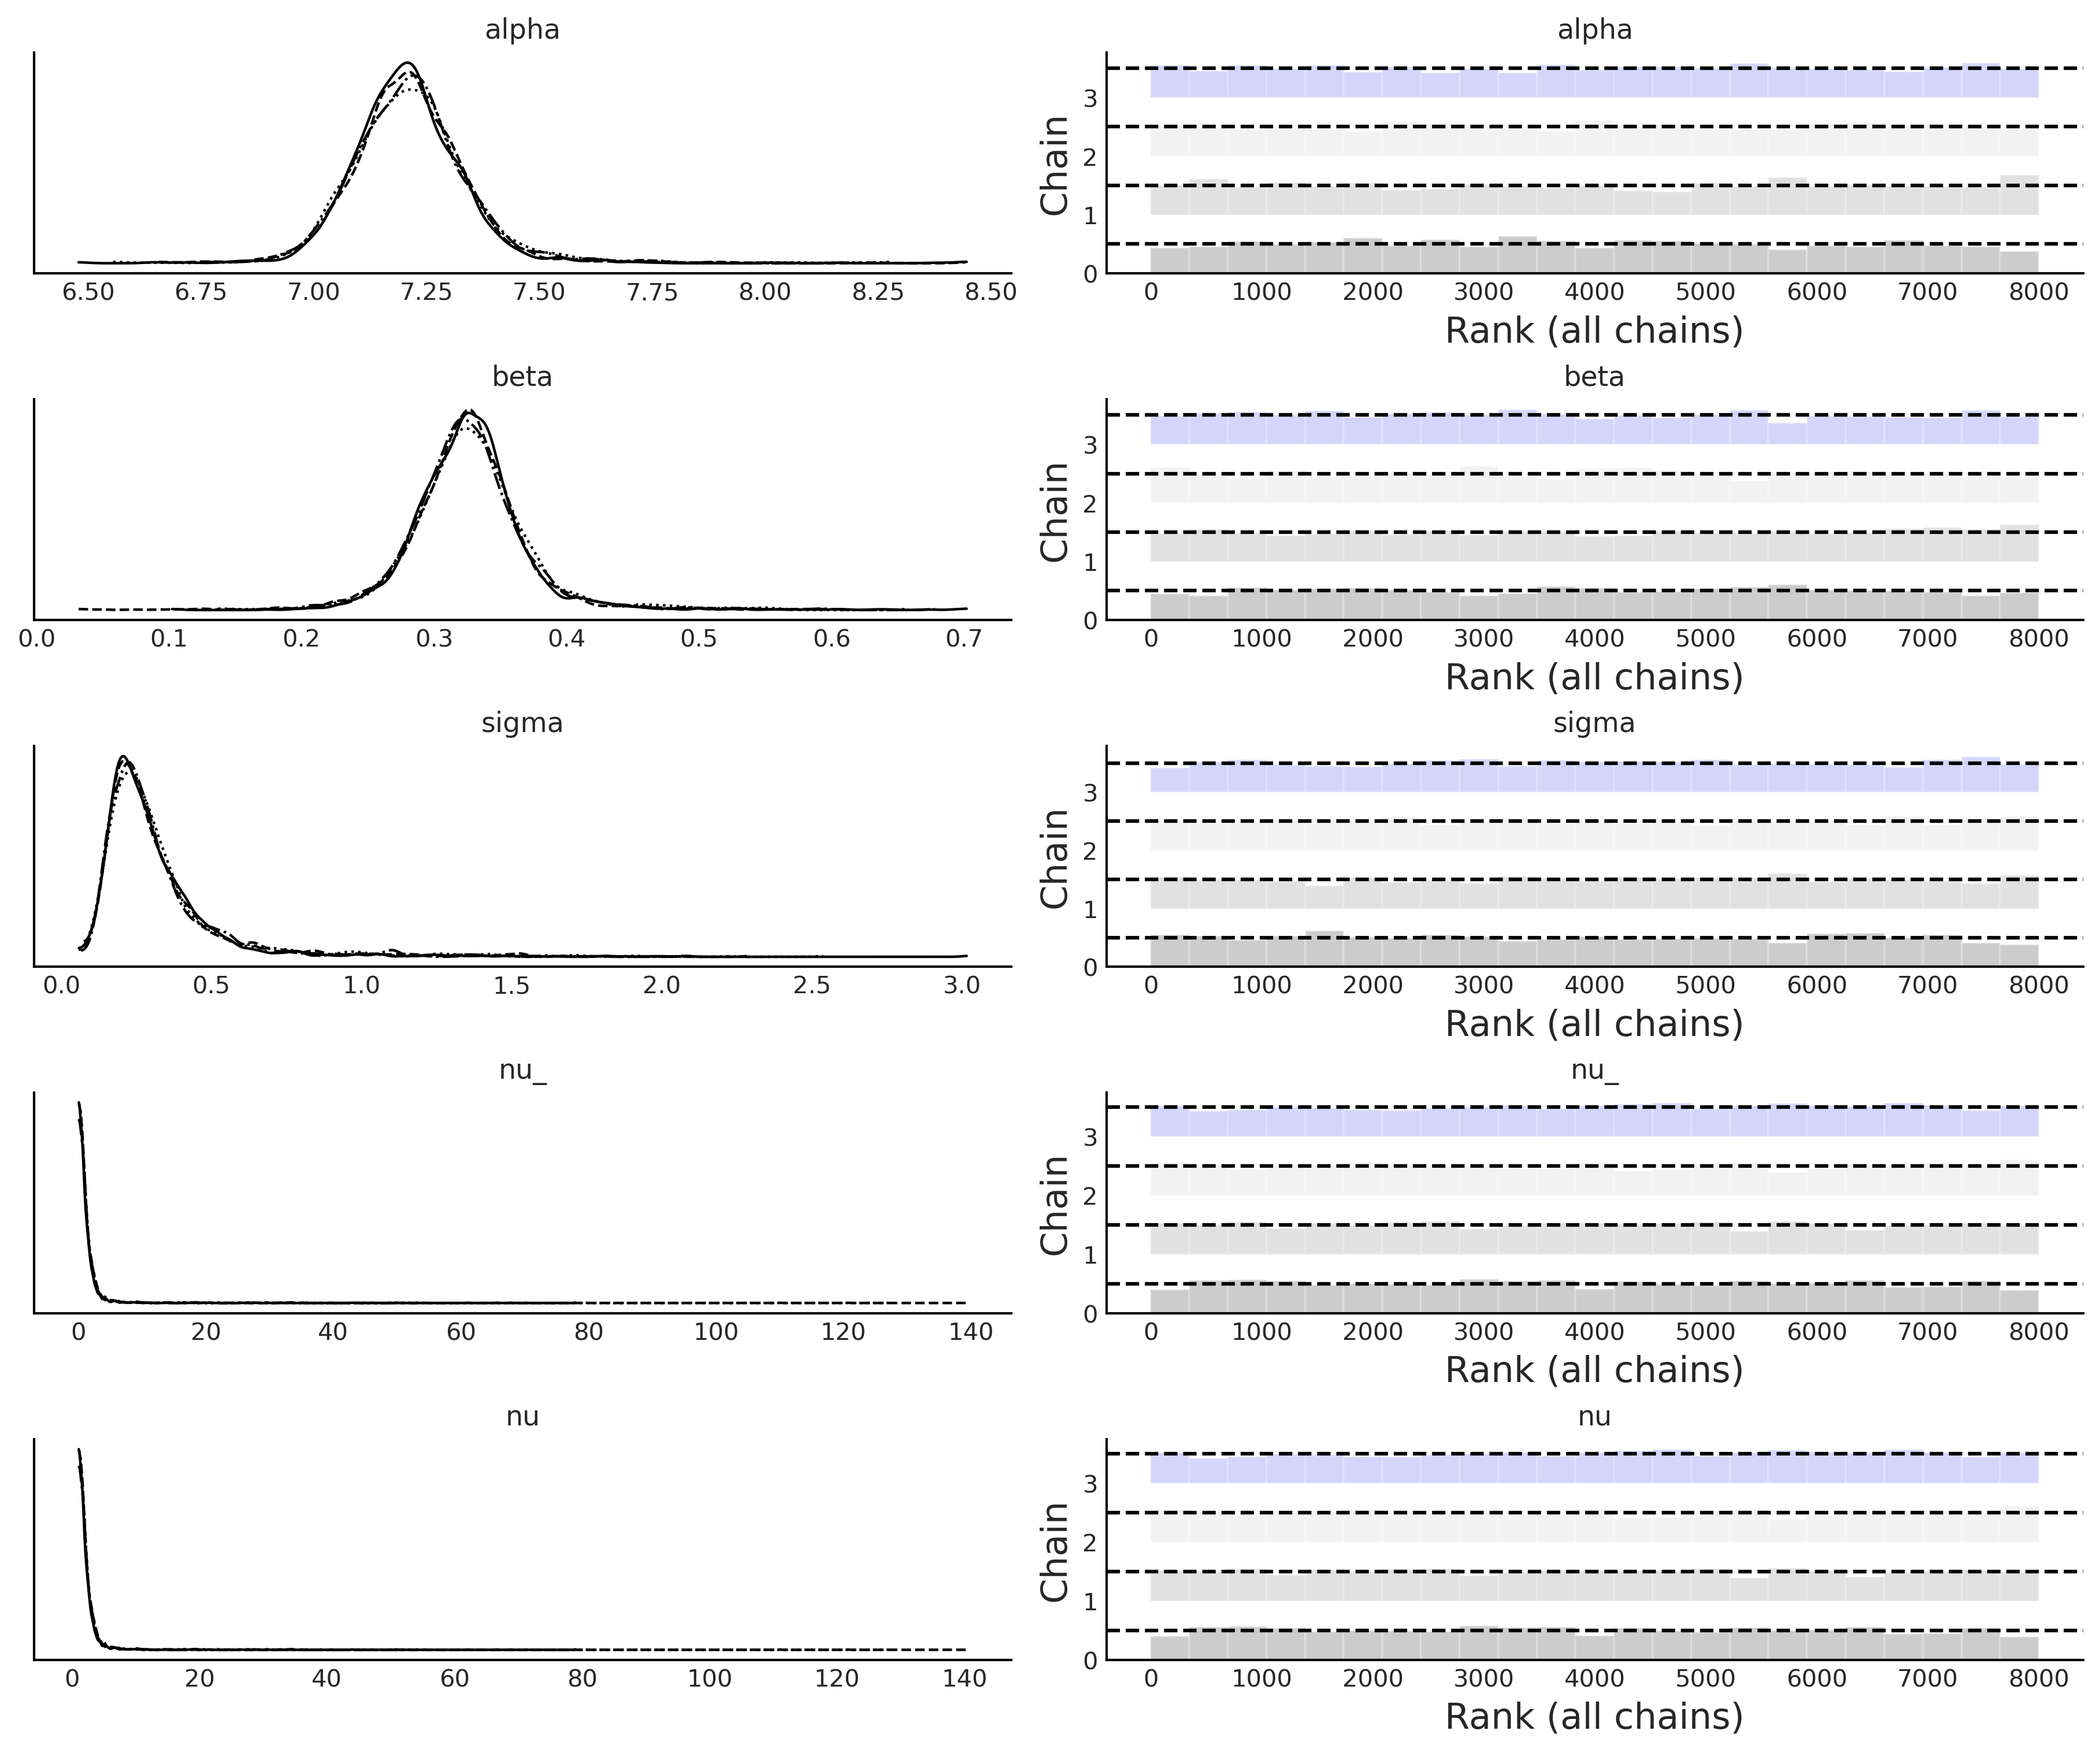

In [26]:
az.plot_trace(idata_t, var_names=["~mu"], kind = "rank_bars");

In [27]:
beta_c, alpha_c, *_ = linregress(ans.x, ans.y)

/home/mrosinski/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


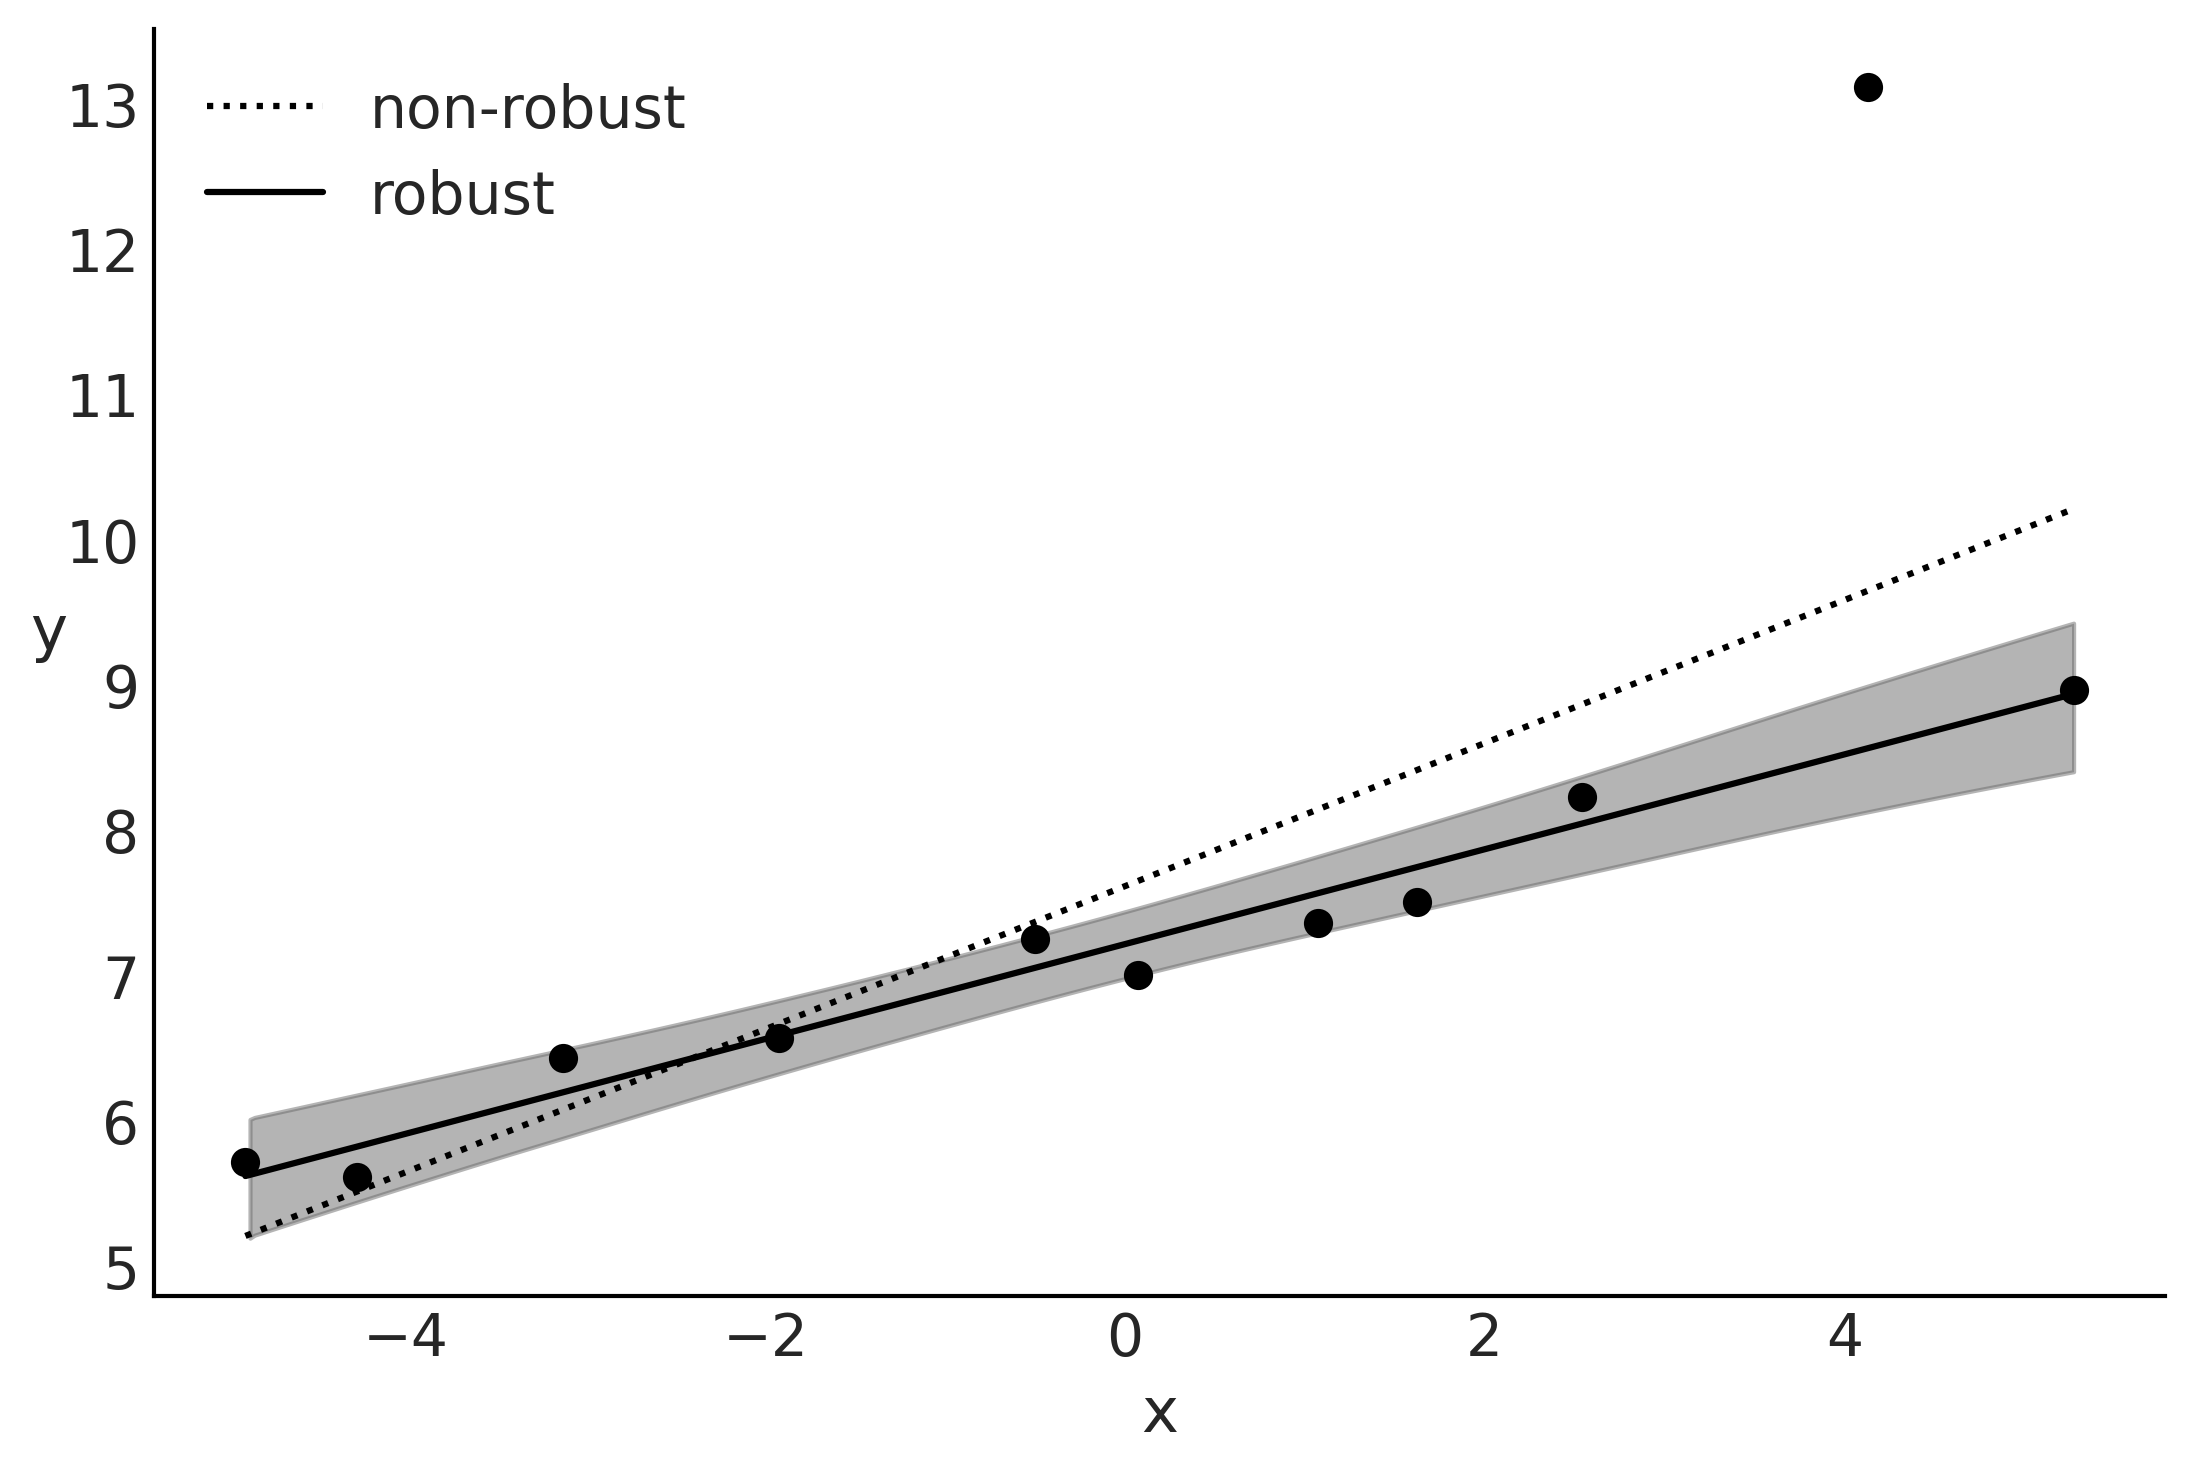

In [28]:
_, ax = plt.subplots()
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label = "non-robust")
ax.plot(ans.x, ans.y, "C0o")
alpha_m = idata_t.posterior["alpha"].mean(("chain", "draw"))
beta_m = idata_t.posterior['beta'].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(ans.x.min(), ans.x.max(), 50), dims = "plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c="C0", label = "robust")
az.plot_hdi(ans.x, az.hdi(idata_t.posterior["mu"])["mu"].T, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.legend(loc=2);

In [29]:
az.summary(idata_t, var_names=["~mu"], round_to=2, kind="stats")

mean    sd  hdi_3%  hdi_97%
alpha  7.21  0.13    6.98     7.43
beta   0.33  0.04    0.25     0.40
sigma  0.32  0.22    0.10     0.65
nu_    1.60  4.89    0.00     3.44
nu     2.60  4.89    1.00     4.44

Sampling: [y_pred]


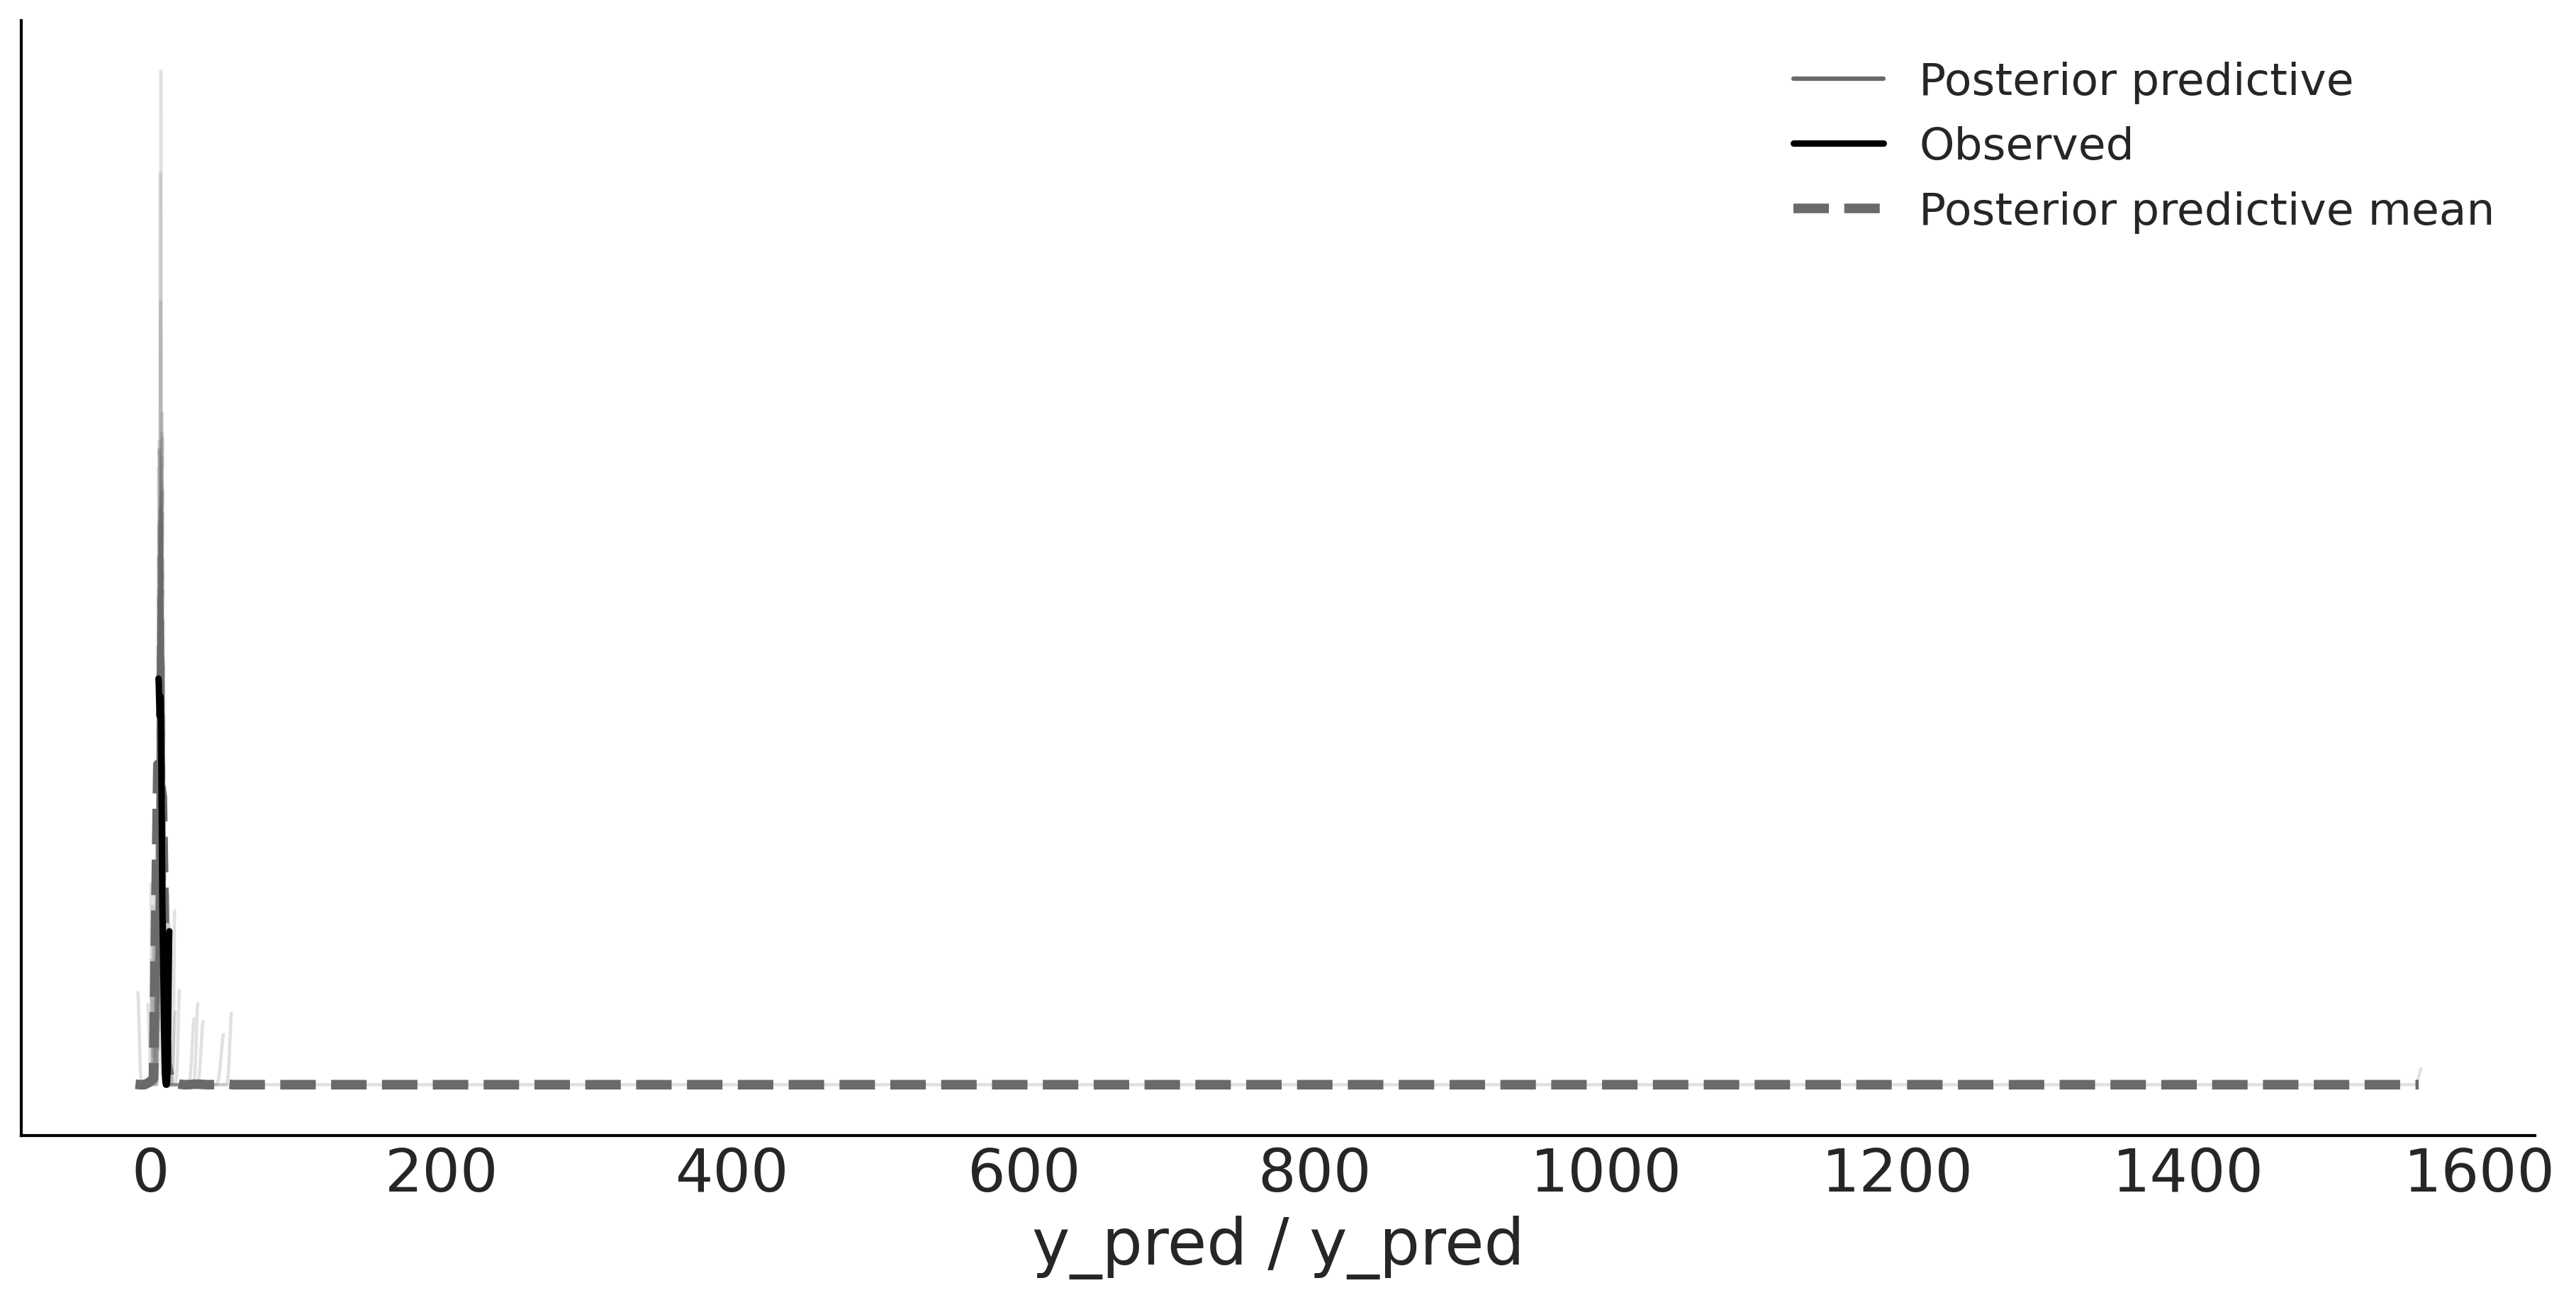

In [30]:
pm.sample_posterior_predictive(idata_t, model=model_t, random_seed=2, extend_inferencedata=True)
ax = az.plot_ppc(idata_t, num_pp_samples=200, figsize=(12, 6),  colors=["C1", "C0", "C1"])

# Logistic regression

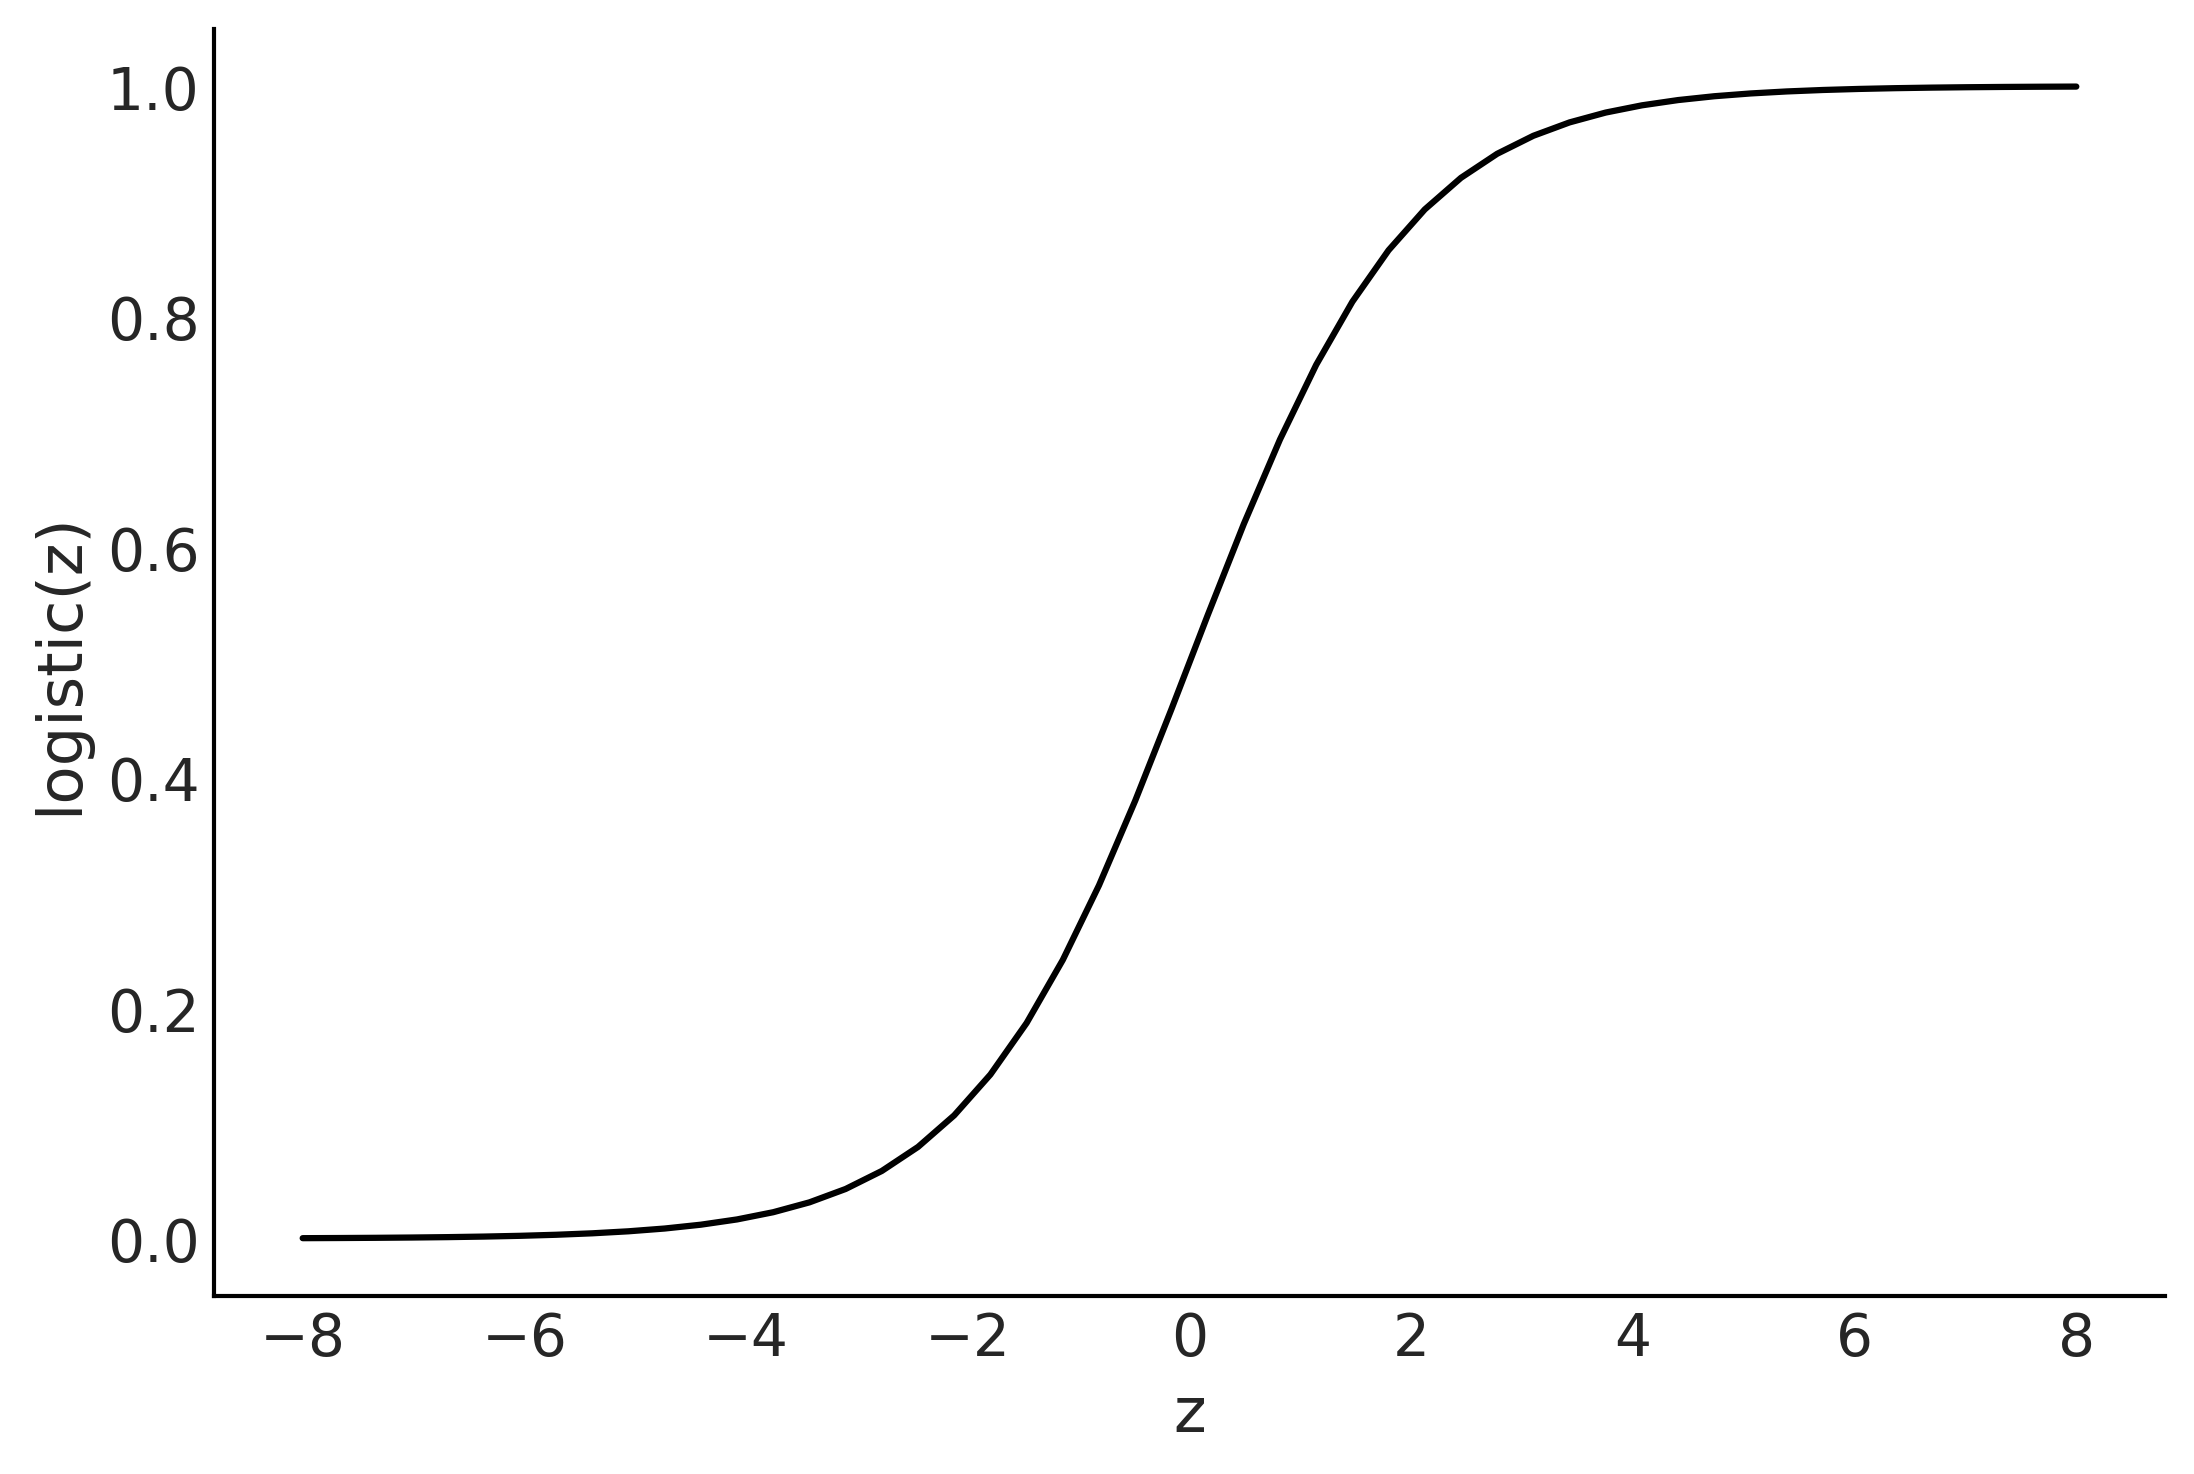

In [31]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel("z")
plt.ylabel("logistic(z)");

In [32]:
iris = pd.read_csv("../code/data/iris.csv")
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [33]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [34]:
with pm.Model() as model_lrs:
    alpha = pm.Normal("mu", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    mu = alpha + beta * x_c
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -alpha/beta)  # Boundary decision
    y1 = pm.Bernoulli("y1", p=theta, observed=y_0)
    
    idata_lrs = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [35]:
# help(pm.Normal)

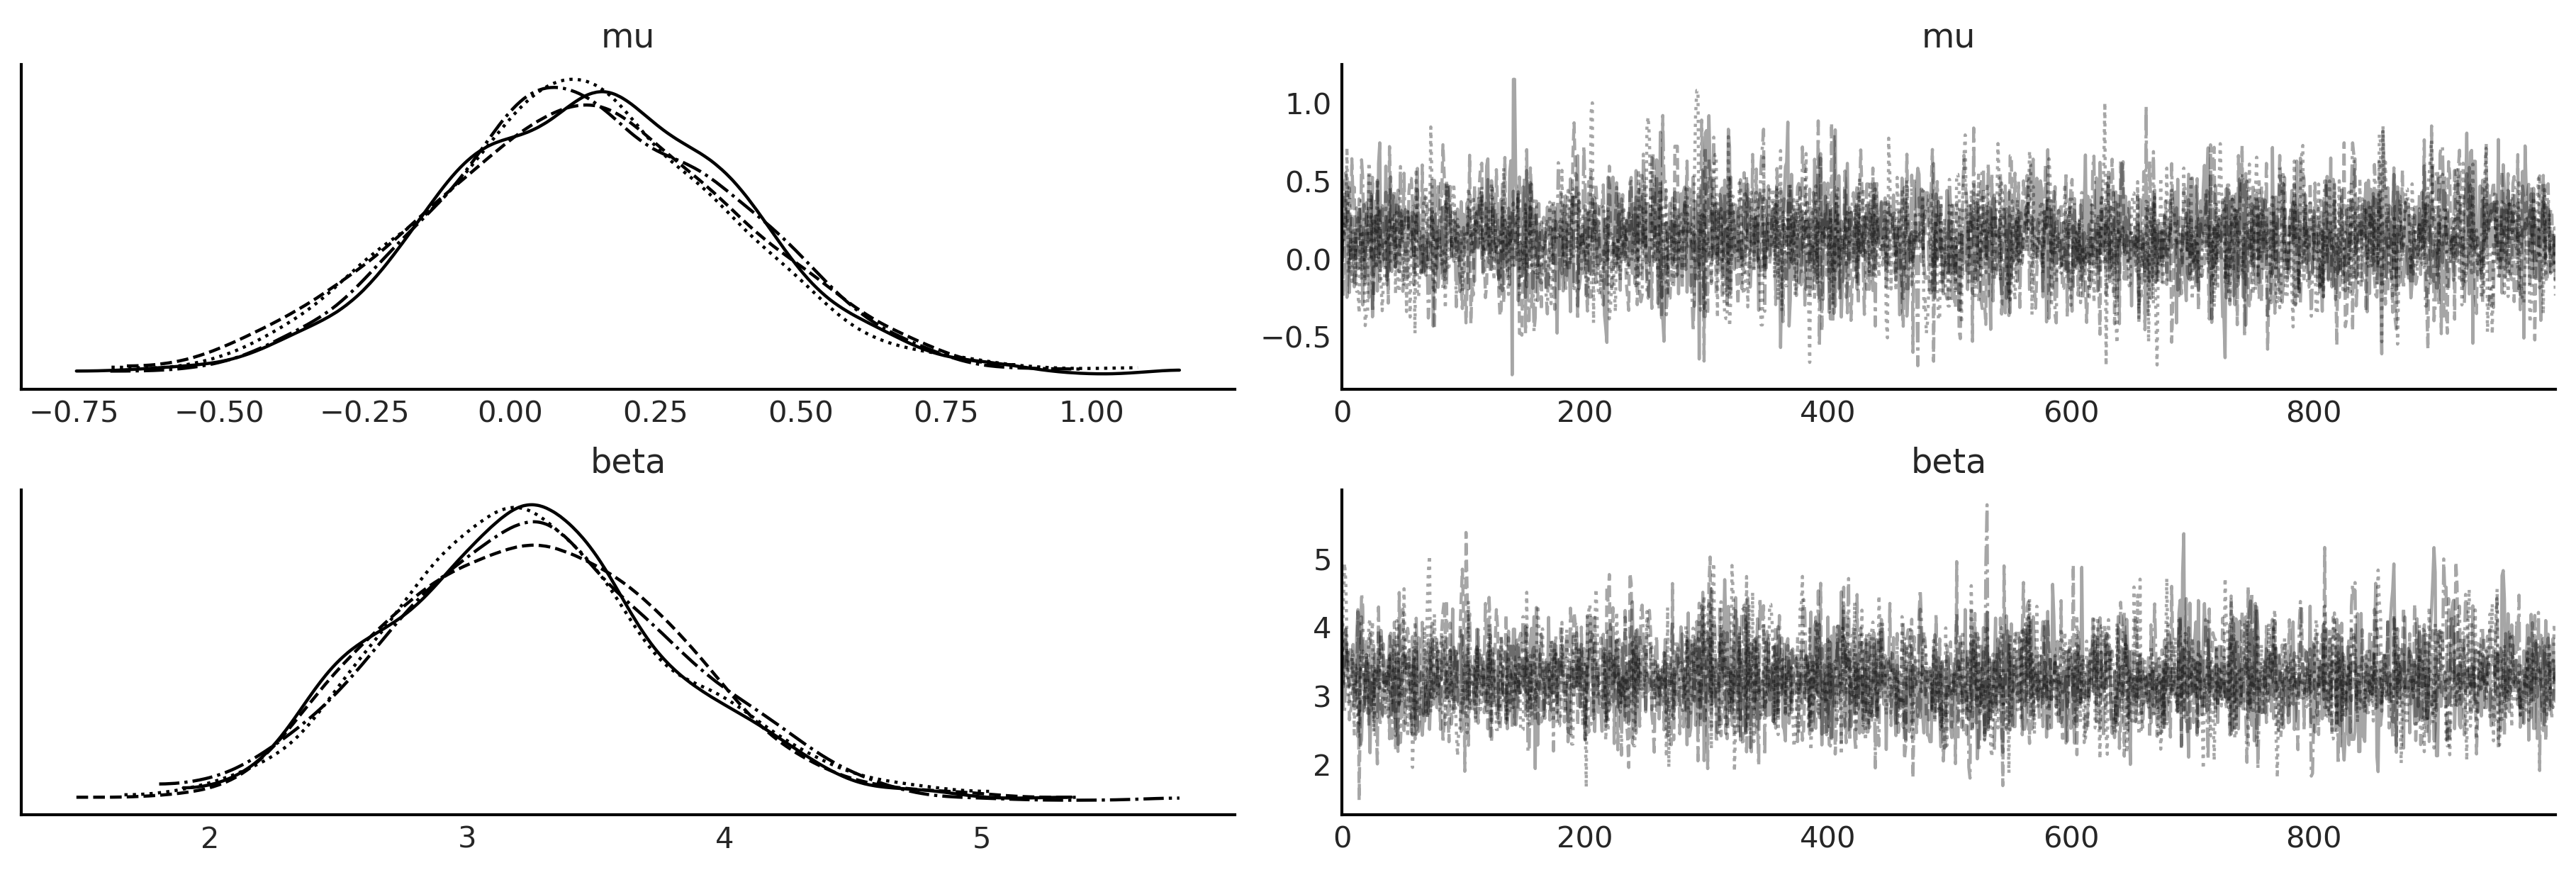

In [36]:
az.plot_trace(idata_lrs,var_names=("~theta", "~bd"));

In [37]:
# [f"C{x}" for x in y_0]

# Logistic regression
- Probability of being veriscolor (theta) or setosa (1 - theta).  The sigmoid curve is the probability of a flower being versicolor, given that we know the value of the sepal length.
- The semitransparent s-shaped band is the 94% HDI
- The vertical line is the decision boundary where the probability of being versicolor is 0.5.  This is -alpha/beta.
- The uncertainty in alpha and beta lead to the vertical shaded region where we are uncertain of the class for sepal lengths in this range.

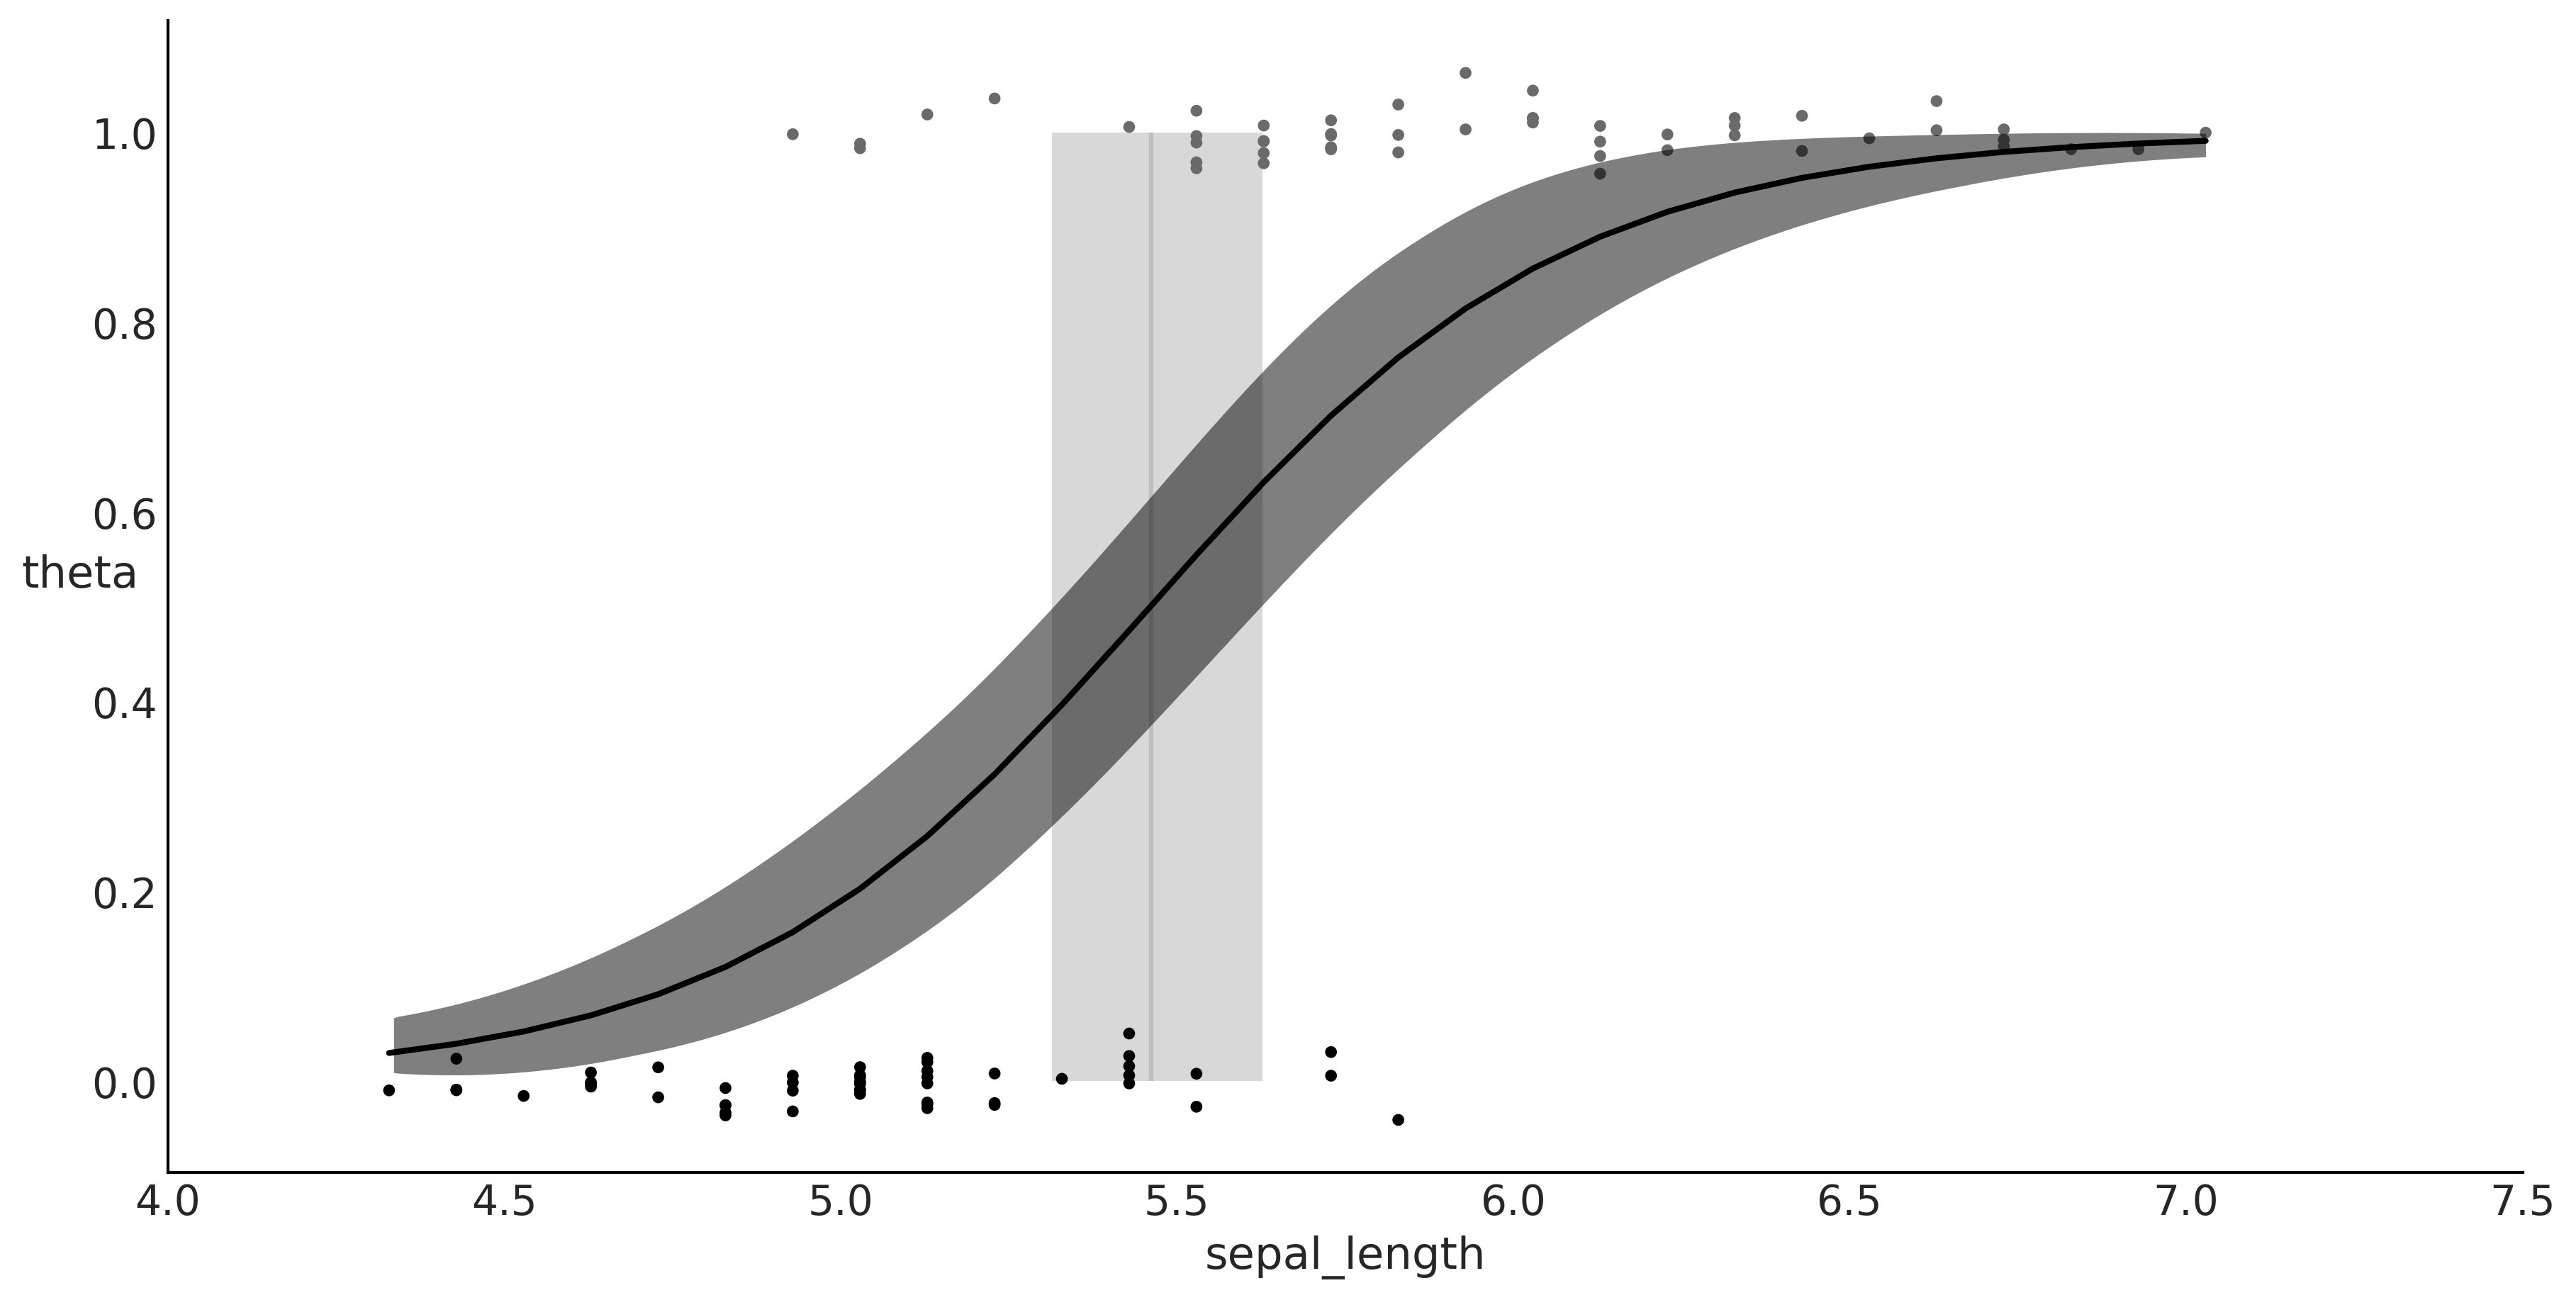

In [38]:
posterior = idata_lrs.posterior
theta = posterior['theta'].mean(('chain', 'draw'))
idx = np.argsort(x_c)

_, ax = plt.subplots(figsize = (12,6))
ax.plot(x_c[idx], theta[idx], c='C0', lw=2)
ax.vlines(posterior['bd'].mean(('chain', 'draw')), ymin=0, ymax=1, color = "C2", zorder=0)
bd_hdi = az.hdi(posterior['bd'])
ax.fill_betweenx([0, 1], bd_hdi['bd'][0], bd_hdi['bd'][1], color = "C2", alpha=0.6, lw=0)
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])
az.plot_hdi(x_c, posterior['theta'], color = "C0", ax=ax, fill_kwargs={"lw":0})
ax.set_xlabel(x_n)
ax.set_ylabel("theta", rotation = 0)
# use original scale for x ticks
locs, _ = plt.xticks()
ax.set_xticks(locs, np.round(locs + x_0.mean(), 1));

In [39]:
# help(az.hdi)

In [40]:
import plotnine as p9
import pandas as pd
import numpy as np

In [41]:
# y_0

In [42]:
# Preparing data
df = pd.DataFrame({
    'x_c': x_c[idx],
    'theta_mean': theta[idx],
    'y_0_scatter': np.random.normal(y_0, 0.02),
    'y_0_color': [f"C{x}" for x in y_0],
})
df

x_c  theta_mean  y_0_scatter y_0_color
0  -1.171    0.029546     0.009574        C0
1  -1.071    0.039289    -0.022767        C0
2  -1.071    0.039289    -0.054256        C0
3  -1.071    0.039289     0.008441        C0
4  -0.971    0.052199    -0.020572        C0
..    ...         ...          ...       ...
95  1.229    0.979437     0.986985        C1
96  1.229    0.979437     0.999260        C1
97  1.329    0.984484     0.974964        C1
98  1.429    0.988280     0.999323        C1
99  1.529    0.991137     1.000565        C1

[100 rows x 4 columns]

In [43]:
# Mean boundary and HDI for 'bd'
bd_mean = posterior['bd'].mean(('chain', 'draw')).item()
bd_hdi = az.hdi(posterior['bd'])['bd']

# HDI for theta (pre-computed)
theta_hdi = az.hdi(posterior['theta'])

hdi_lower = theta_hdi.sel(hdi='lower')['theta'].values
hdi_upper = theta_hdi.sel(hdi='higher')['theta'].values

In [44]:
df_hdi = pd.DataFrame({
    'x_c': x_c, 
    'hdi_lower': hdi_lower,
    'hdi_upper': hdi_upper,
})

df_hdi

x_c  hdi_lower  hdi_upper
0  -0.371   0.157610   0.369056
1  -0.571   0.075686   0.249685
2  -0.771   0.032112   0.164092
3  -0.871   0.017725   0.127581
4  -0.471   0.111867   0.307412
..    ...        ...        ...
95  0.229   0.578104   0.819033
96  0.229   0.578104   0.819033
97  0.729   0.847702   0.982754
98 -0.371   0.157610   0.369056
99  0.229   0.578104   0.819033

[100 rows x 3 columns]

In [45]:
tick_locs = np.linspace(min(x_c), max(x_c), num=7)  
tick_labels = [f"{label:.1f}" for label in np.round(tick_locs + x_0.mean(), 1)] # Ensure tick_labels are string representations

/tmp/ipykernel_2409/2036337700.py:22: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


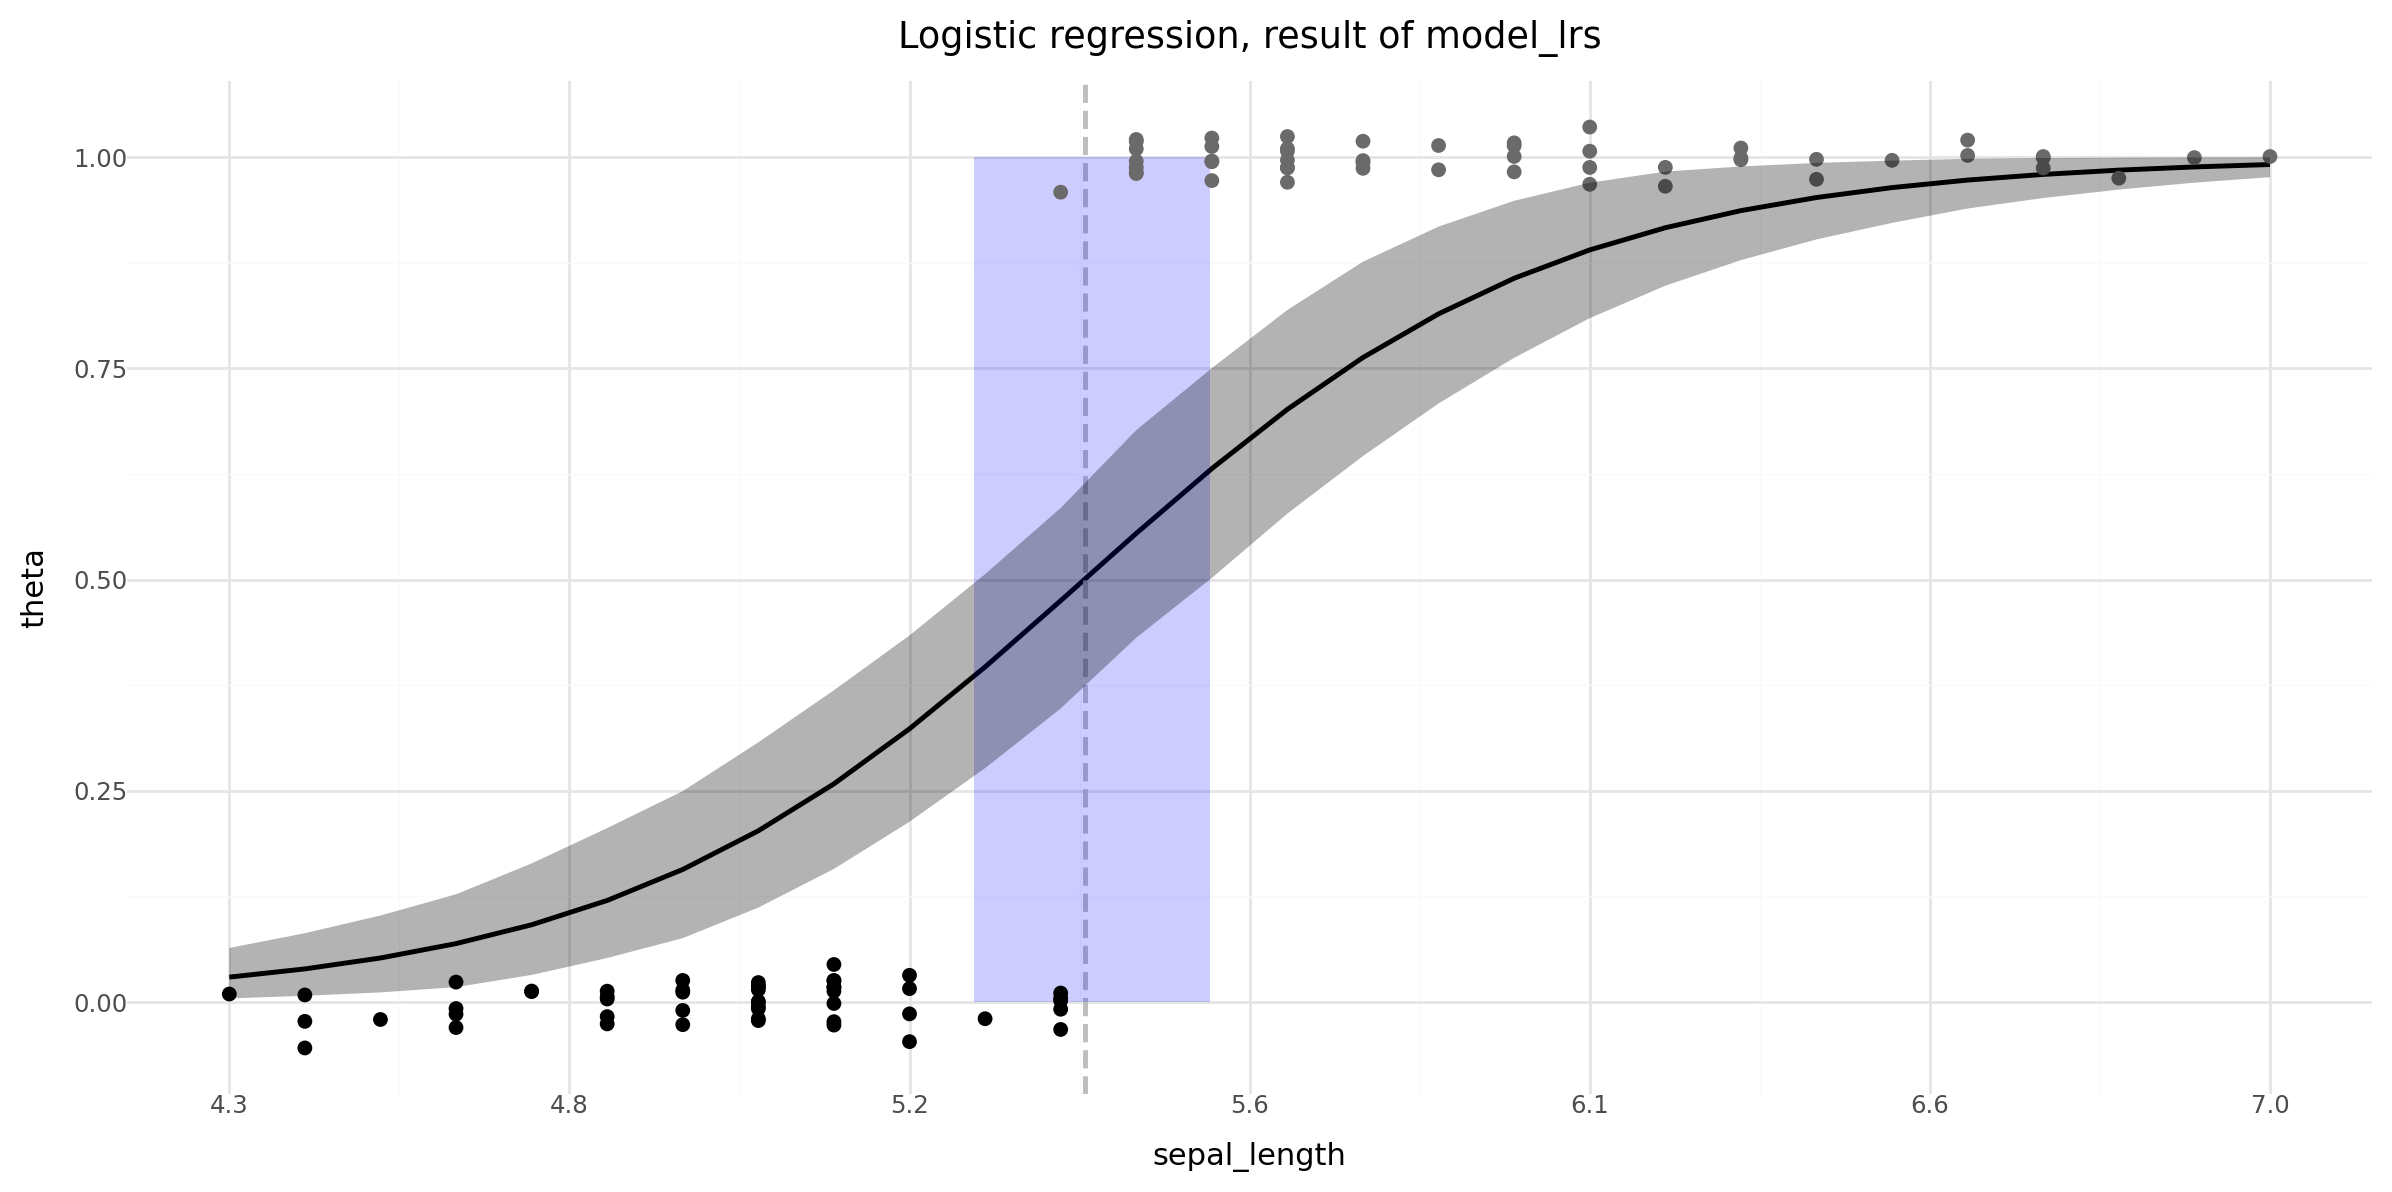

In [46]:
y_start = 0
y_end = 1

plot = (p9.ggplot() +
        p9.geom_line(p9.aes(x='x_c', y='theta_mean'), data=df, color='C0', size=1) +
        p9.geom_vline(xintercept=bd_mean, color="C2", linetype="--", size=1) +
        p9.geom_rect(p9.aes(xmin=bd_hdi[0].values.item(), 
                            xmax=bd_hdi[1].values.item(), 
                            ymin=y_start, 
                            ymax=y_end), fill="blue", alpha=0.2) +
        p9.geom_point(p9.aes(x='x_c', y='y_0_scatter', color='y_0_color'), data=df, size=2) +
        p9.geom_ribbon(p9.aes(x='x_c', ymin='hdi_lower', ymax='hdi_upper'), data=df_hdi, fill="C0", alpha=0.3) +
        p9.scale_x_continuous(breaks=tick_locs, labels=tick_labels) +  # Convert to orginal scale
        p9.labs(title = "Logistic regression, result of model_lrs", 
                x=x_n, 
                y="theta") +
        p9.scale_color_manual(values=[f"C{x}" for x in range(len(set(y_0)))]) +
        p9.theme_minimal() +
        p9.theme(legend_position='none', figure_size = (12, 6))
       )

print(plot);

/tmp/ipykernel_2409/1296991566.py:2: RuntimeWarning: divide by zero encountered in divide


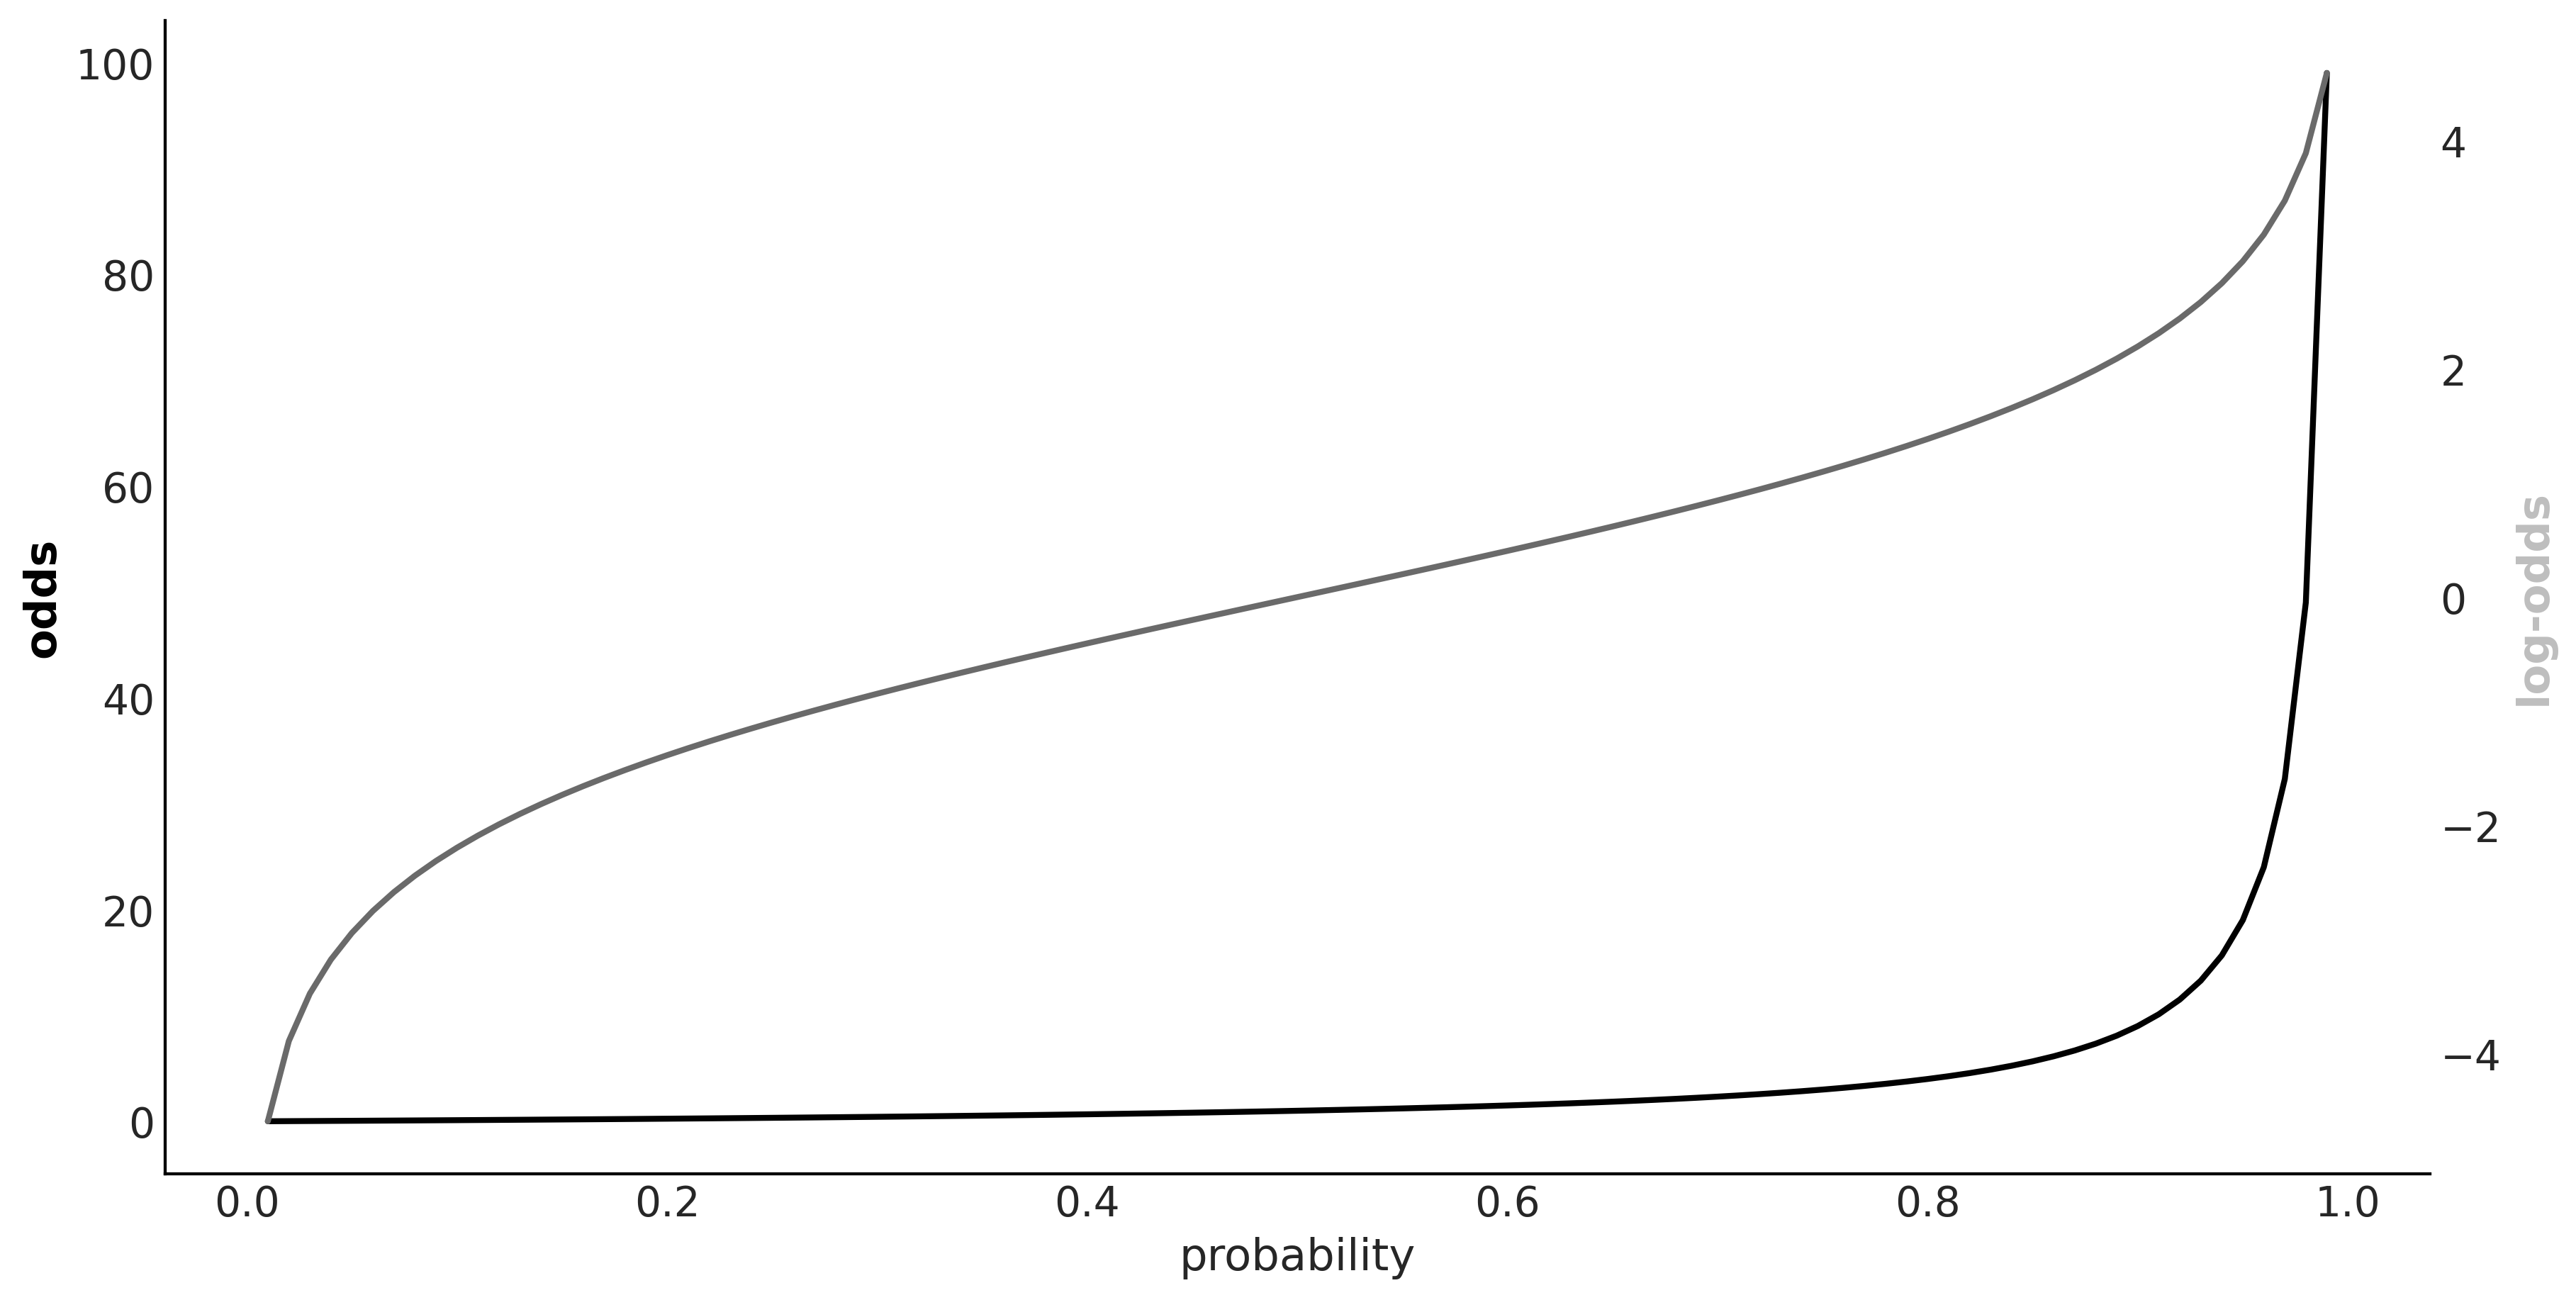

In [47]:
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)
_, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(probability, odds, "C0", lw=2)
ax2.plot(probability, np.log(odds), "C1", lw=2)
ax1.set_xlabel("probability")
ax1.set_ylabel("odds", color="C0", fontweight="bold")
ax2.set_ylabel("log-odds", color="C2", fontweight="bold")
ax1.grid(False)
ax2.grid(False)
# plt.savefig("../fig/logistic_odds.png")

## Variable Variance
- A linear regression model presents heteroskedasticity when the variance of the errors is not constant in all observations made

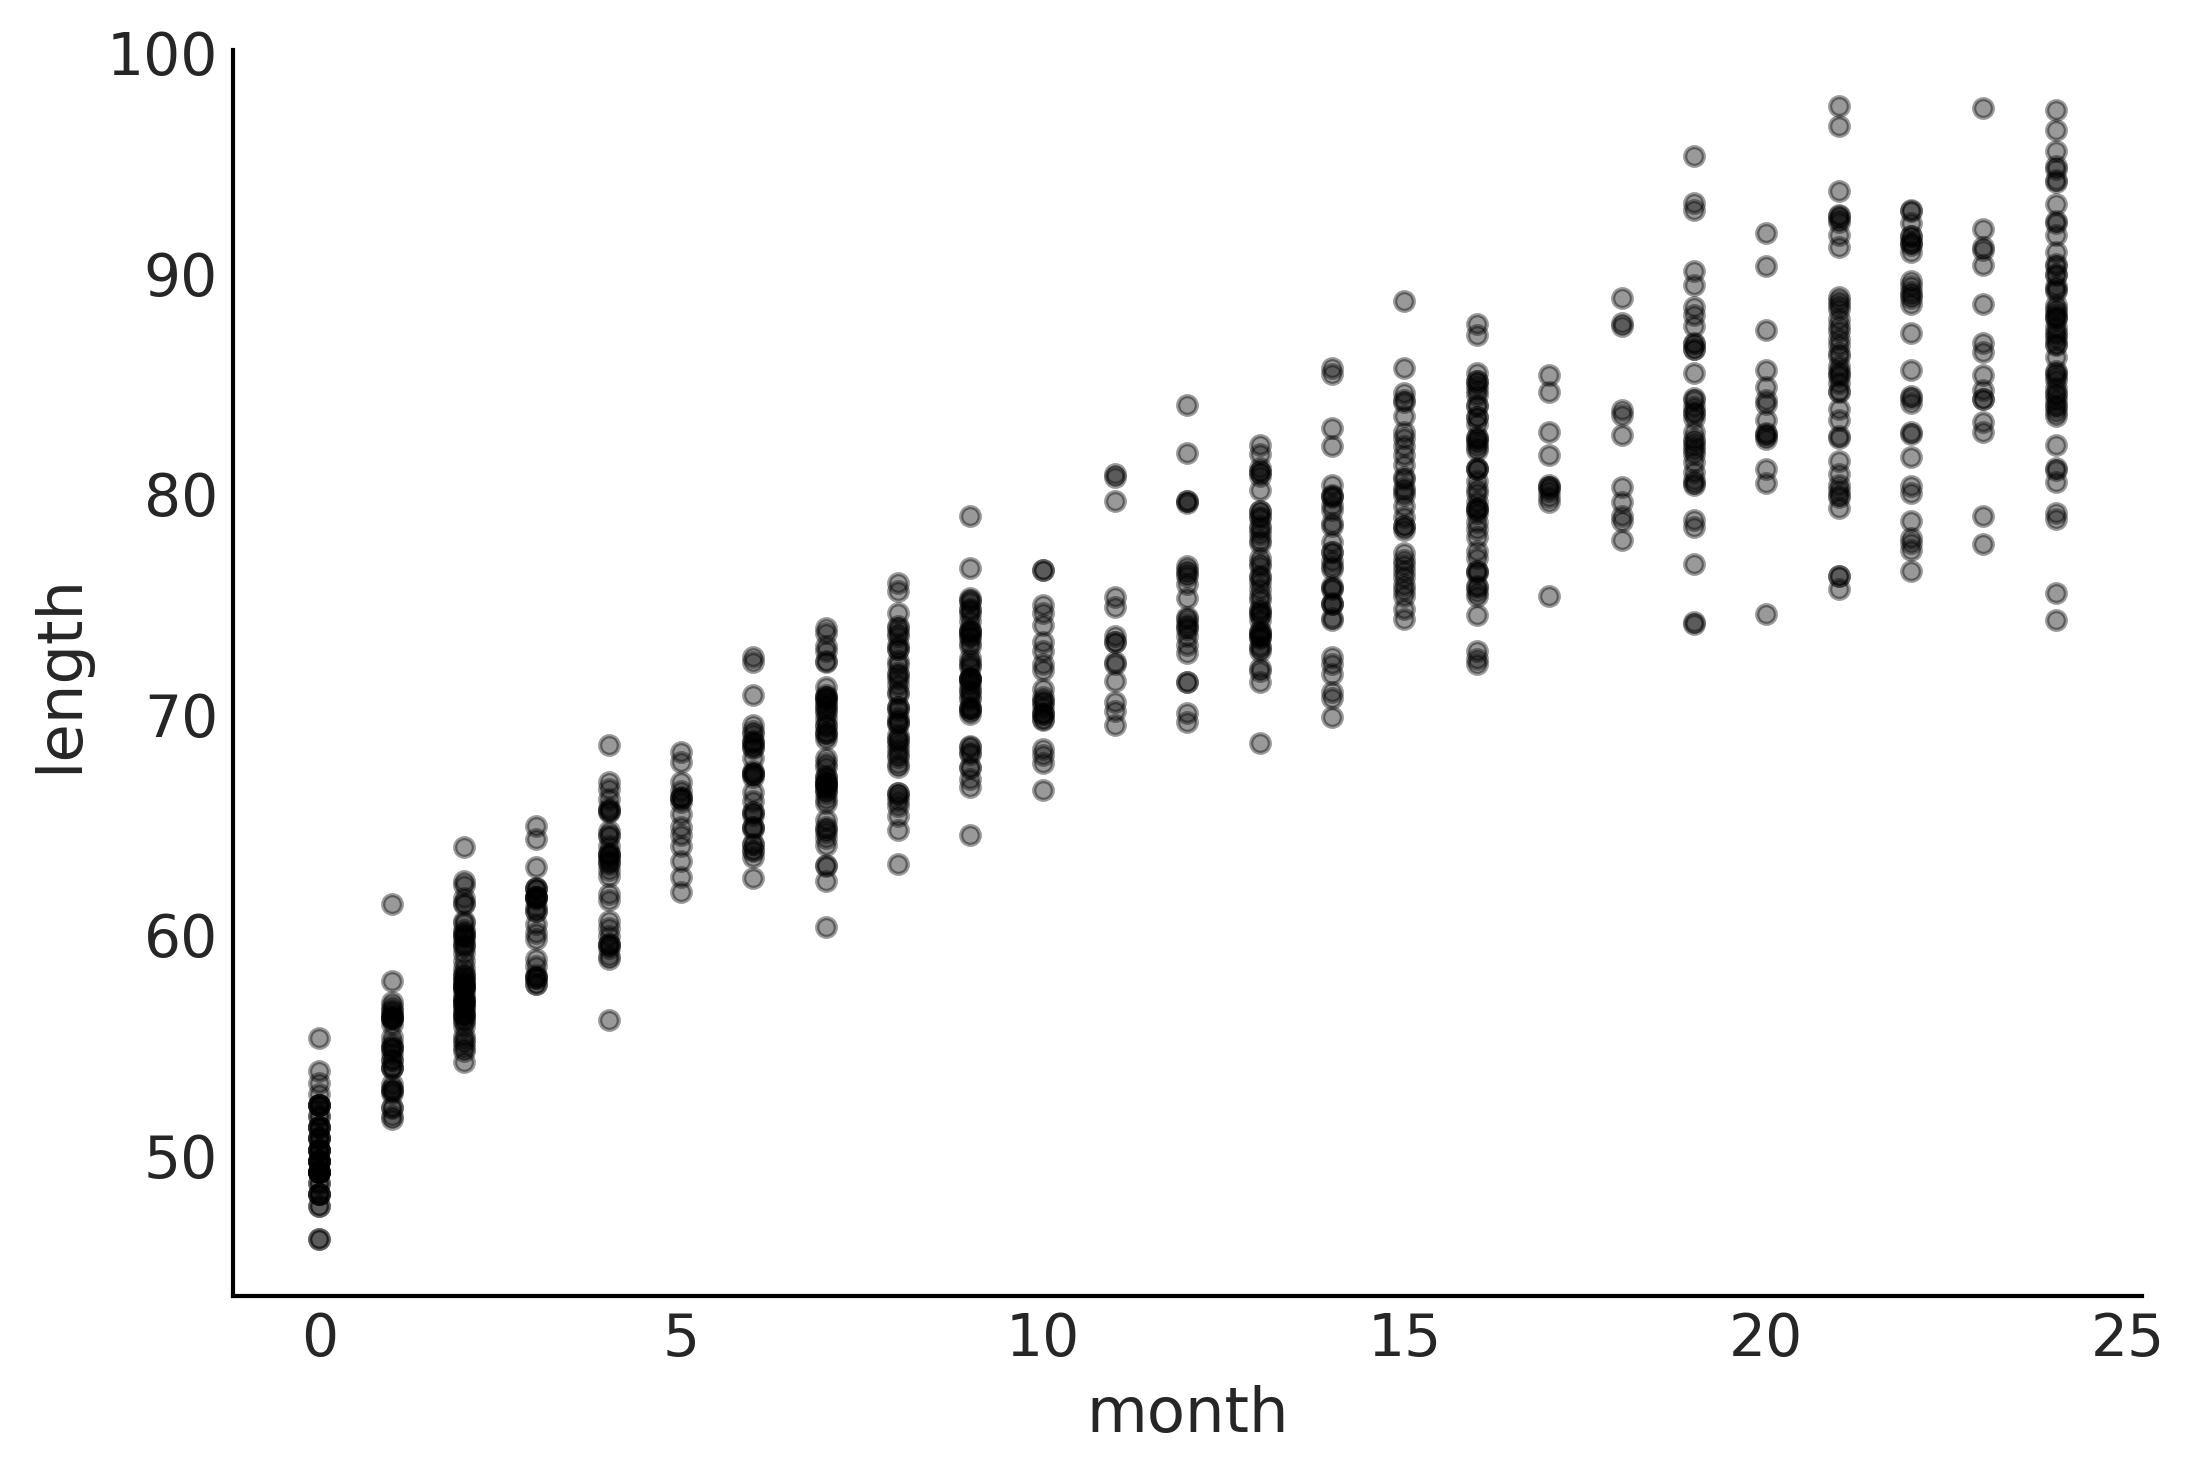

In [48]:
data = pd.read_csv("../code/data/babies.csv")
data.plot.scatter("month", "length", alpha = 0.4);

In [49]:
data

month     length
0        0  49.192857
1        0  51.221429
2        0  51.221429
3        0  52.742857
4        0  48.178571
..     ...        ...
791     24  83.645177
792     24  81.135569
793     24  90.929186
794     24  97.351140
795     24  94.193379

[796 rows x 2 columns]

In [50]:
with pm.Model() as model_vv:
    x_shared = pm.MutableData("x_shared", data.month.values.astype(float))
    alpha = pm.Normal("alpha", sigma = 10)
    beta = pm.Normal("beta", sigma = 10)
    gamma = pm.HalfNormal("gamma", sigma = 10)
    delta = pm.HalfNormal("delta", sigma = 10)

    mu = pm.Deterministic("mu", alpha + beta * x_shared**0.5)
    sigma = pm.Deterministic("sigma", gamma + delta * x_shared)
    
    y_pred = pm.Normal("y_pred", mu = mu, sigma = sigma, observed = data.length)
    
    idata_vv = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Text(0, 0.5, '$\\bar \\sigma$')

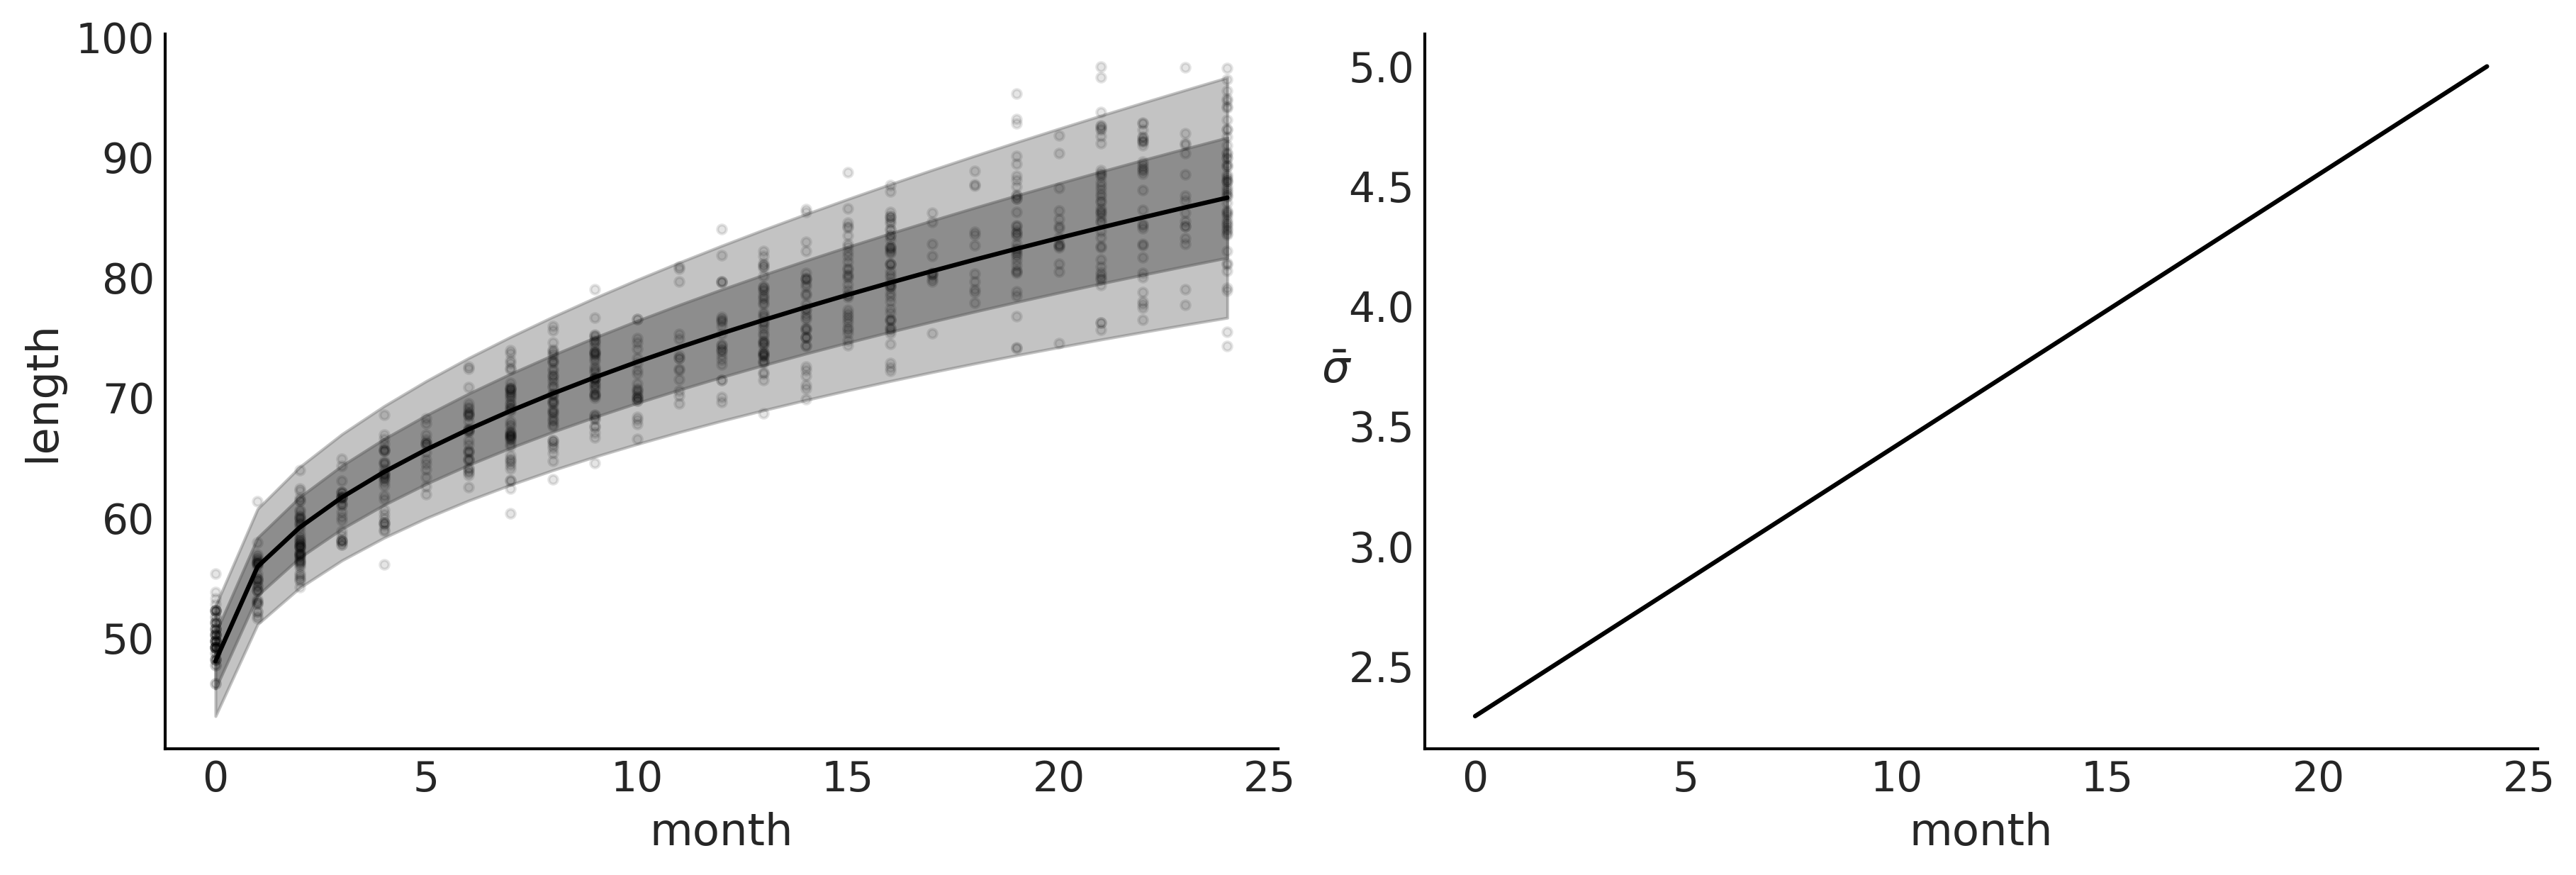

In [51]:
_, axes = plt.subplots(1, 2, figsize = (12, 4))

axes[0].plot(data.month, data.length, "C0.", alpha = 0.1)
posterior = az.extract(idata_vv)

mu_m = posterior['mu'].mean('sample').values
sigma_m = posterior['sigma'].mean('sample').values

axes[0].plot(data.month, mu_m, c = "k")
axes[0].fill_between(data.month, mu_m + sigma_m, mu_m - sigma_m, alpha = 0.6, color="C1")
axes[0].fill_between(data.month, mu_m + 2*sigma_m, mu_m - 2*sigma_m, alpha = 0.4, color="C1")

axes[0].set_xlabel("month")
axes[0].set_ylabel("length")

axes[1].plot(data.month, sigma_m)
axes[1].set_xlabel("month")
axes[1].set_ylabel(r"$\bar \sigma$", rotation=0)

In [52]:
# Compare the length of a particular girl to the distribution.  Eg: a girl who is 2 weeks old (0.5 months)
# To get predictions for unobserved values we need to define a mutable dataset which we have in x_shared
with model_vv:
    pm.set_data({"x_shared": [0.5]})
    ppc = pm.sample_posterior_predictive(idata_vv)
    y_ppc = ppc.posterior_predictive["y_pred"].stack(sample=("chain", "draw"))

Sampling: [y_pred]


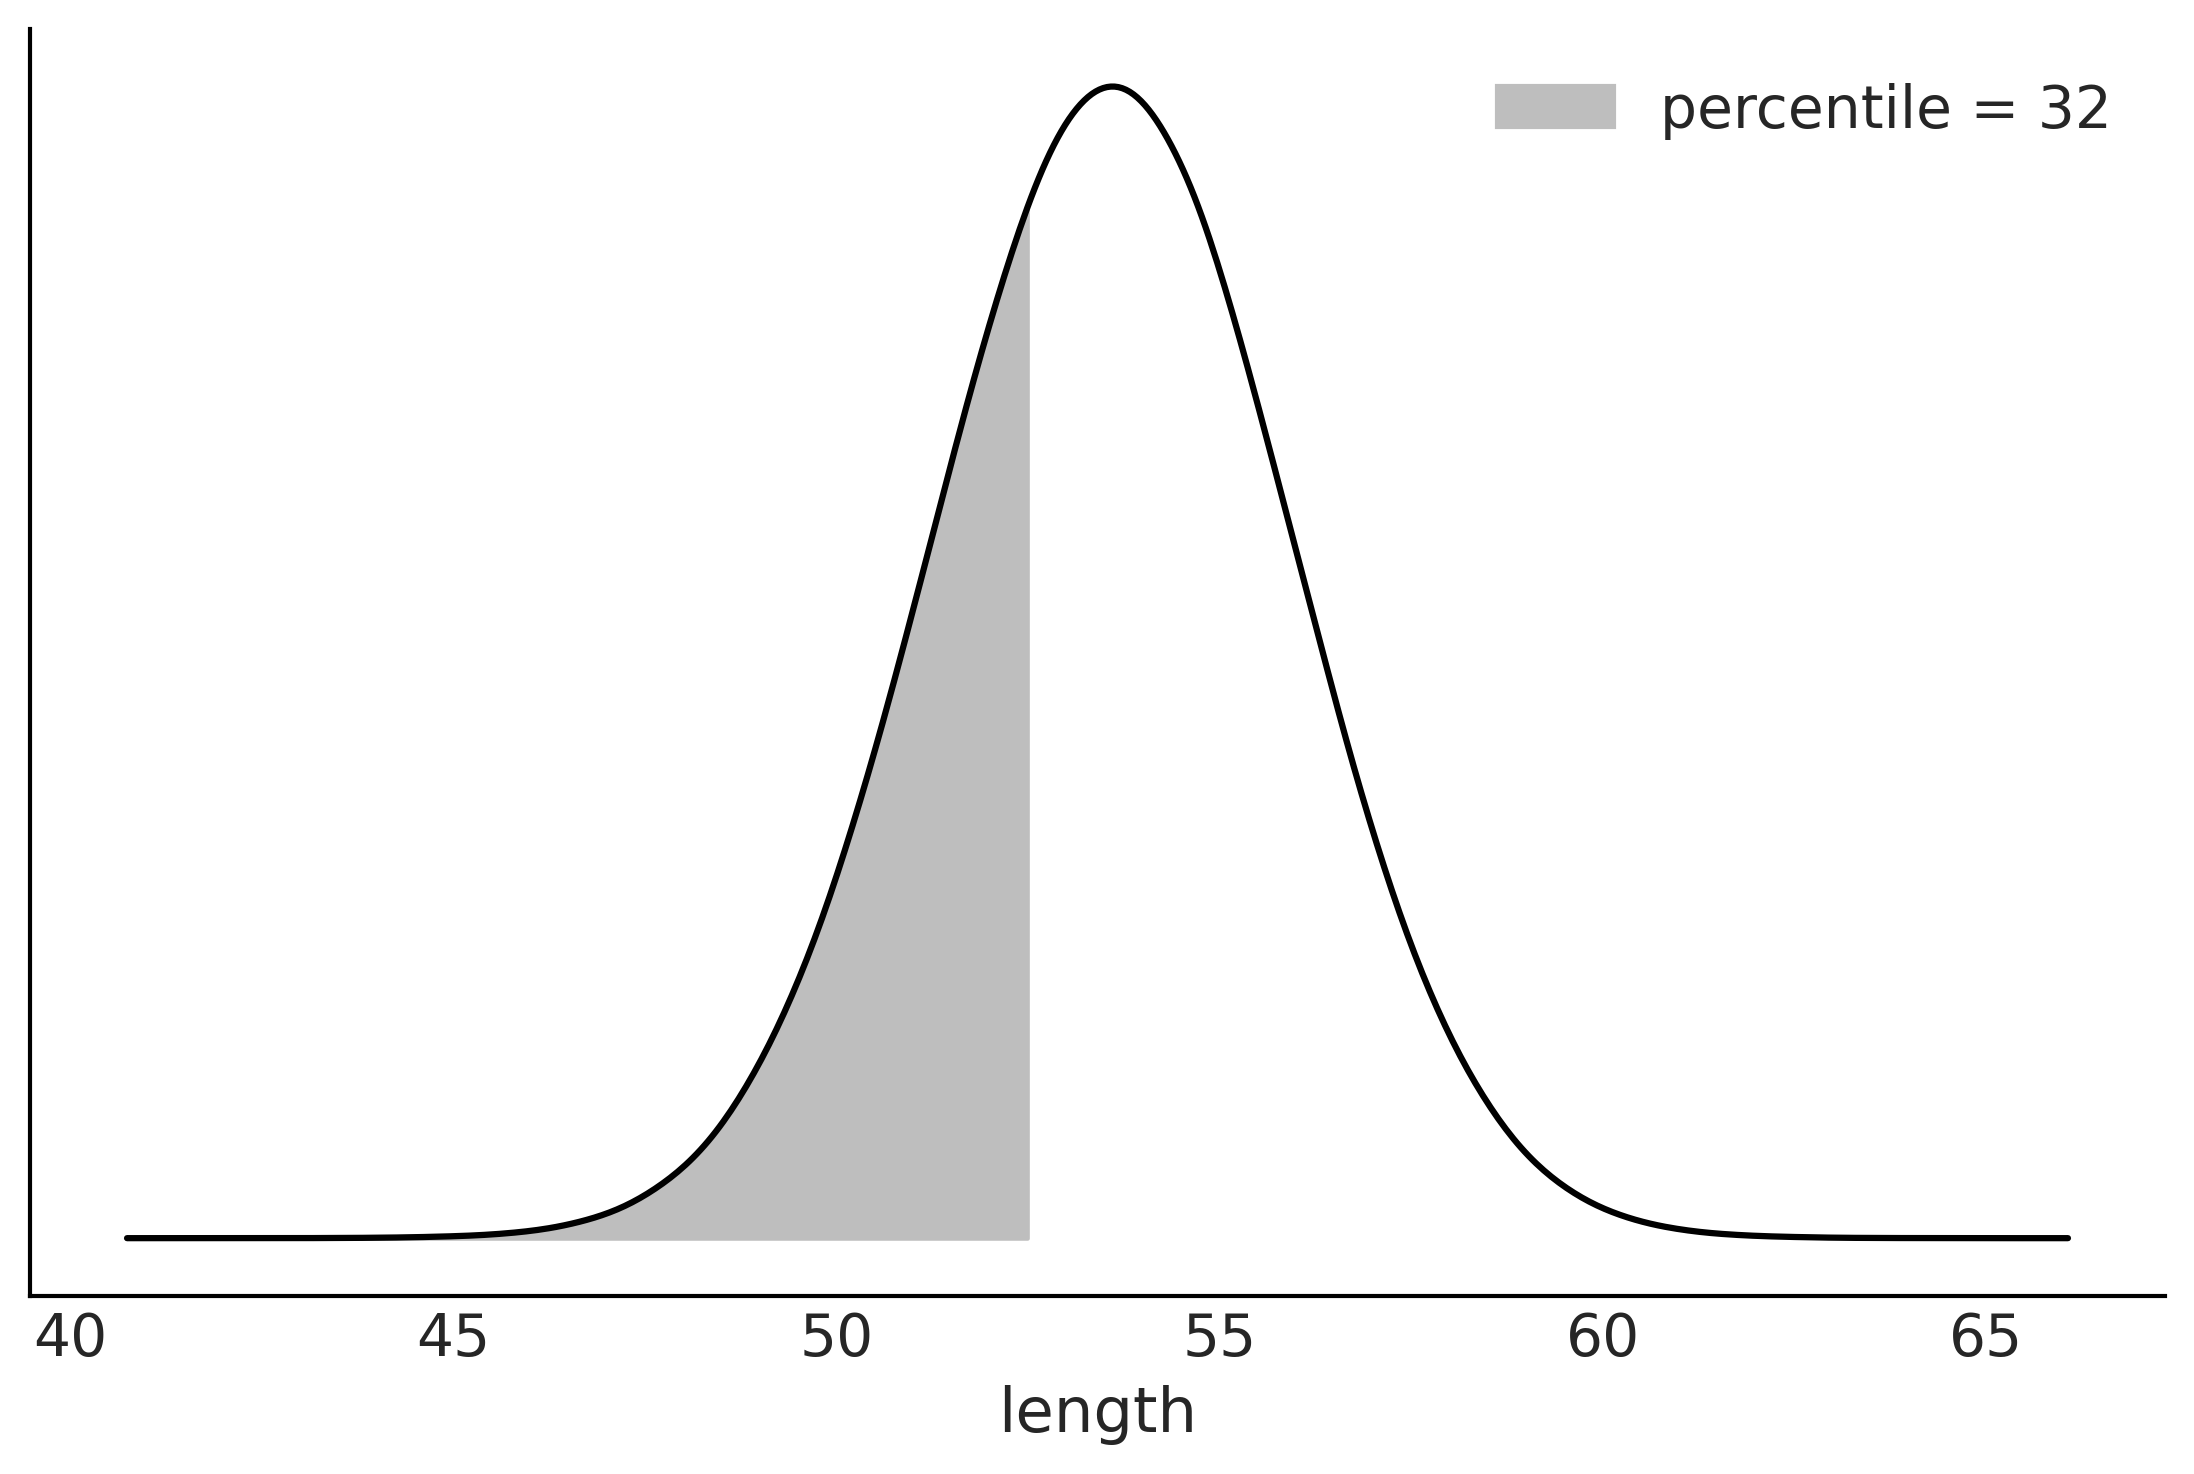

In [53]:
ref = 52.5
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc < ref).mean()*100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label = f"percentile = {percentile:2d}",
    color = "C2"
)
plt.xlabel("length")
plt.yticks([])
plt.legend();

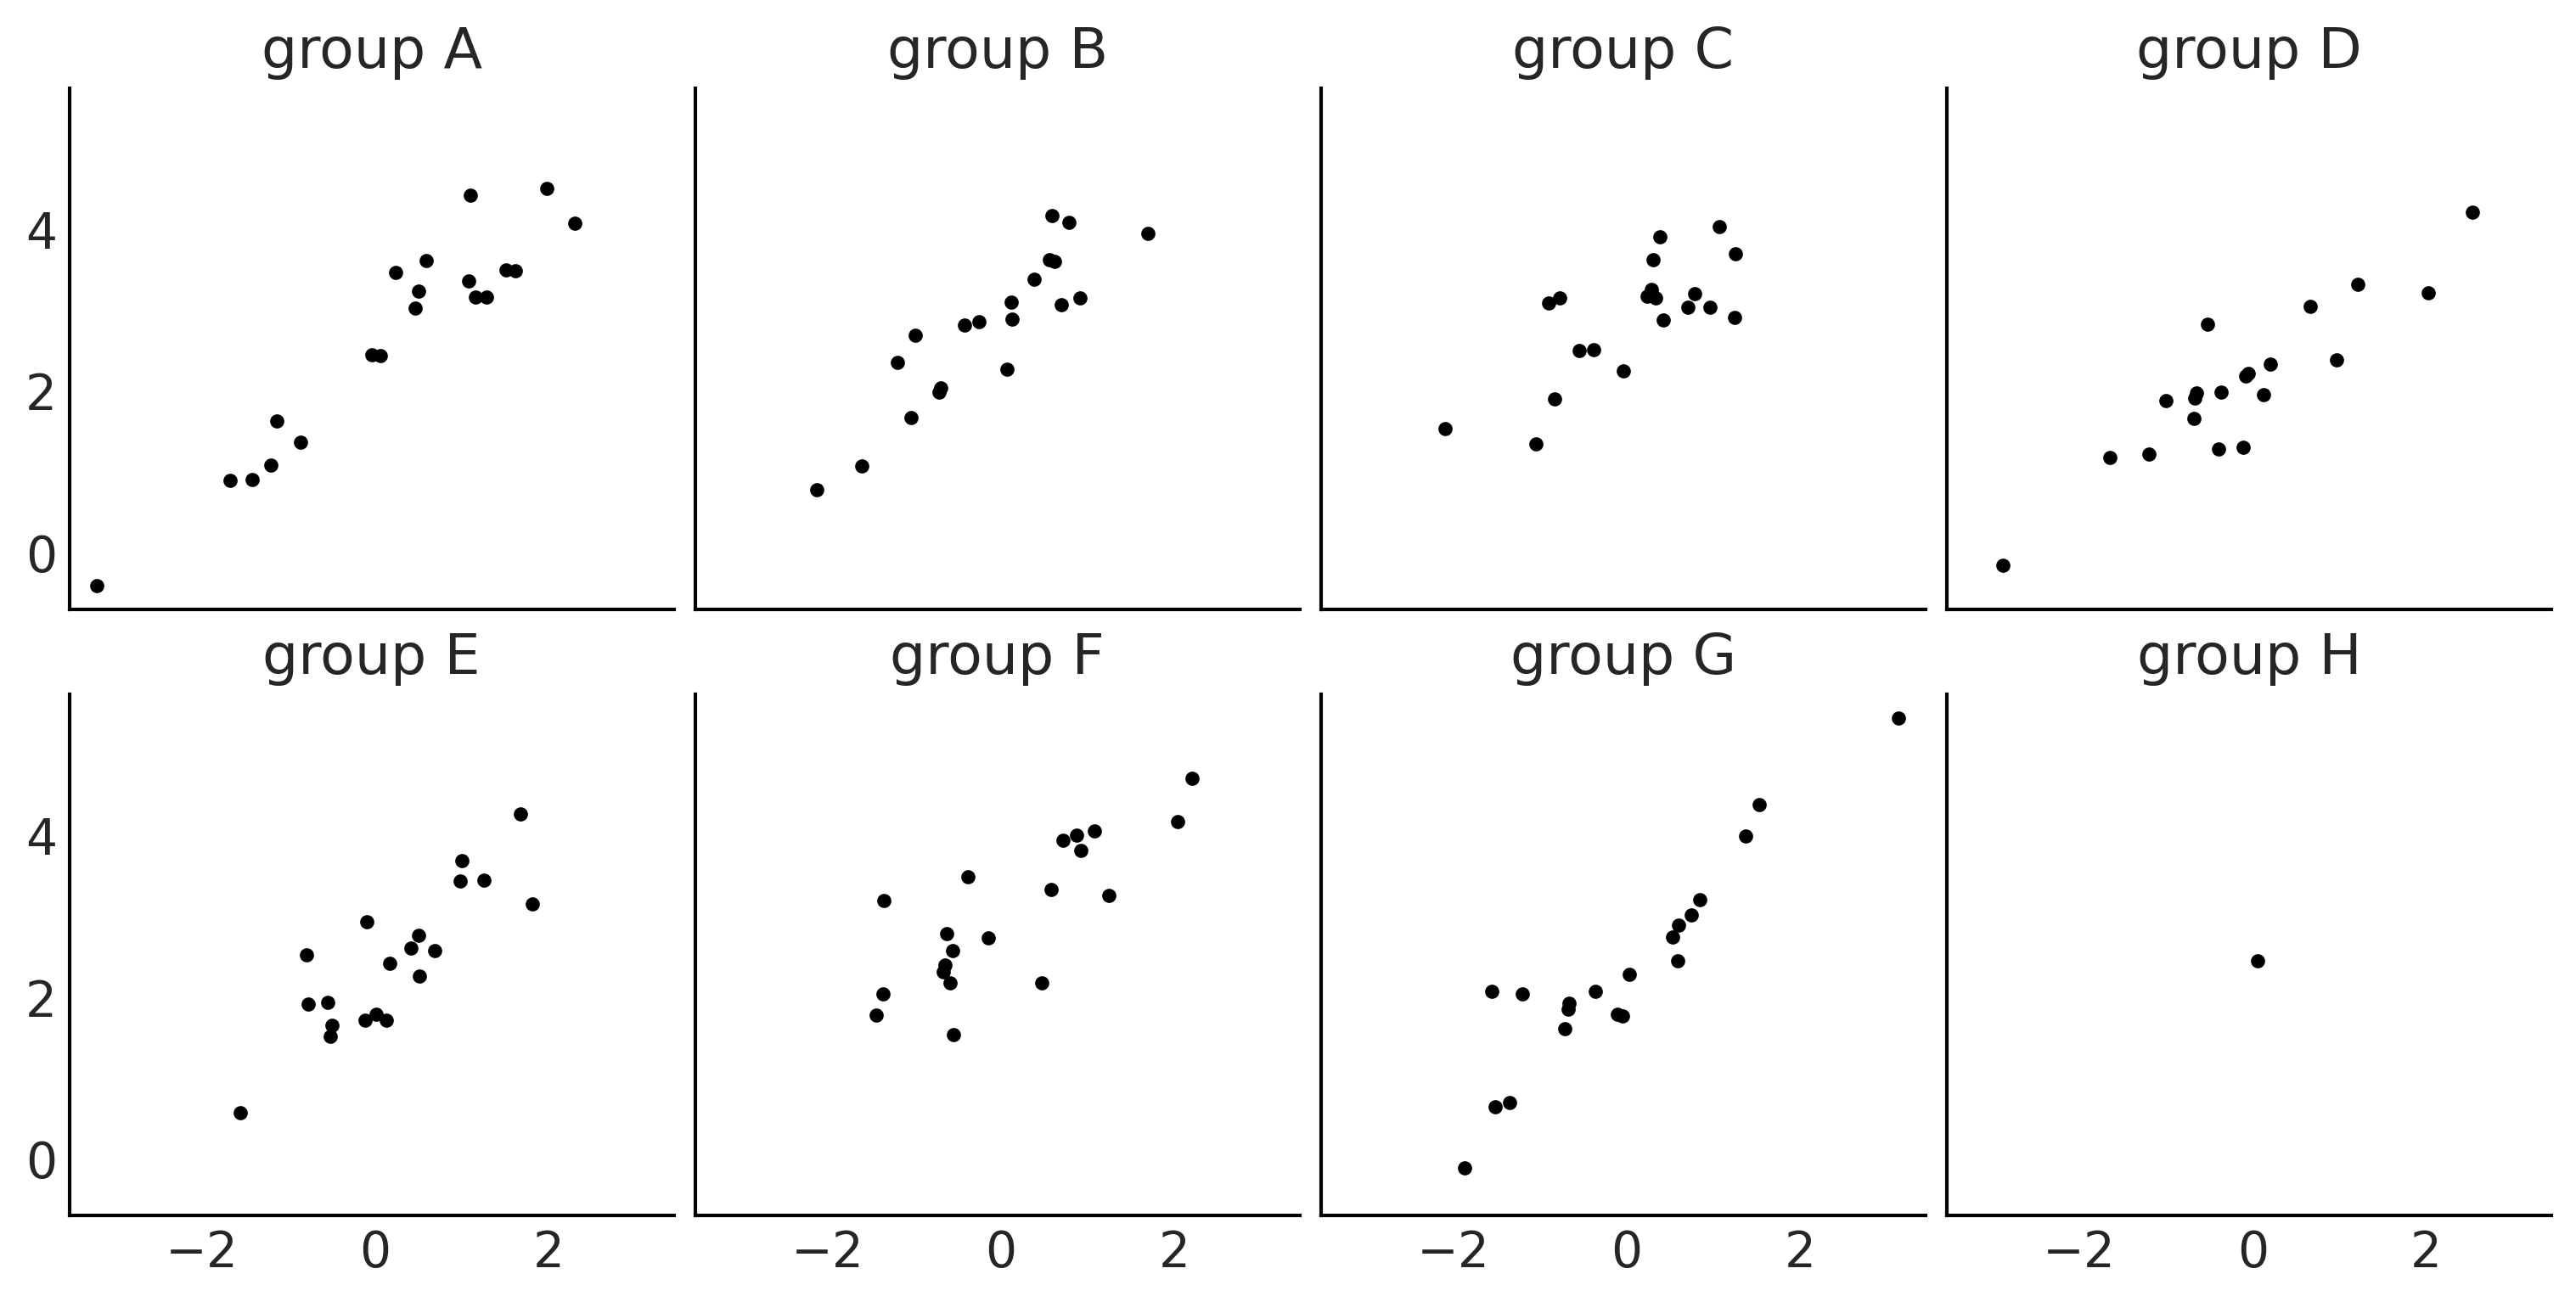

In [54]:
N = 20
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
M = len(groups)
idx = np.repeat(range(M - 1), N)
idx = np.append(idx, 7)
np.random.seed(314)
alpha_real = np.random.normal(2.5, 0.5, size = M)
beta_real = np.random.beta(6, 1, size = M)  # Left skew
eps_real = np.random.normal(0, 0.5, size = len(idx))
y_m = np.zeros(len(idx))
x_m = np.random.normal(0, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_title(f"group {g}")

    j += N
    k += N

In [55]:
coords = {"group": ["A", "B", "C", "D", "E", "F", "G", "H"]}

with pm.Model(coords = coords) as unpooled_model:
    alpha = pm.Normal("alpha", mu = 0, sigma = 10, dims = "group")
    beta = pm.Normal("beta", mu = 0, sigma = 10, dims = "group")
    sigma = pm.HalfNormal("sigma", 5)
    _ = pm.Normal("y_pred", mu = alpha[idx] + beta[idx] * x_m, sigma = sigma, observed = y_m)
    
    idata_up = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


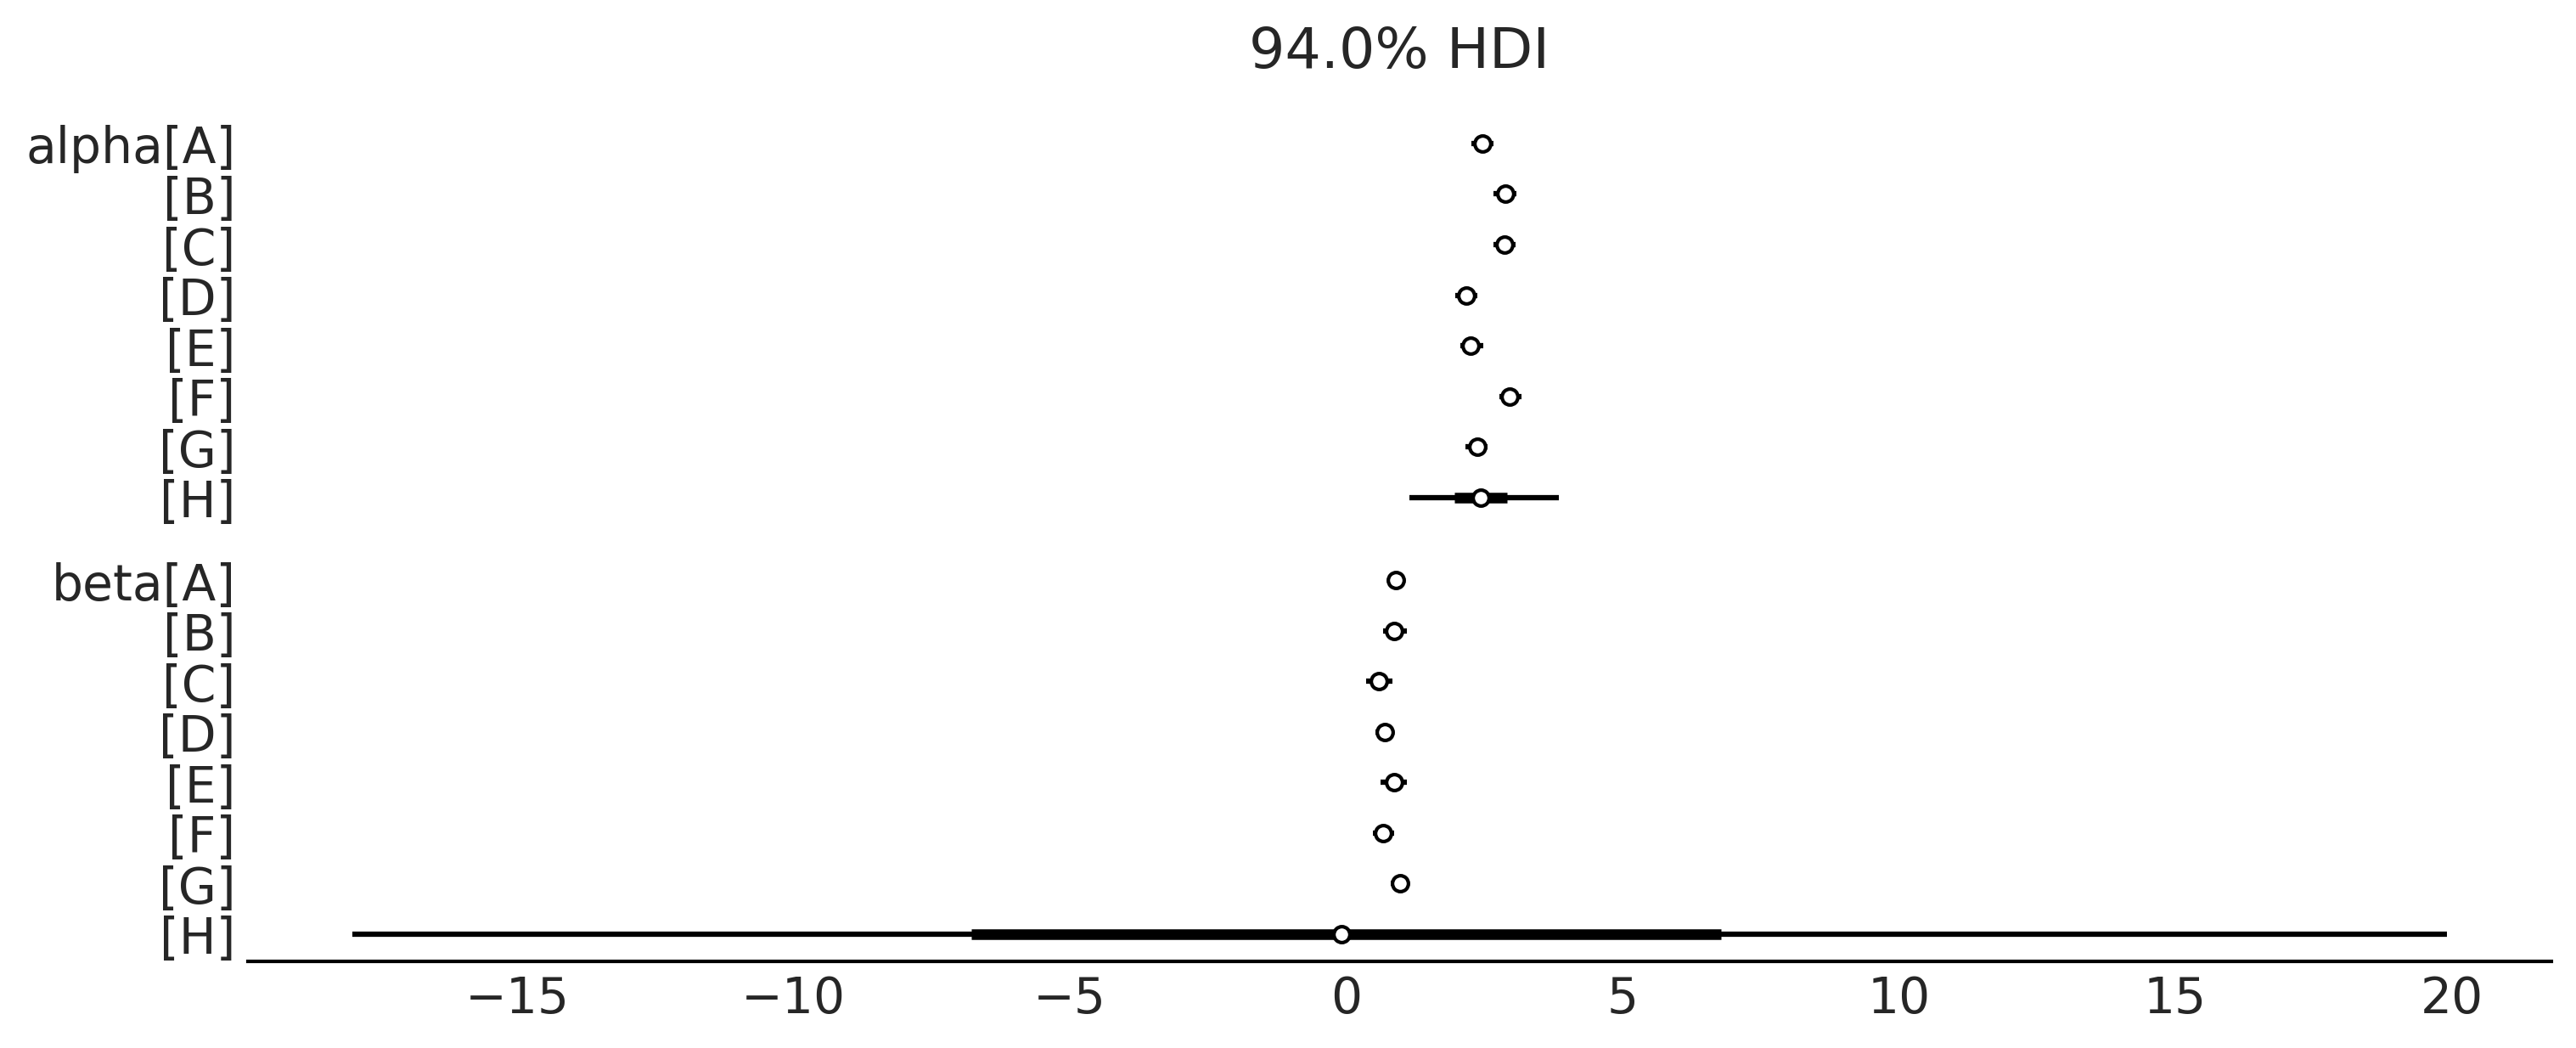

In [56]:
az.plot_forest(idata_up, var_names=["alpha", "beta"], combined = True, figsize=(10,4));

In [57]:
# help(pm.HalfNormal)

In [58]:
with pm.Model(coords = coords) as hierarchical_centred:
    # Hyperpriors
    alpha_mu = pm.Normal("alpha_mu", mu = y_m.mean(), sigma = 1, dims = "group")
    alpha_sigma = pm.HalfNormal("alpha_sigma", sigma = 5)
    beta_mu = pm.Normal("beta_mu", mu = 0, sigma = 1)
    beta_sigma = pm.HalfNormal("beta_sigma", sigma = 5)
    
    # Priors
    alpha = pm.Normal("alpha", mu = alpha_mu, sigma = alpha_sigma, dims = "group")
    beta = pm.Normal("beta", mu = beta_mu, sigma = beta_sigma, dims = "group")
    sigma = pm.HalfNormal("sigma", 5)
    _ = pm.Normal("y_pred", mu = alpha[idx] + beta[idx] * x_m, sigma = sigma, observed = y_m)
    
    idata_cen = pm.sample(target_accept = 0.9)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_sigma, beta_mu, beta_sigma, alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 256 divergences after tuning. Increase `target_accept` or reparameterize.


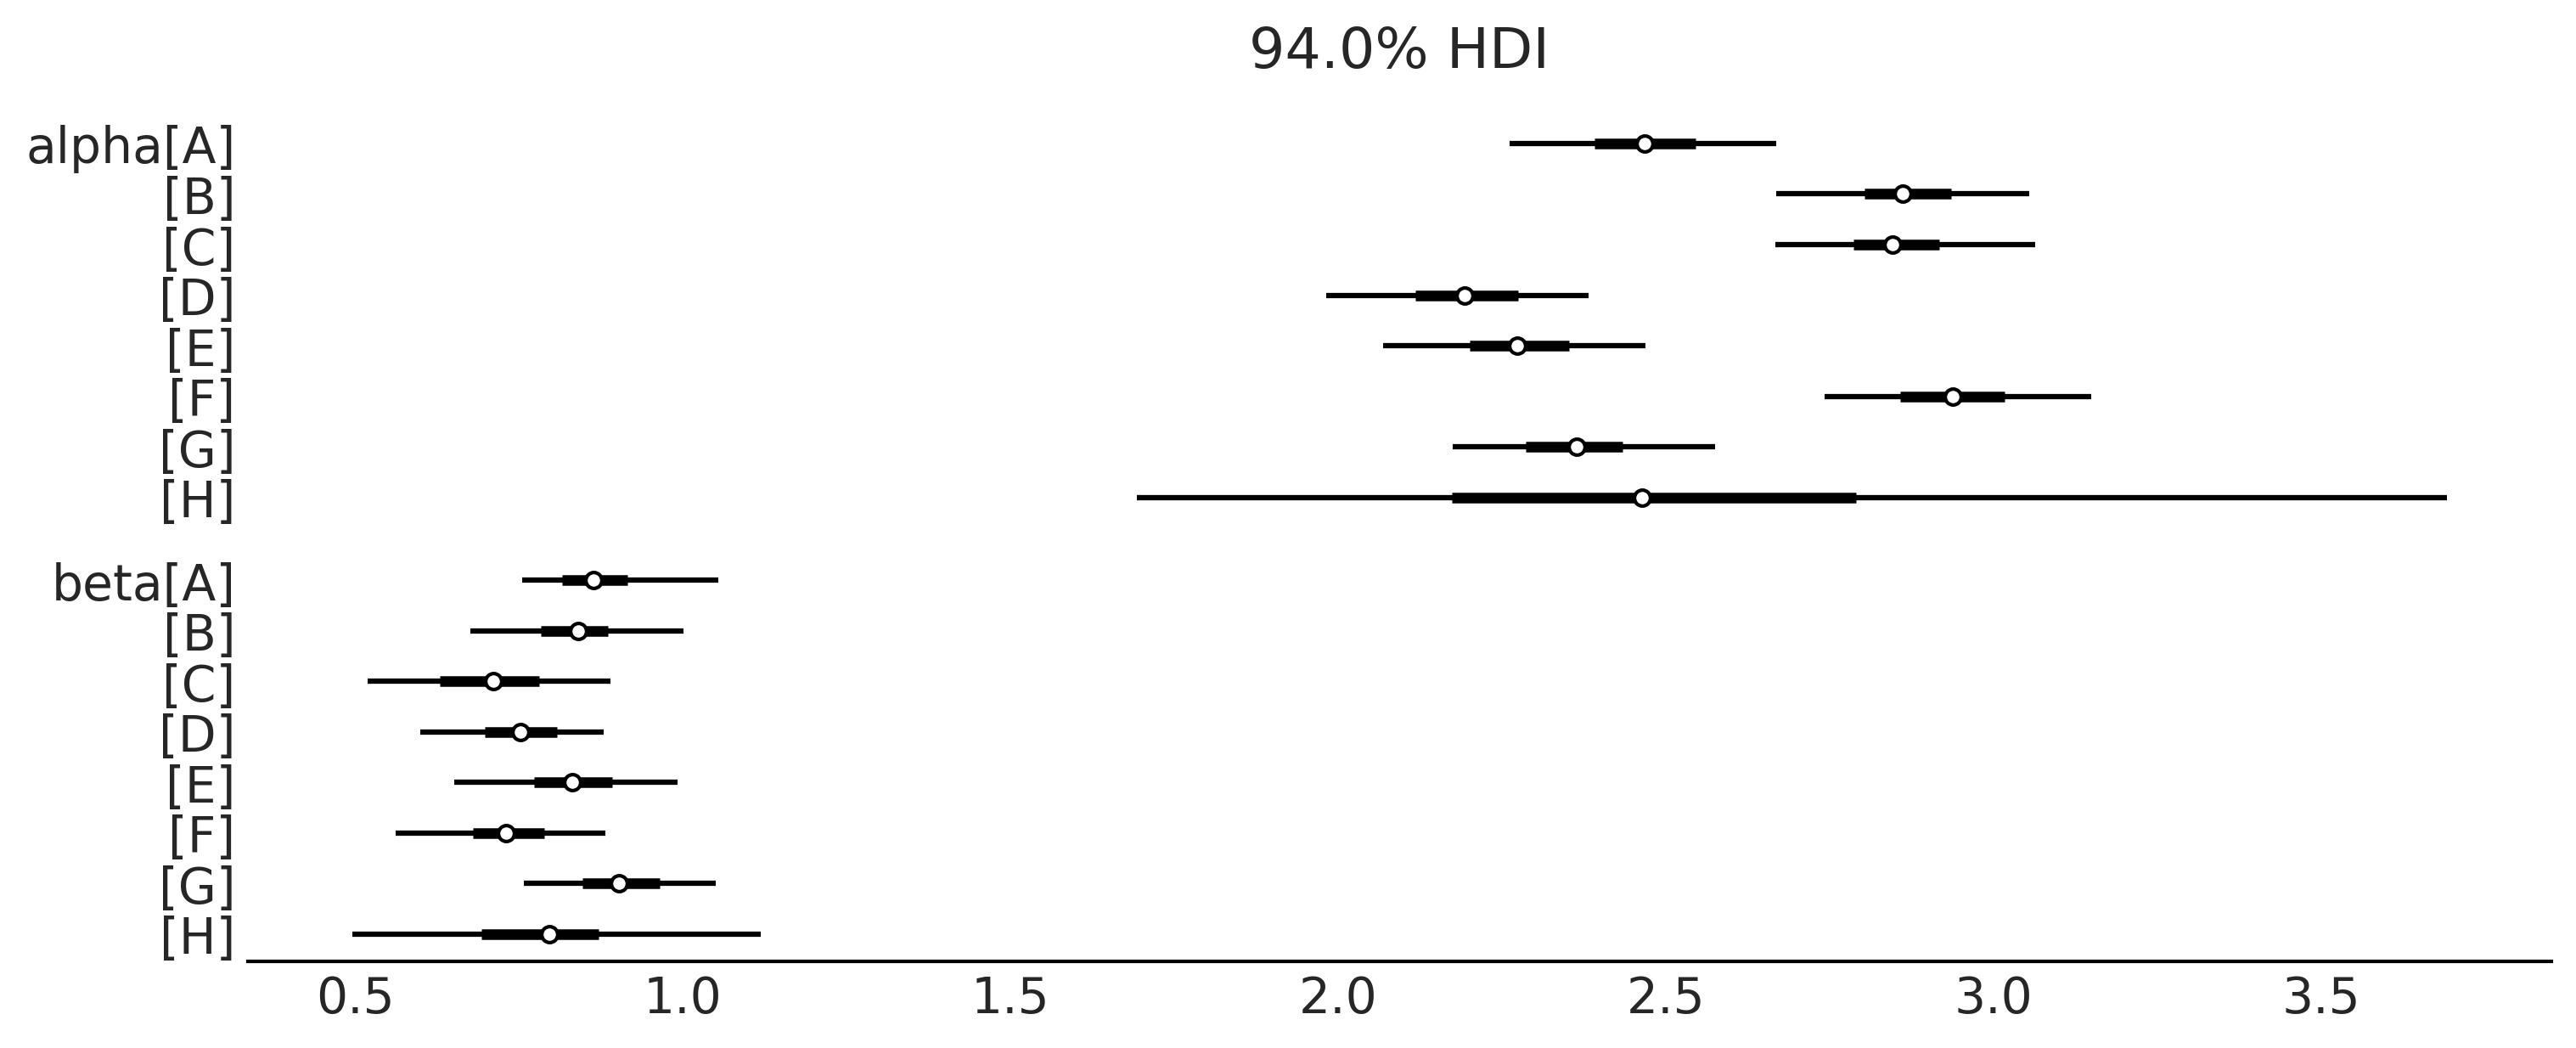

In [59]:
az.plot_forest(idata_cen, var_names=["alpha", "beta"], combined=True, figsize=(10,4));

In [60]:
with pm.Model(coords=coords) as hierarchical_non_centered:
    # hyper-priors
    α_μ = pm.Normal("α_μ", mu=y_m.mean(), sigma=1)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=1)
    β_σ = pm.HalfNormal("β_σ", sigma=5)
    
    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="group")

    β_offset = pm.Normal("β_offset", mu=0, sigma=1, dims="group")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="group")

    σ = pm.HalfNormal("σ", 5)
    _ = pm.Normal("y_pred", mu=α[idx] + β[idx] * x_m, sigma=σ, observed=y_m)

    idata_ncen = pm.sample(random_seed=123, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β_offset, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [61]:
# Reparameterise
with pm.Model(coords = coords) as hierarchical_non_centred:
    # Hyperpriors
    alpha_mu = pm.Normal("alpha_mu", mu = y_m.mean(), sigma = 1)
    alpha_sigma = pm.HalfNormal("alpha_sigma", sigma = 5)
    beta_mu = pm.Normal("beta_mu", mu = 0, sigma = 1)
    beta_sigma = pm.HalfNormal("beta_sigma", sigma = 5)
    
    # Priors
    alpha = pm.Normal("alpha", mu = alpha_mu, sigma = alpha_sigma, dims = "group")
    beta_offset = pm.Normal("beta_offset", mu=0, sigma=1, dims="group")
    beta = pm.Deterministic("beta", beta_mu + beta_offset * beta_sigma, dims="group")
    
    sigma = pm.HalfNormal("sigma", 5)
    _ = pm.Normal("y_pred", mu = alpha[idx] + beta[idx] * x_m, sigma = sigma, observed = y_m)
    
    idata_ncen = pm.sample(random_seed = 123, target_accept = 0.95)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_mu, alpha_sigma, beta_mu, beta_sigma, alpha, beta_offset, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


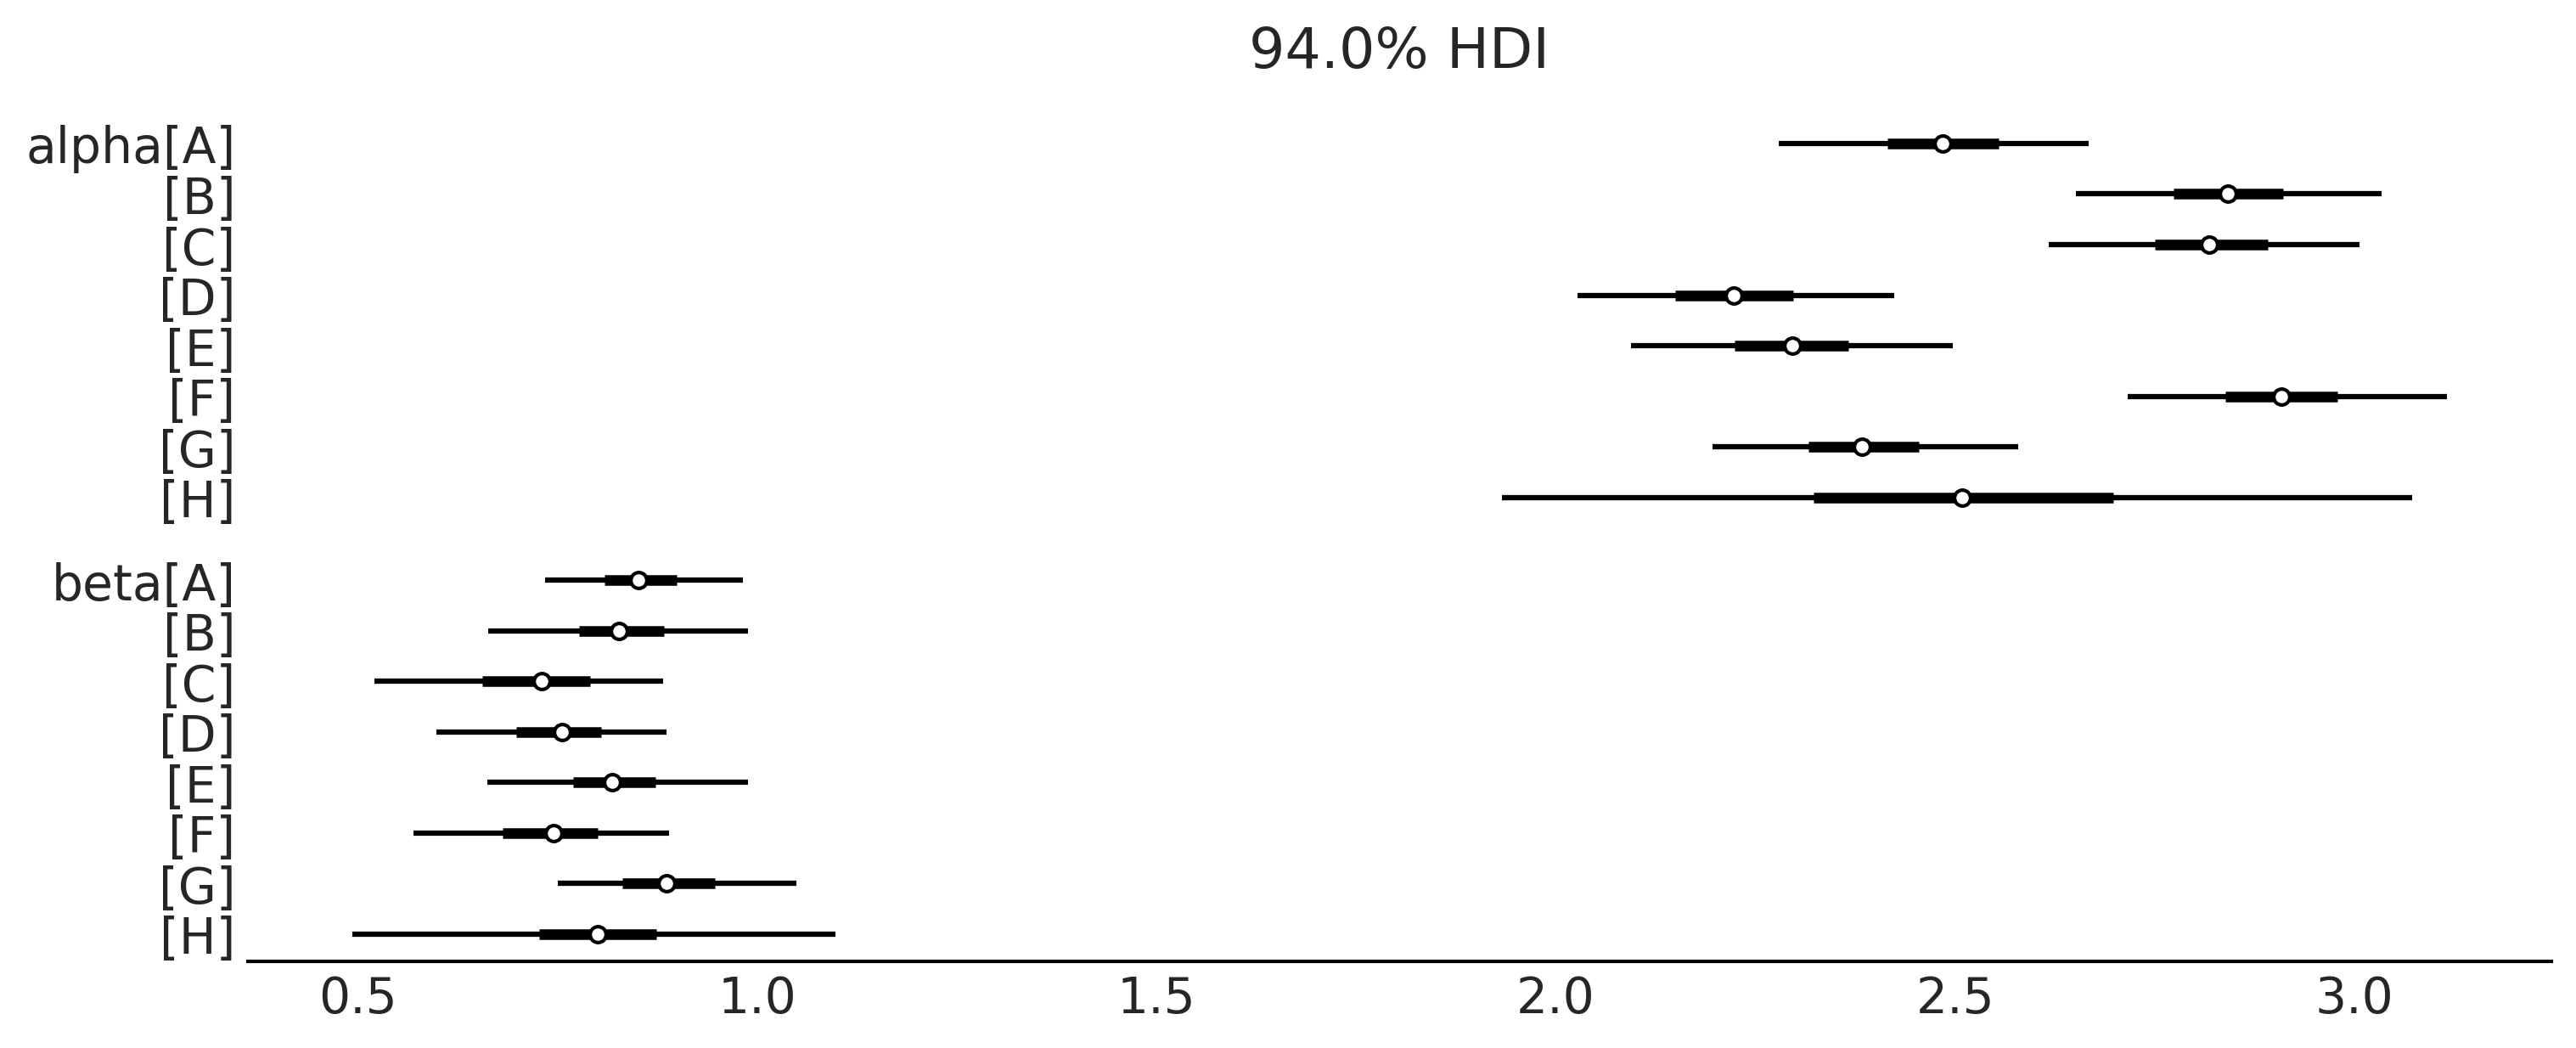

In [62]:
az.plot_forest(idata_ncen, var_names=["alpha", "beta"], combined=True, figsize=(10, 4));

/home/mrosinski/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
/home/mrosinski/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
/home/mrosinski/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
/home/mrosinski/miniconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other fu

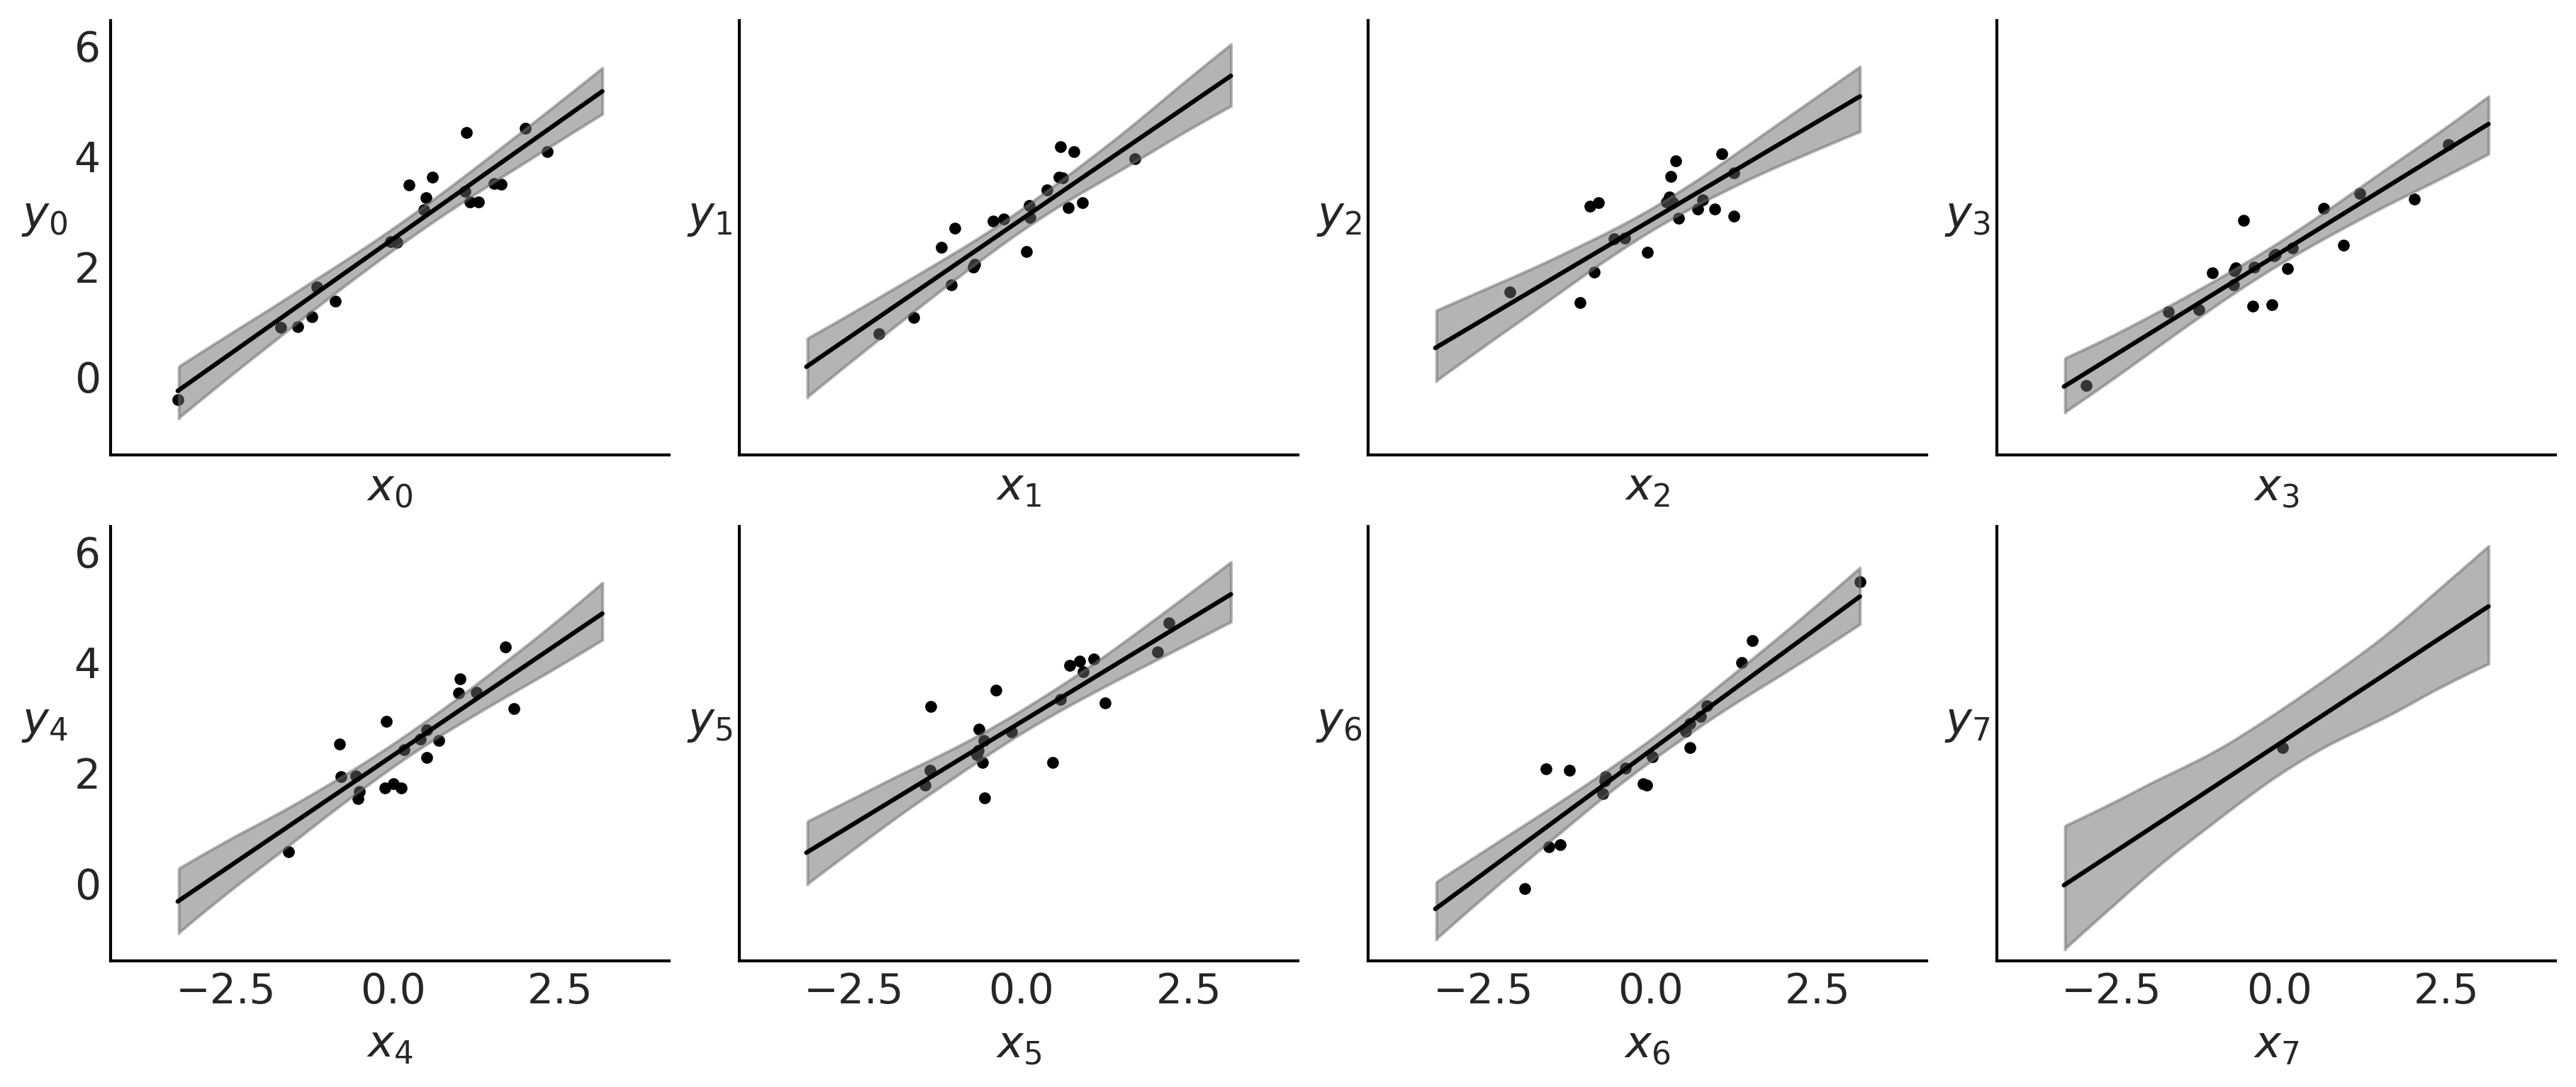

In [63]:
_, ax = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
posterior = az.extract(idata_ncen)

for i, g in enumerate(groups):
    ax[i].scatter(x_m[j:k], y_m[j:k], marker=".")
    ax[i].set_xlabel("$x_{}$".format(i))
    ax[i].set_ylabel("$y_{}$".format(i), labelpad=10, rotation=0)
    alfas = posterior["alpha"].sel(group=g)
    betas = posterior["beta"].sel(group=g)
    alfa_m = alfas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    ax[i].plot(x_range, alfa_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alfas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    plt.xlim(x_m.min() - 1, x_m.max() + 1)
    plt.ylim(y_m.min() - 1, y_m.max() + 1)
    j += N
    k += N

## Multiple Linear Regression

- Holding all other variables constant
- The coefficients represent the change in the dependent variable for a unit change in the independent variable

In [64]:
with pm.Model() as model_mlb:
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta0 = pm.Normal('beta0', mu = 0, sigma = 10)
    beta1 = pm.Normal('beta1', mu = 0, sigma = 10)
    sigma = pm.HalfNormal('sigma', 10)
    mu = pm.Deterministic('mu', pm.math.exp(alpha + beta0 * bikes.temperature + beta1 * bikes.hour))
    _ = pm.NegativeBinomial('y_pred', mu = mu, alpha = sigma, observed = bikes.rented)
    idata_mlb = pm.sample()
    idata_mlb.extend(pm.sample_posterior_predictive(idata_mlb))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [y_pred]


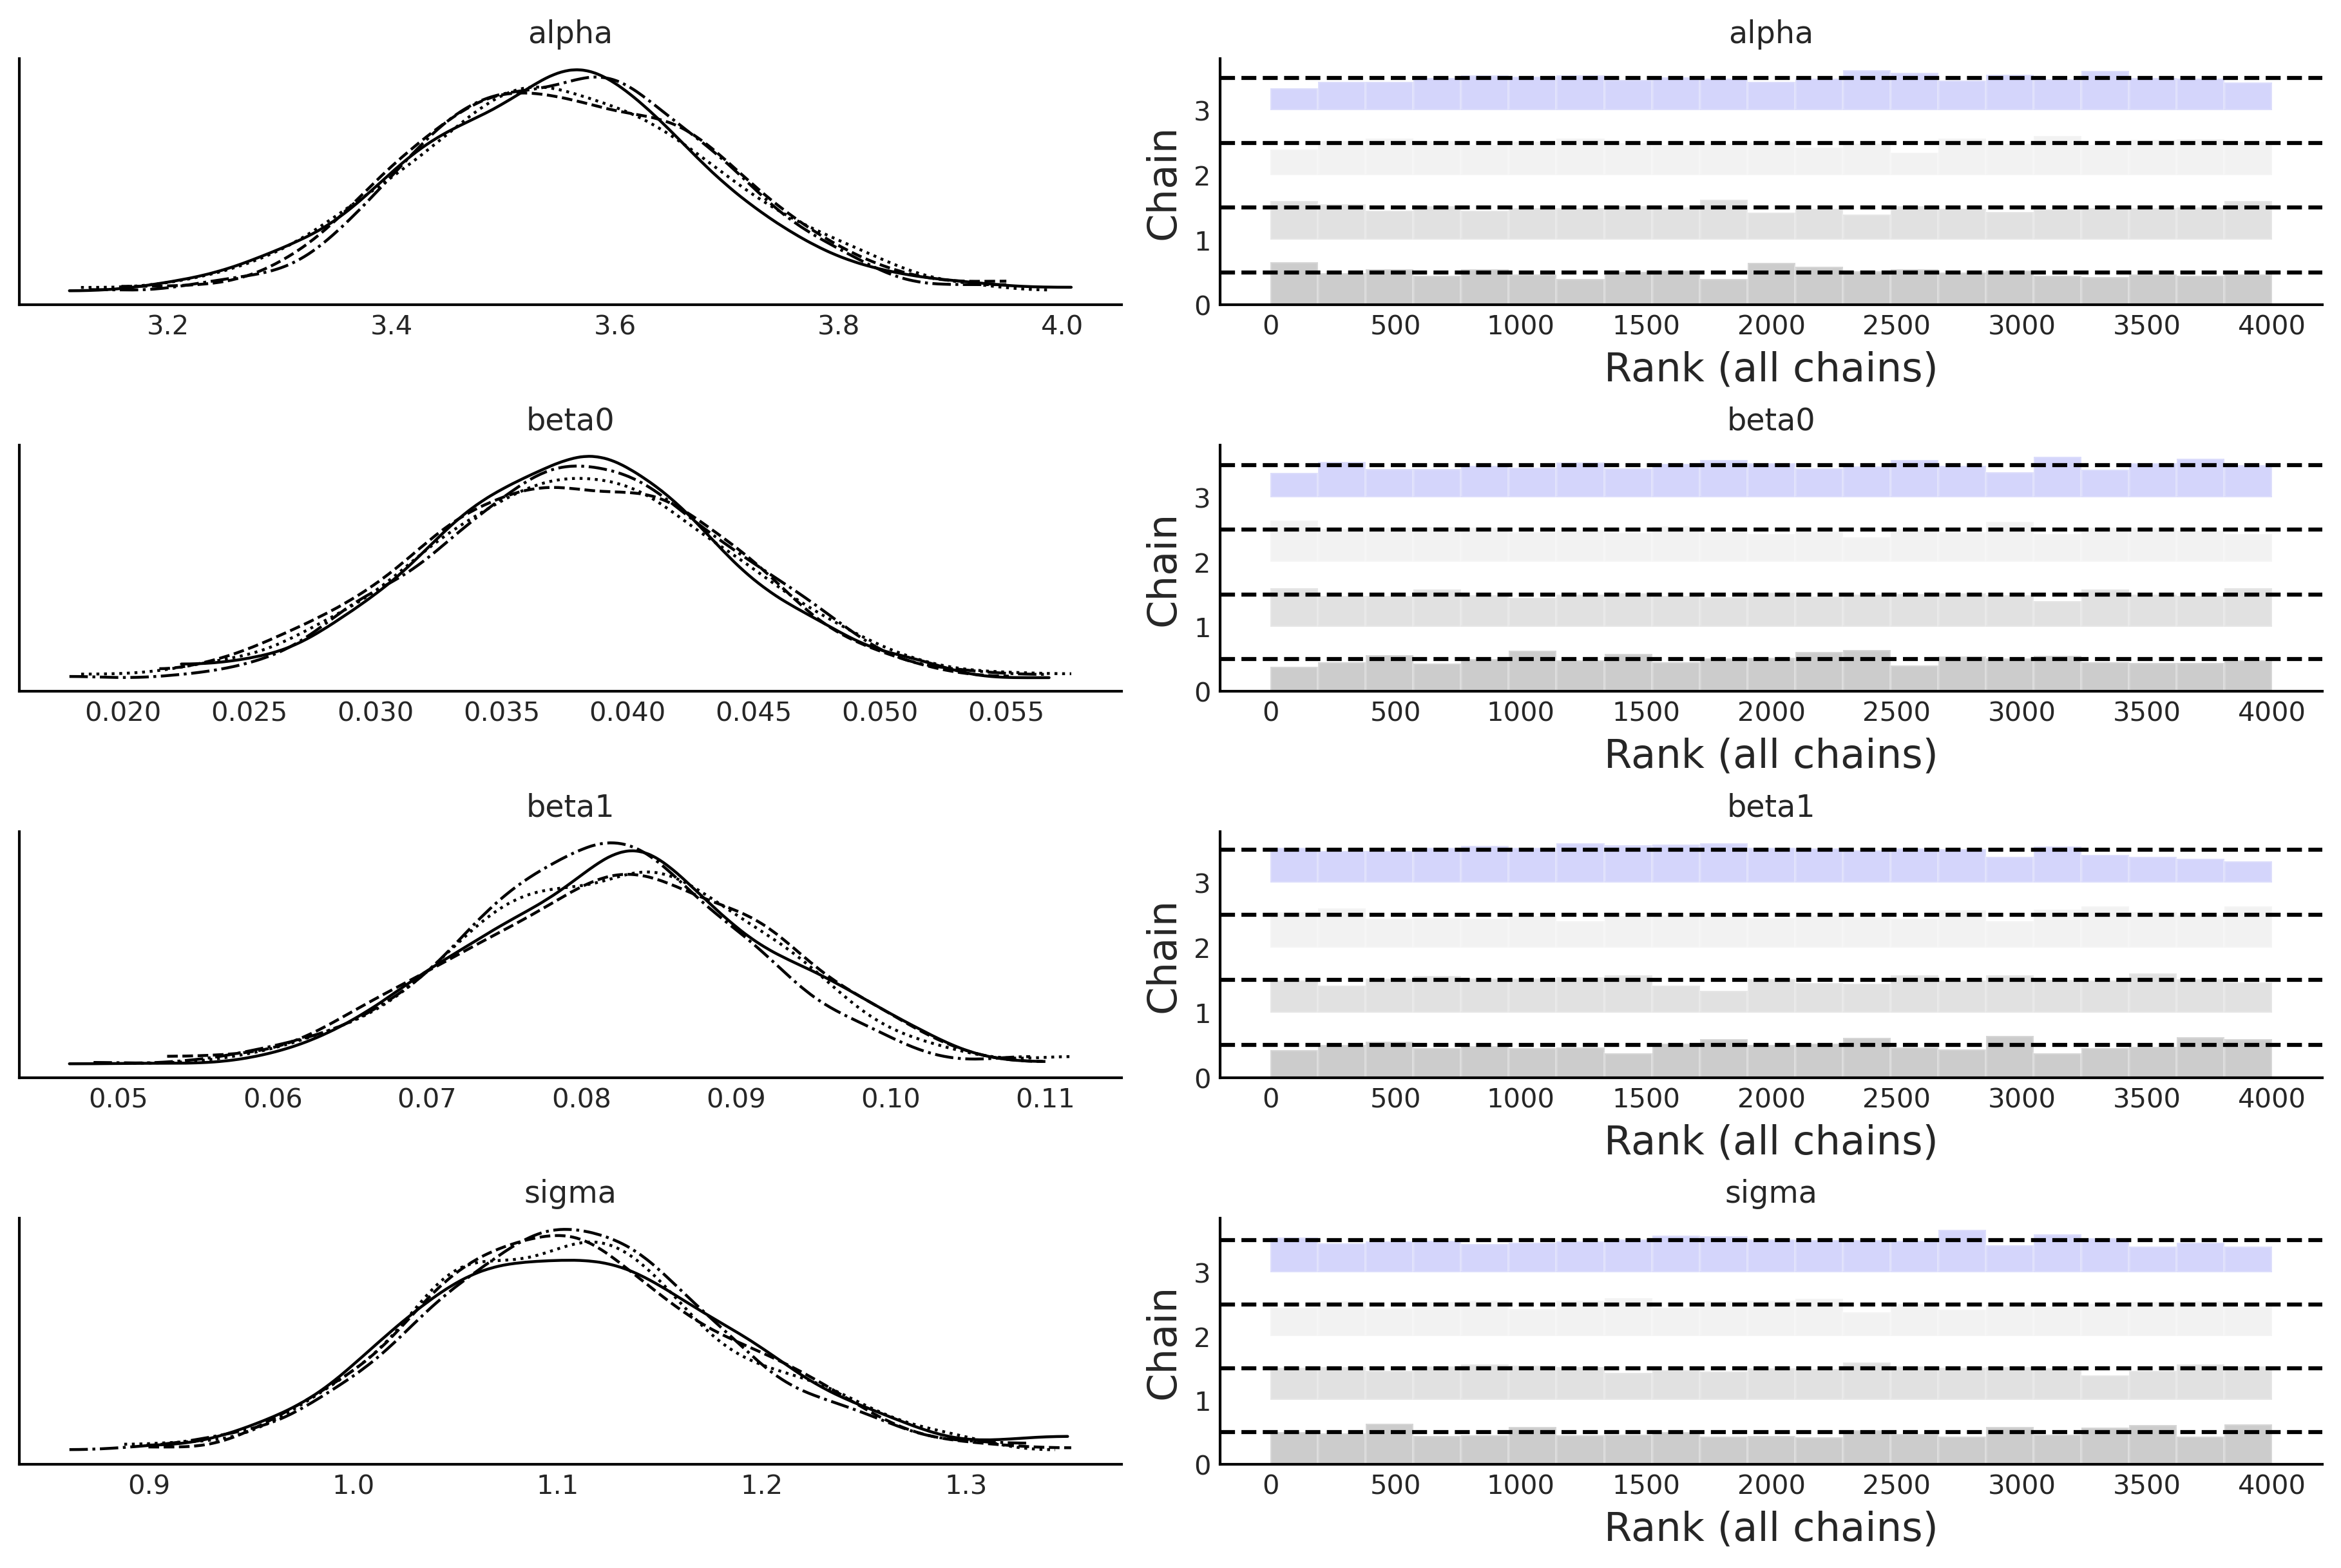

In [65]:
az.plot_trace(idata_mlb, var_names = ["~mu"], kind = "rank_bars");

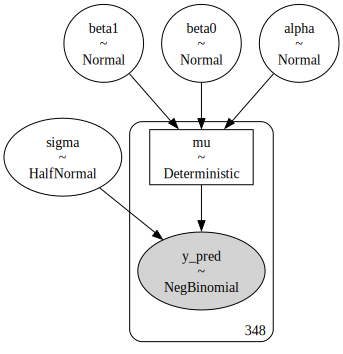

In [66]:
pm.model_to_graphviz(model_mlb)

In [67]:
with pm.Model() as model_mlb2:
    alpha = pm.Normal('alpha', mu = 0, sigma = 1)
    beta = pm.Normal('beta', mu = 0, sigma = 10, shape = 2)
    sigma = pm.HalfNormal('sigma', 10)
    mu = pm.Deterministic('mu', pm.math.exp(alpha + beta[0] * bikes.temperature + beta[1] * bikes.hour))
    _ = pm.NegativeBinomial('y_pred', mu = mu, alpha = sigma, observed = bikes.rented)
    idata_mlb2 = pm.sample()
    idata_mlb2.extend(pm.sample_posterior_predictive(idata_mlb2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [y_pred]


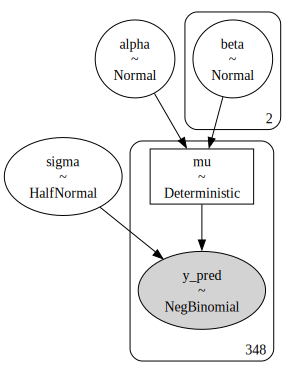

In [68]:
pm.model_to_graphviz(model_mlb2)

In [69]:
idata_neg.posterior["beta0_scaled"] = idata_neg.posterior["beta"] *  bikes.temperature.std()

In [70]:
idata_mlb.posterior["beta0_scaled"] = idata_mlb.posterior["beta0"] * bikes.temperature.std()
idata_mlb.posterior["beta1_scaled"] = idata_mlb.posterior["beta1"] * bikes.hour.std()

In [71]:
idata_mlb2.posterior["beta0_scaled"] = idata_mlb2.posterior["beta"][0] * bikes.temperature.std()
idata_mlb2.posterior["beta1_scaled"] = idata_mlb2.posterior["beta"][1] * bikes.hour.std()

In [72]:
idata_mlb2.posterior["beta"] 

<xarray.DataArray 'beta' (chain: 4, draw: 1000, beta_dim_0: 2)>
array([[[0.03101318, 0.06464305],
        [0.034169  , 0.07427947],
        [0.0443619 , 0.08461035],
        ...,
        [0.04629199, 0.09732035],
        [0.03706595, 0.09492467],
        [0.03531604, 0.09897245]],

       [[0.03570761, 0.07836439],
        [0.0337104 , 0.07472548],
        [0.03334822, 0.07862701],
        ...,
        [0.03407945, 0.08094391],
        [0.03503658, 0.07791782],
        [0.03128843, 0.08216749]],

       [[0.03926902, 0.07230482],
        [0.04309802, 0.07847968],
        [0.04263795, 0.07638381],
        ...,
        [0.03406285, 0.08963469],
        [0.04631023, 0.06366844],
        [0.04631023, 0.06366844]],

       [[0.03156853, 0.07966522],
        [0.04462686, 0.07415172],
        [0.03994164, 0.08946093],
        ...,
        [0.03824184, 0.08013271],
        [0.04002611, 0.08074298],
        [0.04282082, 0.08249195]]])
Coordinates:
  * chain       (chain) int64 0 1 2 3
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1

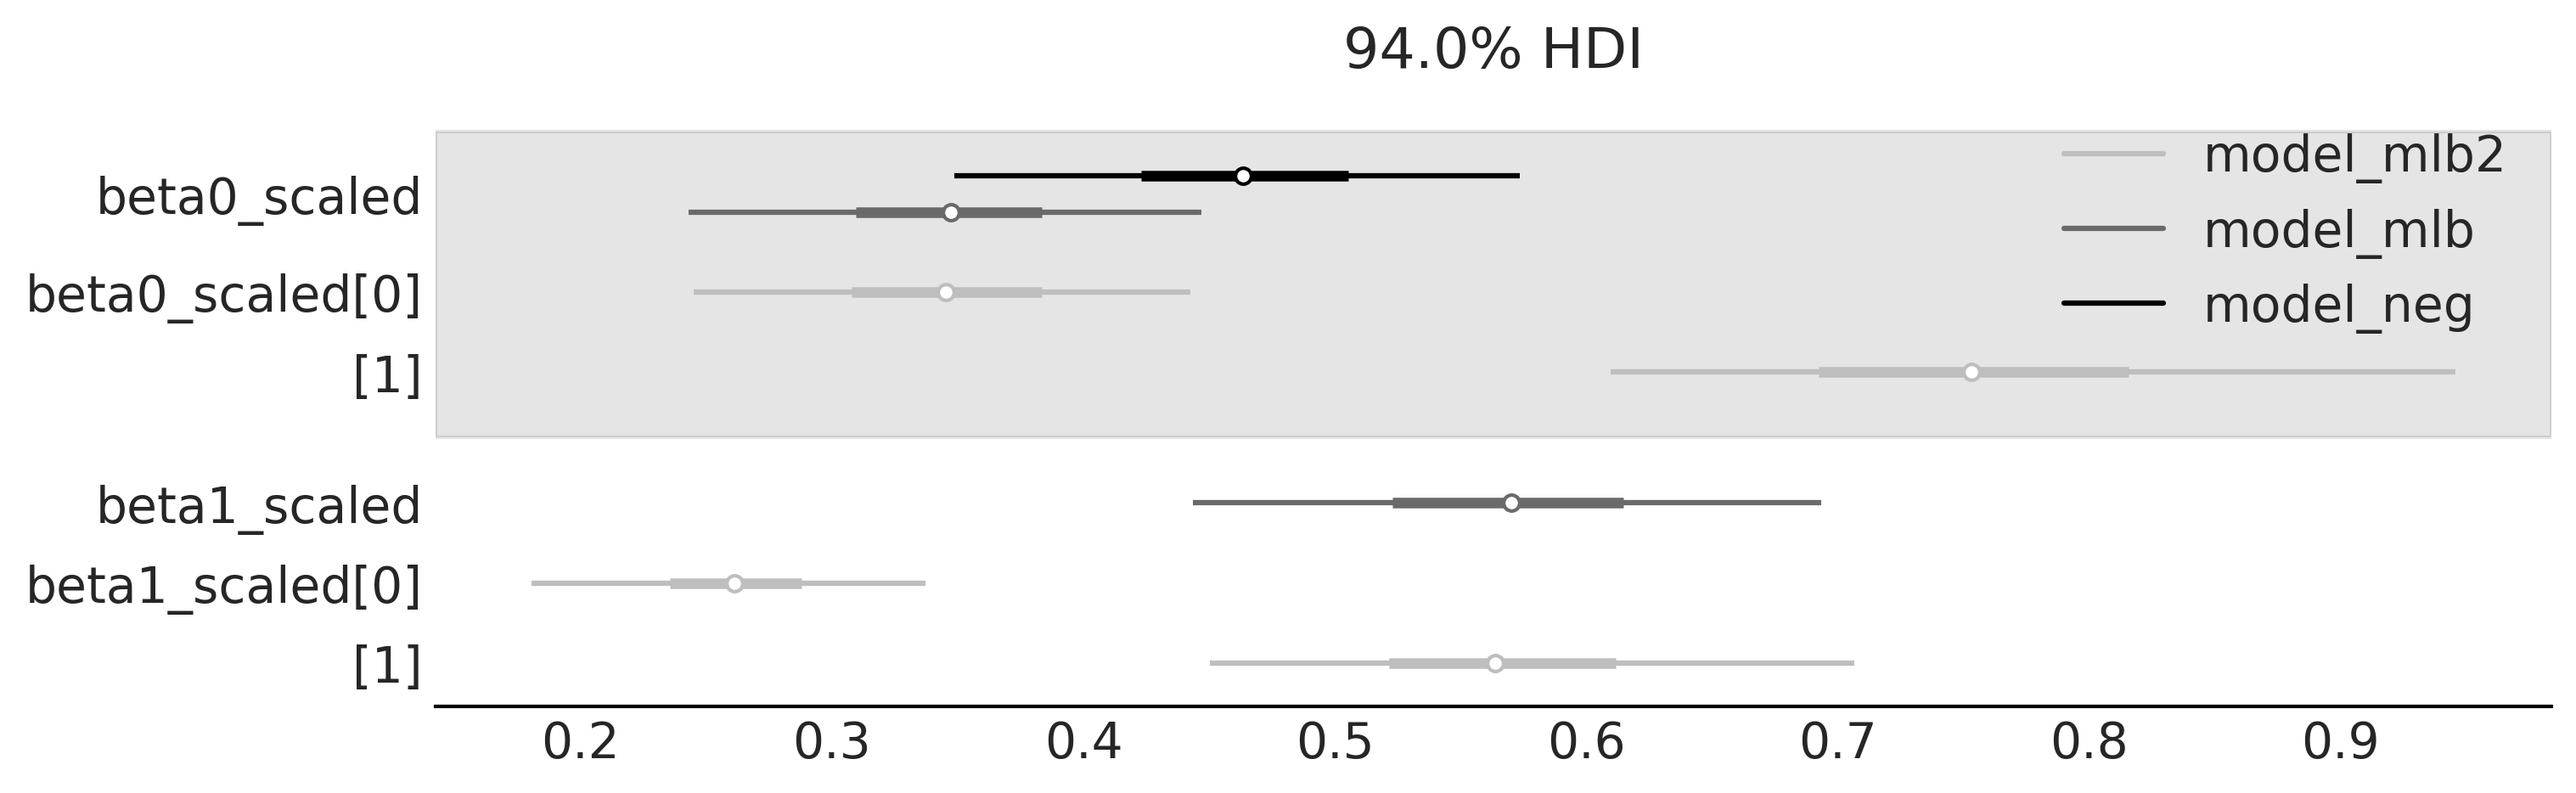

In [73]:
az.plot_forest(
    [idata_neg, idata_mlb, idata_mlb2], 
    model_names= ["model_neg", "model_mlb", "model_mlb2"],
    var_names=["beta0_scaled", "beta1_scaled"], 
    figsize=(10, 3),
    combined=True);

In [74]:
# help(bikes.temperature.std())

# Exploring xarray

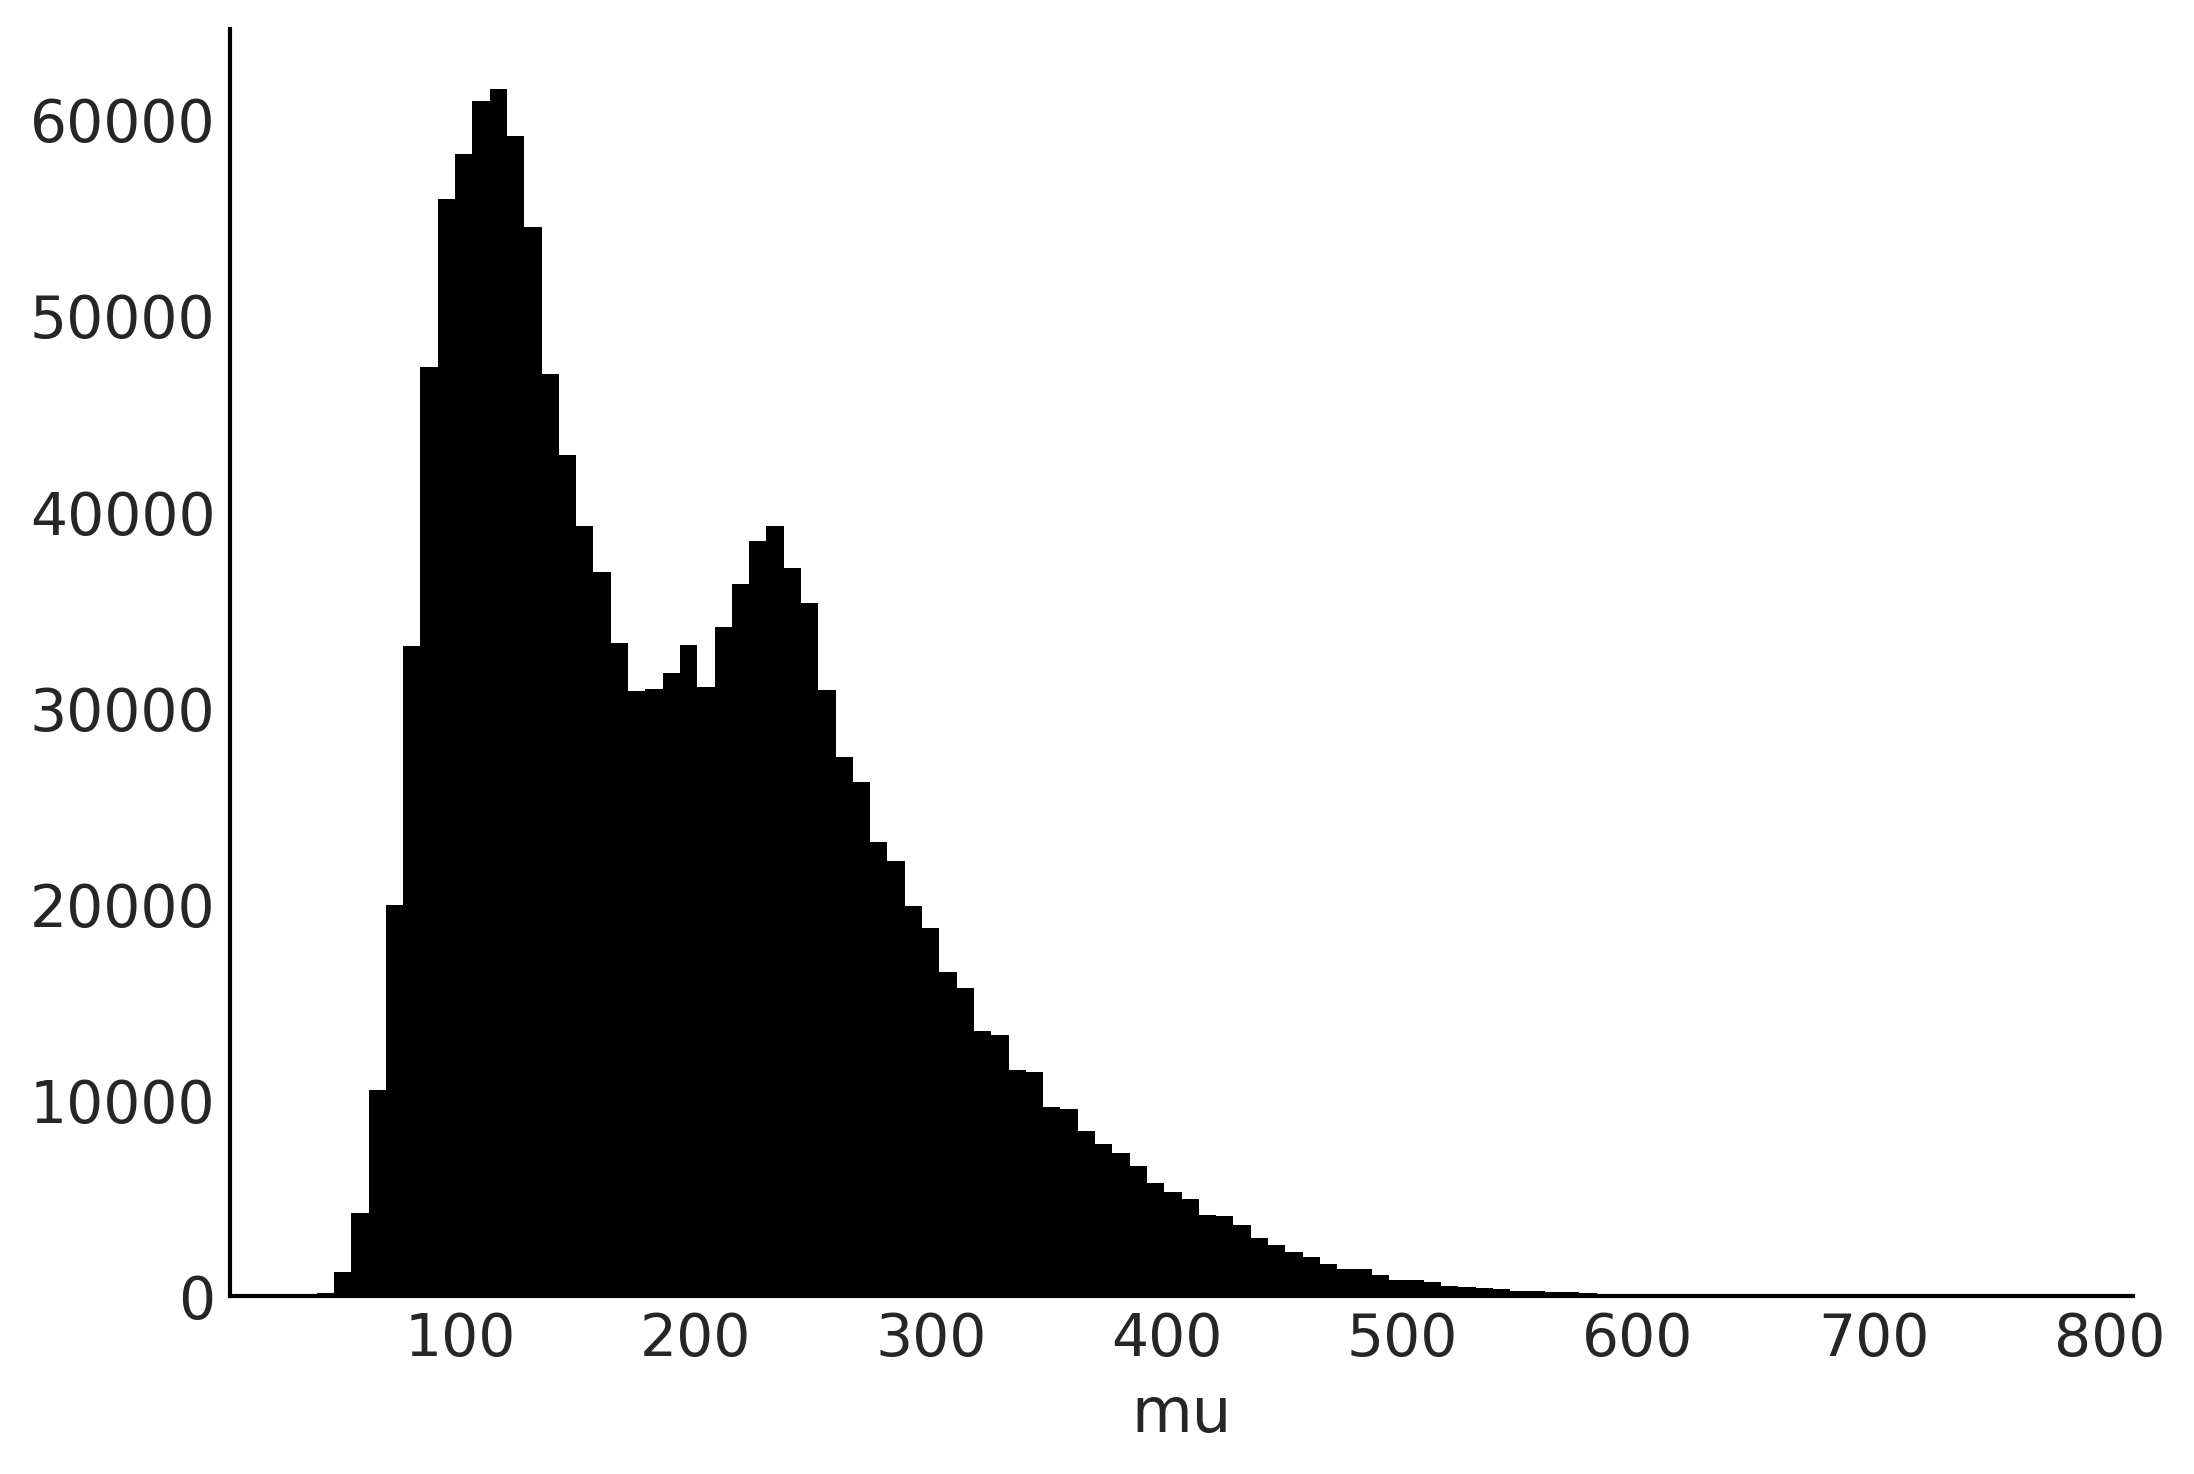

In [75]:
idata_neg.posterior['mu'].plot(bins = 100);

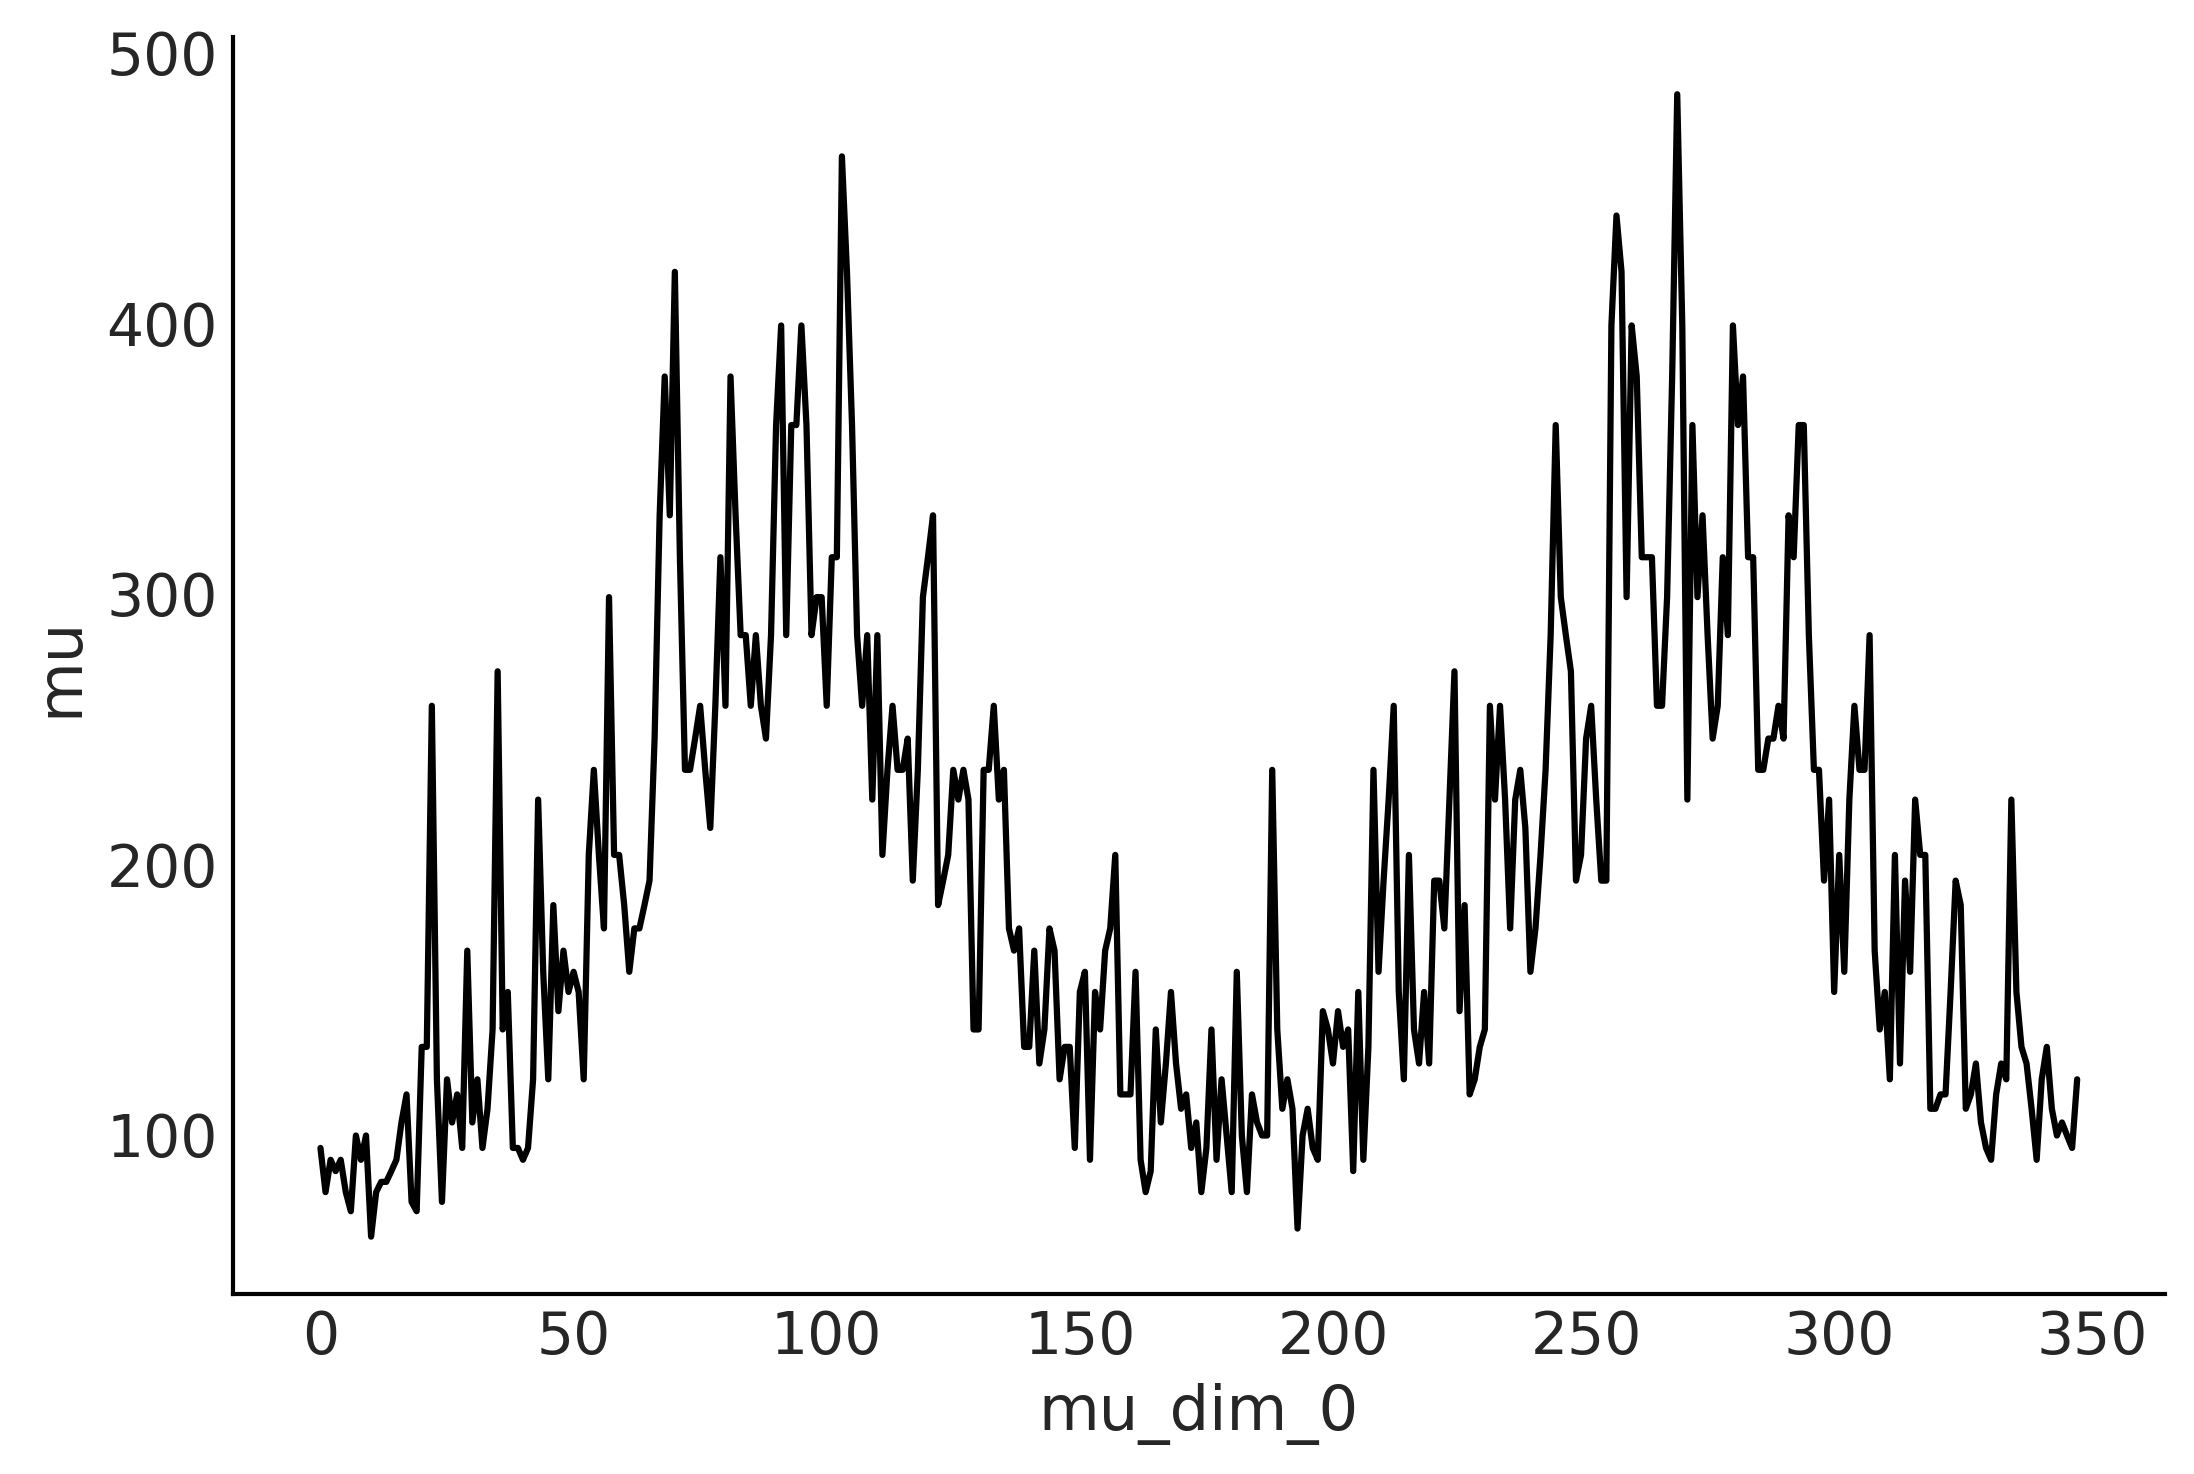

In [76]:
idata_neg.posterior['mu'].mean(("chain", "draw")).plot();

In [77]:
# dir(idata_neg.posterior)

In [78]:
idata_neg.posterior['alpha'].to_dataframe()

alpha
chain draw          
0     0     4.348442
      1     4.292466
      2     4.411281
      3     4.431247
      4     4.348995
...              ...
3     995   4.241570
      996   4.589942
      997   4.548494
      998   4.465108
      999   4.319655

[4000 rows x 1 columns]

In [79]:
idata_neg.posterior.items()

ItemsView(<xarray.Dataset>
Dimensions:       (chain: 4, draw: 1000, mu_dim_0: 348)
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * mu_dim_0      (mu_dim_0) int64 0 1 2 3 4 5 6 ... 341 342 343 344 345 346 347
Data variables:
    alpha         (chain, draw) float64 4.348 4.292 4.411 ... 4.548 4.465 4.32
    beta          (chain, draw) float64 0.05549 0.05398 ... 0.0455 0.05456
    sigma         (chain, draw) float64 1.02 0.9294 0.9288 ... 0.9394 0.9656
    mu            (chain, draw, mu_dim_0) float64 92.8 75.32 ... 89.89 116.2
    beta0_scaled  (chain, draw) float64 0.5068 0.493 0.4625 ... 0.4156 0.4983
Attributes:
    created_at:                 2024-03-31T20:38:51.528530
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              3.9101271629333496
    tuning_steps:               1000)

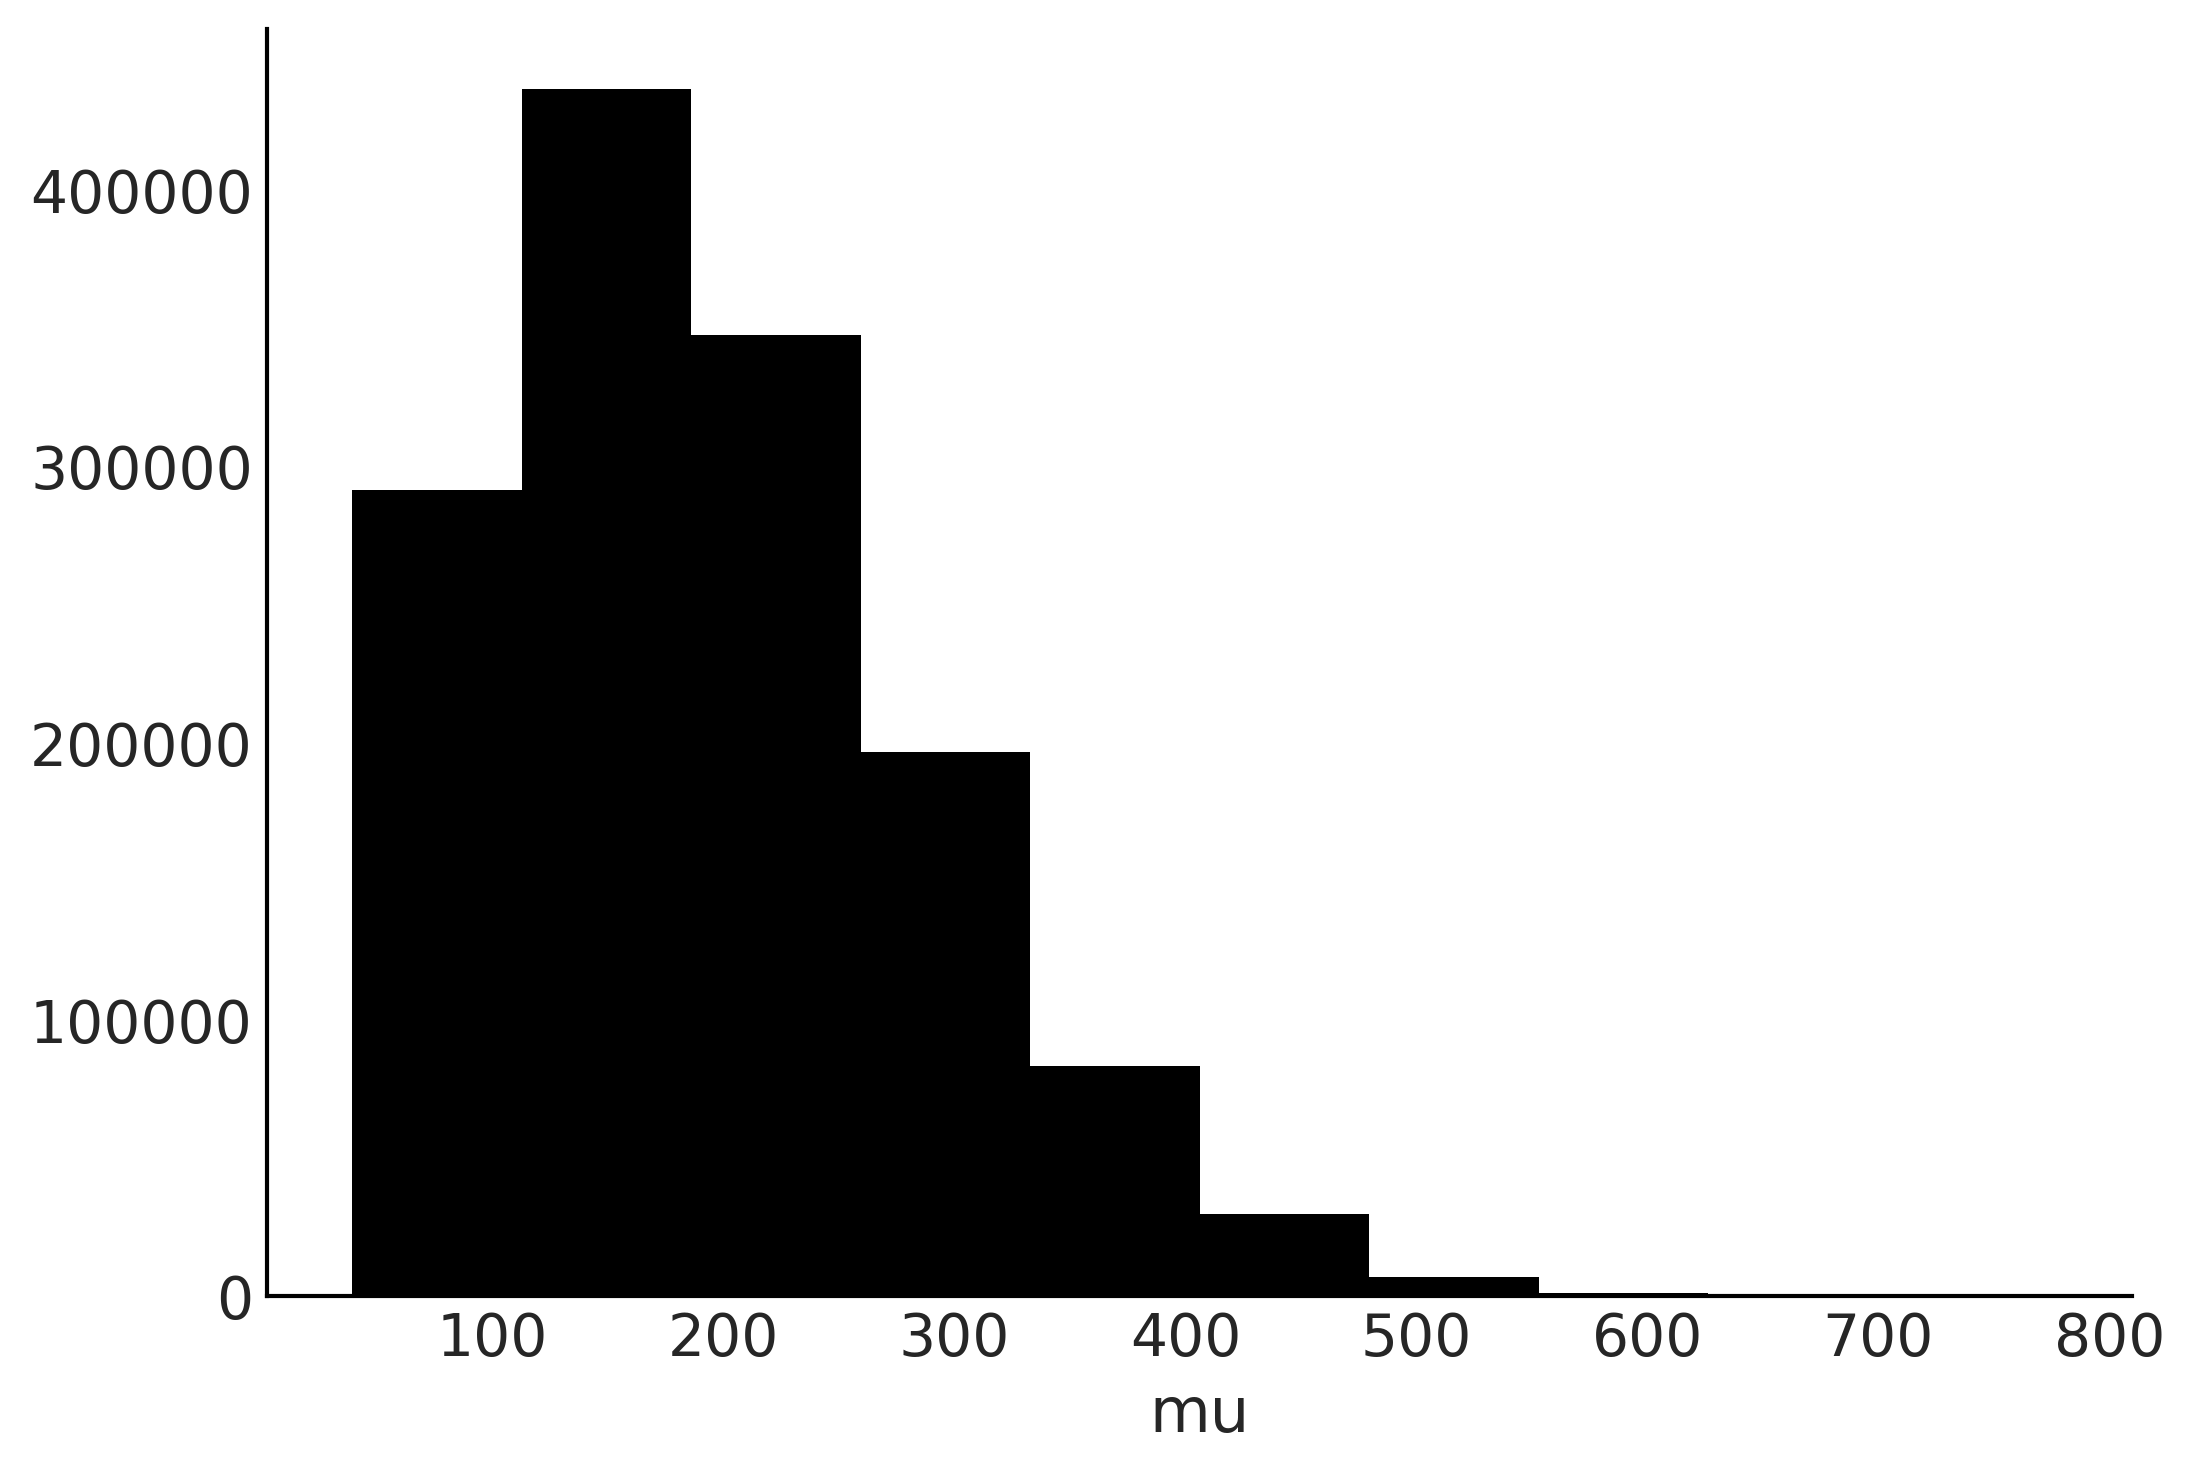

In [80]:
idata_neg.posterior.mu.plot();

In [81]:
# idata_neg.posterior
idata_neg.posterior['mu'].mean(("chain", "draw"))

<xarray.DataArray 'mu' (mu_dim_0: 348)>
array([ 94.78055616,  78.45882033,  90.40141715,  86.22786994,
        90.40141715,  78.45882033,  71.40054945,  99.3755868 ,
        90.40141715,  99.3755868 ,  62.00321913,  78.45882033,
        82.25011333,  82.25011333,  86.22786994,  90.40141715,
       104.19733331, 114.56705713,  74.84511481,  71.40054945,
       132.12590082, 132.12590082, 258.19582489, 120.13955627,
        74.84511481, 120.13955627, 104.19733331, 114.56705713,
        94.78055616, 167.69929967, 104.19733331, 120.13955627,
        94.78055616, 109.25717147, 138.56822172, 270.92937343,
       138.56822172, 152.42789807,  94.78055616,  94.78055616,
        90.40141715,  94.78055616, 120.13955627, 223.52588696,
       159.87833105, 120.13955627, 184.52875314, 145.33017898,
       167.69929967, 152.42789807, 159.87833105, 152.42789807,
       120.13955627, 203.07800772, 234.52280867, 203.07800772,
       175.90954059, 298.34550166, 203.07800772, 203.07800772,
       184.52875314, 159.87833105, 175.90954059, 175.90954059,
       184.52875314, 193.57764954, 246.07012021, 328.58604738,
       379.8986844 , 328.58604738, 418.56518646, 313.09492372,
       234.52280867, 234.52280867, 246.07012021, 258.19582489,
       234.52280867, 213.05272705, 258.19582489, 313.09492372,
...
       484.20630971, 398.75593275, 223.52588696, 361.94701232,
       298.34550166, 328.58604738, 284.30173989, 246.07012021,
       258.19582489, 313.09492372, 284.30173989, 398.75593275,
       361.94701232, 379.8986844 , 313.09492372, 313.09492372,
       234.52280867, 234.52280867, 246.07012021, 246.07012021,
       258.19582489, 246.07012021, 328.58604738, 313.09492372,
       361.94701232, 361.94701232, 284.30173989, 234.52280867,
       234.52280867, 193.57764954, 223.52588696, 152.42789807,
       203.07800772, 159.87833105, 223.52588696, 258.19582489,
       234.52280867, 234.52280867, 284.30173989, 167.69929967,
       138.56822172, 152.42789807, 120.13955627, 203.07800772,
       125.9878766 , 193.57764954, 159.87833105, 223.52588696,
       203.07800772, 203.07800772, 109.25717147, 109.25717147,
       114.56705713, 114.56705713, 152.42789807, 193.57764954,
       184.52875314, 109.25717147, 114.56705713, 125.9878766 ,
       104.19733331,  94.78055616,  90.40141715, 114.56705713,
       125.9878766 , 120.13955627, 223.52588696, 152.42789807,
       132.12590082, 125.9878766 , 109.25717147,  90.40141715,
       120.13955627, 132.12590082, 109.25717147,  99.3755868 ,
       104.19733331,  99.3755868 ,  94.78055616, 120.13955627])
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 341 342 343 344 345 346 347